In [1]:
#Processing "Surprise" class due to error
import os
import shutil
import uuid
import torch
import torch.nn as nn
from torchvision import transforms
from timm import create_model
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

c:\Users\Tuf\anaconda3\envs\DeepLearn\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ⚠️ Manually update this path before running
INPUT_FOLDER = "./Unsplitted_Ready_Sets/set_01_raw_mix"  # Replace with the actual path
OUTPUT_FOLDER = "./Unsplitted_Ready_Sets/set_02_raw_class_balanced"  # Where selected images will be stored
SKIP_FOLDER = "Sad"  # Folder that will be skipped
TARGET_IMAGE_COUNT = 7382  # Target number of images per class

# Emotion categories based on the model
EMOTION_CATEGORIES = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]

In [9]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# Load Model
MODEL_PATH = "adaptive_efficientnetv2_rw_s_emotion_model.pth"

def load_model(model_path, num_classes=8):
    print("🔄 Loading the trained EfficientNet-B2 model...")
    model = create_model('efficientnetv2_rw_s', pretrained=False, num_classes=num_classes, in_chans=1)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    print("✅ Model loaded successfully!")
    return model

✅ Using device: cuda


In [10]:
# Define image transformation (grayscale processing)
image_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((260, 260)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

# Load model
model = load_model(MODEL_PATH)

🔄 Loading the trained EfficientNet-B2 model...


C:\Users\Tuf\AppData\Local\Temp\ipykernel_4520\2480567632.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=devi

✅ Model loaded successfully!


In [11]:
# Step 1: Create the "OUTPUT_FOLDER" with subfolders
def initialize_output_folder():
    if not os.path.exists(OUTPUT_FOLDER):
        os.makedirs(OUTPUT_FOLDER)

    for emotion in EMOTION_CATEGORIES:
        emotion_folder = os.path.join(OUTPUT_FOLDER, emotion)
        if not os.path.exists(emotion_folder):
            os.makedirs(emotion_folder)

In [12]:
# Step 2: Process each category separately and find most confident images
def process_category(emotion_category):
    if emotion_category == SKIP_FOLDER:
        print(f"⏩ Skipping '{SKIP_FOLDER}' (Already has {TARGET_IMAGE_COUNT} images)")
        return

    source_folder = os.path.join(INPUT_FOLDER, emotion_category)
    
    # Check if the source folder exists
    if not os.path.exists(source_folder):
        print(f"❌ Skipping {emotion_category}: No such folder in dataset.")
        return

    # Get all images in the category folder
    image_paths = [
        os.path.join(source_folder, file) for file in os.listdir(source_folder)
        if file.lower().endswith((".jpg", ".jpeg", ".png"))
    ]

    print(f"📂 Processing {len(image_paths)} images in category: {emotion_category}")

    # Store confidence scores for each image
    confidence_scores = []

    for img_path in tqdm(image_paths, desc=f"Analyzing {emotion_category}"):
        try:
            # Load and process the image
            img = Image.open(img_path).convert("L")  
            input_tensor = image_transform(img).unsqueeze(0).to(device)

            # Get model confidence
            with torch.no_grad():
                output = model(input_tensor)
                probabilities = torch.nn.functional.softmax(output, dim=1)
                confidence, predicted = torch.max(probabilities, 1)

            predicted_emotion = EMOTION_CATEGORIES[predicted.item()]
            confidence = confidence.item()

            # Store confidence score (even if incorrect prediction)
            confidence_scores.append((img_path, confidence))

        except Exception as e:
            print(f"⚠️ Error processing {img_path}: {e}")
            continue  # Skip this image and continue

    # Step 3: Ensure exactly 7382 images are selected
    confidence_scores.sort(key=lambda x: x[1], reverse=True)  # Sort by confidence (descending)

    if len(confidence_scores) >= TARGET_IMAGE_COUNT:
        selected_images = confidence_scores[:TARGET_IMAGE_COUNT]  # Select top 7382
    else:
        selected_images = confidence_scores  # If fewer images exist, keep all

    print(f"✅ Selected {len(selected_images)} highest confidence images for '{emotion_category}'")

    # Step 4: Copy selected images to the output folder
    target_folder = os.path.join(OUTPUT_FOLDER, emotion_category)
    
    for img_path, conf in selected_images:
        try:
            unique_name = str(uuid.uuid4())[:8] + "_" + os.path.basename(img_path)
            target_path = os.path.join(target_folder, unique_name)
            shutil.copy(img_path, target_path)
        except Exception as e:
            print(f"⚠️ Error copying {img_path}: {e}")

    # Step 5: Generate Confidence Distribution Plot
    plot_confidence_distribution(emotion_category, [conf for _, conf in confidence_scores])

# Step 5: Plot Confidence Distribution
def plot_confidence_distribution(category, confidence_scores):
    plt.figure(figsize=(10, 5))
    sns.histplot(confidence_scores, bins=30, kde=True, color="blue")
    plt.xlabel("Confidence Score")
    plt.ylabel("Frequency")
    plt.title(f"Confidence Distribution for {category}")
    plt.grid()
    plt.show()

📂 Processing 9114 images in category: Angry


Analyzing Angry: 100%|██████████| 9114/9114 [09:56<00:00, 15.28it/s]


✅ Selected 7382 highest confidence images for 'Angry'


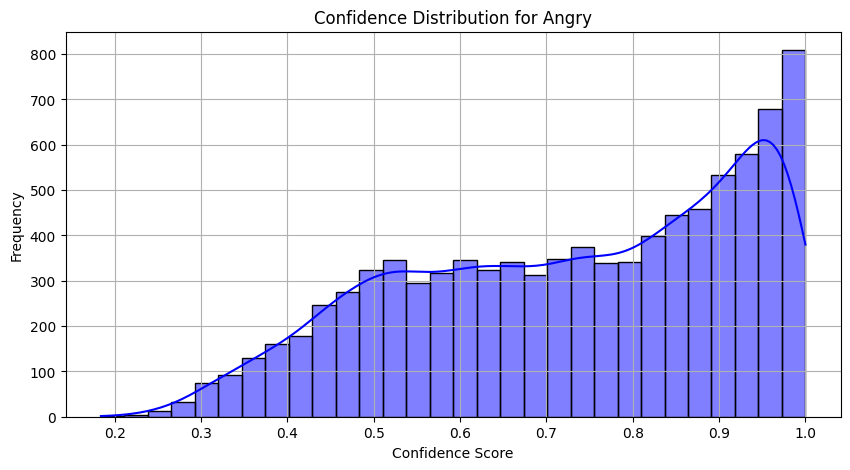

📂 Processing 9261 images in category: Disgust


Analyzing Disgust: 100%|██████████| 9261/9261 [10:12<00:00, 15.12it/s]


✅ Selected 7382 highest confidence images for 'Disgust'


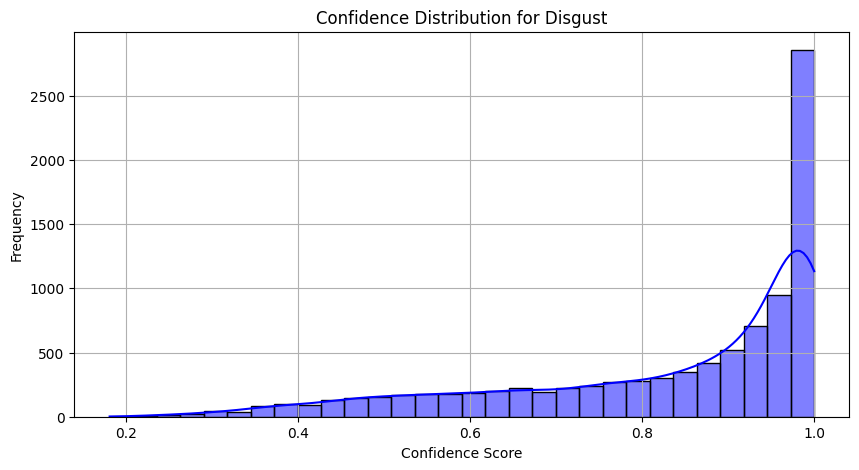

📂 Processing 8866 images in category: Fear


Analyzing Fear: 100%|██████████| 8866/8866 [10:03<00:00, 14.69it/s]


✅ Selected 7382 highest confidence images for 'Fear'


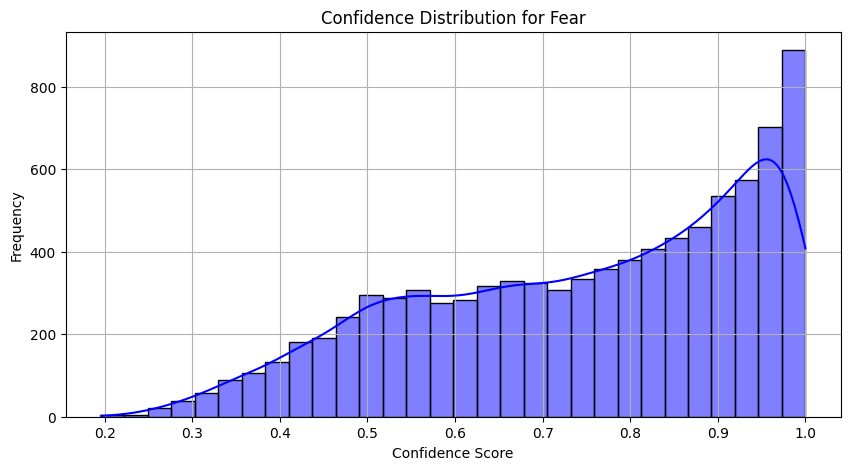

📂 Processing 15925 images in category: Happy


Analyzing Happy: 100%|██████████| 15925/15925 [19:35<00:00, 13.55it/s]


✅ Selected 7382 highest confidence images for 'Happy'


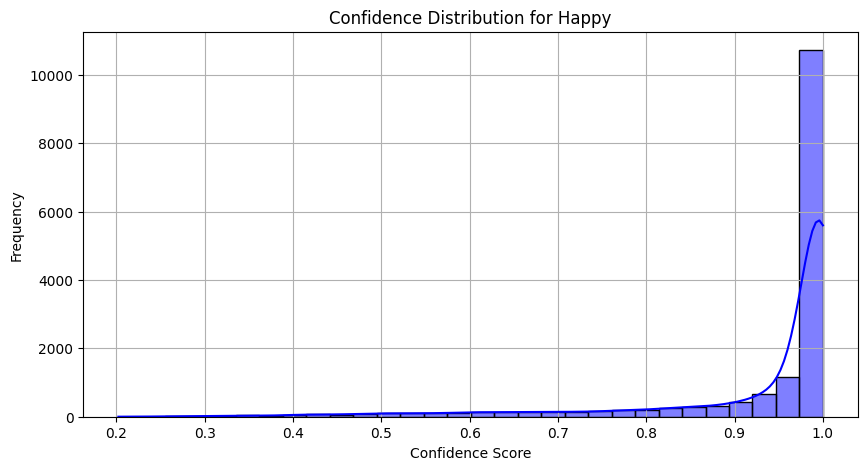

📂 Processing 14083 images in category: Neutral


Analyzing Neutral: 100%|██████████| 14083/14083 [15:59<00:00, 14.68it/s]


✅ Selected 7382 highest confidence images for 'Neutral'


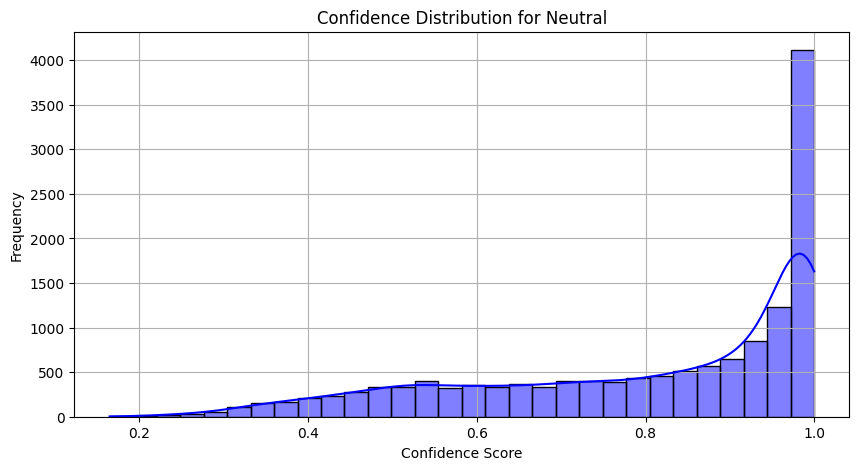

⏩ Skipping 'Sad' (Already has 7382 images)
📂 Processing 9198 images in category: Surprise


Analyzing Surprise:   0%|          | 1/9198 [00:00<18:07,  8.45it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0002563c_image0029151.jpg: list index out of range


Analyzing Surprise:   0%|          | 3/9198 [00:00<30:43,  4.99it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\000926ba_colorized_surprise5468.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0018e006_colorized_surprise4701.png: list index out of range


Analyzing Surprise:   0%|          | 5/9198 [00:00<27:52,  5.50it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0020dd84_image0034093.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0034eec1_colorized_surprise8061.png: list index out of range


Analyzing Surprise:   0%|          | 7/9198 [00:01<19:58,  7.67it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0037d6f4_colorized_surprise14663.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\003ea17c_colorized_surprise14852.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\005ac0bf_colorized_surprise14614.png: list index out of range


Analyzing Surprise:   0%|          | 10/9198 [00:01<21:50,  7.01it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\005b4804_colorized_surprise5772.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\00612b87_colorized_surprise15772.png: list index out of range


Analyzing Surprise:   0%|          | 12/9198 [00:01<20:25,  7.50it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0070680c_colorized_surprise15895.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\00737804_image0014118.jpg: list index out of range


Analyzing Surprise:   0%|          | 14/9198 [00:01<18:24,  8.31it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\00783523_image0027191.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\007f0e89_colorized_surprise12589.png: list index out of range


Analyzing Surprise:   0%|          | 16/9198 [00:02<16:10,  9.46it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\00818b7f_image0001759.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\008e5748_colorized_surprise6558.png: list index out of range


Analyzing Surprise:   0%|          | 18/9198 [00:02<21:01,  7.28it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\00912eda_image0029551.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\009cbf71_colorized_surprise4185.png: list index out of range


Analyzing Surprise:   0%|          | 21/9198 [00:02<16:31,  9.26it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\00a2a041_colorized_surprise7805.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\00a4281b_colorized_surprise9128.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\00acbc6c_colorized_surprise7773.png: list index out of range


Analyzing Surprise:   0%|          | 23/9198 [00:02<15:20,  9.96it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\00b73d78_colorized_surprise7628.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\00bea1e0_image0023178.jpg: list index out of range


Analyzing Surprise:   0%|          | 25/9198 [00:03<15:40,  9.76it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\00bf8a46_colorized_surprise14204.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\00c48566_colorized_surprise12783.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\00cef928_image0021521.jpg: list index out of range


Analyzing Surprise:   0%|          | 29/9198 [00:03<13:31, 11.30it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\00d71a7b_image0028244.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\00df8ece_colorized_surprise2452.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\00dfd629_colorized_surprise2617.png: list index out of range


Analyzing Surprise:   0%|          | 31/9198 [00:03<12:33, 12.16it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\00e0b24a_colorized_surprise991.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\00e67603_colorized_surprise2999.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\00ed2245_colorized_surprise11870.png: list index out of range


Analyzing Surprise:   0%|          | 35/9198 [00:03<12:27, 12.26it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\00eed6f5_colorized_surprise3652.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\00fbe0e1_image0025692.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\010e03c3_colorized_surprise9778.png: list index out of range


Analyzing Surprise:   0%|          | 37/9198 [00:04<12:55, 11.81it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\010f862f_colorized_surprise12979.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\011746fc_colorized_surprise432.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\011c4d37_colorized_surprise843.png: list index out of range


Analyzing Surprise:   0%|          | 41/9198 [00:04<13:43, 11.12it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\011c9fbe_image0033389.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\011fd6c6_colorized_surprise4609.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\013dfa94_colorized_surprise4971.png: list index out of range


Analyzing Surprise:   0%|          | 43/9198 [00:04<13:14, 11.53it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\013e4448_image0031020.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\013f460c_colorized_surprise8234.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0145ec76_colorized_surprise9892.png: list index out of range


Analyzing Surprise:   1%|          | 47/9198 [00:05<13:23, 11.39it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\01584a20_colorized_surprise9423.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\015ebe39_colorized_surprise8258.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\016104e1_colorized_surprise15987.png: list index out of range


Analyzing Surprise:   1%|          | 49/9198 [00:05<13:58, 10.92it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0165bf93_image0026571.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0168ab3c_colorized_surprise3788.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\01746916_colorized_surprise2757.png: list index out of range


Analyzing Surprise:   1%|          | 53/9198 [00:05<13:38, 11.17it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0178a2b0_colorized_surprise337.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\018e213c_colorized_surprise1066.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0191cd6a_colorized_surprise3864.png: list index out of range


Analyzing Surprise:   1%|          | 57/9198 [00:05<13:03, 11.66it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0197e602_colorized_surprise8533.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\019c0b91_colorized_surprise3472.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\019c86e7_colorized_surprise7251.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\01a5b350_colorized_surprise15808.png: list index out of range


Analyzing Surprise:   1%|          | 59/9198 [00:06<12:04, 12.61it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\01ac9d3a_colorized_surprise509.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\01adef0c_image0034887.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\01ae5ffa_image0033530.jpg: list index out of range


Analyzing Surprise:   1%|          | 63/9198 [00:06<11:15, 13.52it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\01aea23c_colorized_surprise15482.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\01b4f7f2_colorized_surprise11431.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\01bfef64_colorized_surprise3327.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\01c428b2_colorized_surprise16003.png: list index out of range


Analyzing Surprise:   1%|          | 67/9198 [00:06<11:16, 13.50it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\01d09061_image0031700.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\01d78bb5_colorized_surprise891.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\01e48008_colorized_surprise14064.png: list index out of range


Analyzing Surprise:   1%|          | 69/9198 [00:06<11:39, 13.05it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\01e5811d_image0025412.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\01f95d5d_colorized_surprise993.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\01fb228a_colorized_surprise9698.png: list index out of range


Analyzing Surprise:   1%|          | 71/9198 [00:06<12:53, 11.80it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\01fdd323_colorized_surprise12280.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\02014cce_image0001526.jpg: list index out of range


Analyzing Surprise:   1%|          | 75/9198 [00:07<13:10, 11.54it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\020be6dc_colorized_surprise7537.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\020c73e7_colorized_surprise2260.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\021d3bff_colorized_surprise12185.png: list index out of range


Analyzing Surprise:   1%|          | 77/9198 [00:07<13:29, 11.26it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\02207f18_colorized_surprise14206.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0228011a_colorized_surprise8031.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\02307e7f_colorized_surprise7986.png: list index out of range


Analyzing Surprise:   1%|          | 81/9198 [00:07<12:30, 12.14it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\023c070f_colorized_surprise12811.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\023ed60d_image0031076.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\023eef47_colorized_surprise15206.png: list index out of range


Analyzing Surprise:   1%|          | 83/9198 [00:08<12:38, 12.02it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\024266a3_colorized_surprise1959.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\024a3217_image0021543.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\024fafb9_image0032924.jpg: list index out of range


Analyzing Surprise:   1%|          | 87/9198 [00:08<12:43, 11.93it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\024fb800_image0028311.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0252ceb4_colorized_surprise6425.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0258e22a_colorized_surprise3312.png: list index out of range


Analyzing Surprise:   1%|          | 89/9198 [00:08<12:47, 11.87it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\02607915_colorized_surprise15934.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0274ce21_colorized_surprise14197.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0277d8d6_colorized_surprise4121.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\02904c9c_colorized_surprise1055.png: list index out of range


Analyzing Surprise:   1%|          | 93/9198 [00:08<12:36, 12.04it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0290e29e_colorized_surprise11193.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0295a55f_colorized_surprise14325.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\02a79909_colorized_surprise3808.png: list index out of range


Analyzing Surprise:   1%|          | 97/9198 [00:09<12:39, 11.99it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\02b9f4ea_image0012438.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\02be000e_colorized_surprise11872.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\02bfda73_colorized_surprise4659.png: list index out of range


Analyzing Surprise:   1%|          | 99/9198 [00:09<12:18, 12.32it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\02d7e818_colorized_surprise15775.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\02d9a767_colorized_surprise14272.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\02e9f4f6_colorized_surprise1326.png: list index out of range


Analyzing Surprise:   1%|          | 103/9198 [00:09<11:32, 13.14it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\03038c70_colorized_surprise2155.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\03069cdc_colorized_surprise3026.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\030d1533_image0033524.jpg: list index out of range


Analyzing Surprise:   1%|          | 105/9198 [00:09<12:39, 11.97it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0310a0d5_image0030784.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\031fcaeb_colorized_surprise9800.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\032163d5_colorized_surprise3705.png: list index out of range


Analyzing Surprise:   1%|          | 109/9198 [00:10<12:14, 12.37it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0321a9e9_colorized_surprise13140.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\032cec6a_colorized_surprise15586.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\033bf1f9_colorized_surprise8978.png: list index out of range


Analyzing Surprise:   1%|          | 111/9198 [00:10<13:01, 11.63it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0345ac01_image0017451.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\03480c27_colorized_surprise13786.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\03517bf8_colorized_surprise15473.png: list index out of range


Analyzing Surprise:   1%|▏         | 115/9198 [00:10<11:40, 12.97it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\035e2535_colorized_surprise3023.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0365bbcc_image0033158.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\03685848_colorized_surprise176.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\036f1f3a_colorized_surprise8619.png: list index out of range


Analyzing Surprise:   1%|▏         | 119/9198 [00:10<10:55, 13.85it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0371da53_colorized_surprise1765.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\038be7b3_colorized_surprise12997.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\038d0eae_image0022229.jpg: list index out of range


Analyzing Surprise:   1%|▏         | 121/9198 [00:11<10:18, 14.68it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\03959e71_colorized_surprise7810.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\039da0df_colorized_surprise8587.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\03a74f23_colorized_surprise10236.png: list index out of range


Analyzing Surprise:   1%|▏         | 125/9198 [00:11<10:13, 14.79it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\03b93292_colorized_surprise8166.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\03bcda8e_colorized_surprise3711.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\03d01409_colorized_surprise7655.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\03d40f02_image0003327.jpg: list index out of range


Analyzing Surprise:   1%|▏         | 129/9198 [00:11<10:23, 14.55it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\03f601bf_colorized_surprise3563.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0400ed33_colorized_surprise2353.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0404dd6e_colorized_surprise767.png: list index out of range


Analyzing Surprise:   1%|▏         | 131/9198 [00:11<11:08, 13.55it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\04095ca8_colorized_surprise9535.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\040c6718_colorized_surprise3385.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\040e108c_colorized_surprise15302.png: list index out of range


Analyzing Surprise:   1%|▏         | 135/9198 [00:12<12:29, 12.10it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\040feeaa_image0031108.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0421bad9_image0015096.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\042b4844_colorized_surprise9119.png: list index out of range


Analyzing Surprise:   1%|▏         | 137/9198 [00:12<12:23, 12.19it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\04342015_colorized_surprise9466.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\043b0daa_colorized_surprise1005.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\043bc9c3_image0014856.jpg: list index out of range


Analyzing Surprise:   2%|▏         | 139/9198 [00:12<12:10, 12.40it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\04556655_image0012833.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\04564f83_image0021570.jpg: list index out of range


Analyzing Surprise:   2%|▏         | 141/9198 [00:12<13:35, 11.10it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\046f64f6_colorized_surprise5694.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0477e206_image0030203.jpg: list index out of range


Analyzing Surprise:   2%|▏         | 143/9198 [00:12<14:29, 10.42it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0478059c_colorized_surprise874.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\047b6fae_colorized_surprise7729.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\047b80da_colorized_surprise15572.png: list index out of range


Analyzing Surprise:   2%|▏         | 147/9198 [00:13<14:01, 10.76it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0480fc0e_image0032055.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\04866cec_image0002021.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\048a0902_image0031628.jpg: list index out of range


Analyzing Surprise:   2%|▏         | 151/9198 [00:13<13:00, 11.59it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\04929136_image0029820.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\04972ff2_image0033085.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0497df7e_colorized_surprise15805.png: list index out of range


Analyzing Surprise:   2%|▏         | 153/9198 [00:13<13:08, 11.46it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0498335f_image0004451.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\04991cee_colorized_surprise13109.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\049e2471_image0003012.jpg: list index out of range


Analyzing Surprise:   2%|▏         | 157/9198 [00:14<12:36, 11.95it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\04a0c5f6_image0034401.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\04a7e64d_image0007120.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\04ab5232_image0030762.jpg: list index out of range


Analyzing Surprise:   2%|▏         | 159/9198 [00:14<13:16, 11.35it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\04b5bb25_colorized_surprise7800.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\04b9b63e_colorized_surprise15802.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\04c55f3c_image0023999.jpg: list index out of range


Analyzing Surprise:   2%|▏         | 163/9198 [00:14<13:01, 11.56it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\04cba61e_colorized_surprise1952.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\04d218d5_colorized_surprise12694.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\04d2f1dc_image0025803.jpg: list index out of range


Analyzing Surprise:   2%|▏         | 165/9198 [00:14<12:50, 11.72it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\04eaddd5_image0032020.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\04f20ff0_colorized_surprise2008.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\04f46d3a_colorized_surprise11985.png: list index out of range


Analyzing Surprise:   2%|▏         | 169/9198 [00:15<11:39, 12.91it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\04f6ea02_colorized_surprise11538.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\04ff883f_image0031974.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0508bdb9_colorized_surprise8222.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\05179678_colorized_surprise12195.png: list index out of range


Analyzing Surprise:   2%|▏         | 173/9198 [00:15<12:11, 12.33it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\05196de6_colorized_surprise5072.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\051a4a86_colorized_surprise13243.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\05333d01_image0032781.jpg: list index out of range


Analyzing Surprise:   2%|▏         | 175/9198 [00:15<12:45, 11.79it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0538a6df_colorized_surprise14972.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\053cb73e_colorized_surprise813.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\05419ef7_colorized_surprise8970.png: list index out of range


Analyzing Surprise:   2%|▏         | 177/9198 [00:15<12:55, 11.64it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\054a6aed_colorized_surprise11690.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\054ea4e4_colorized_surprise2967.png: list index out of range


Analyzing Surprise:   2%|▏         | 181/9198 [00:16<13:08, 11.44it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\055322fb_colorized_surprise7895.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\055585aa_colorized_surprise13521.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\05571be3_colorized_surprise15468.png: list index out of range


Analyzing Surprise:   2%|▏         | 185/9198 [00:16<11:56, 12.58it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\055843b9_image0027054.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\055b3af6_colorized_surprise14426.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0566a84a_image0026373.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\056a0734_colorized_surprise1983.png: list index out of range


Analyzing Surprise:   2%|▏         | 187/9198 [00:16<12:15, 12.26it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0578c4a5_colorized_surprise14413.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\057f3587_image0007081.jpg: list index out of range


Analyzing Surprise:   2%|▏         | 189/9198 [00:16<13:30, 11.12it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\05835352_image0009677.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0583db30_colorized_surprise13240.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\059a5e7f_colorized_surprise15973.png: list index out of range


Analyzing Surprise:   2%|▏         | 191/9198 [00:16<13:23, 11.21it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\059dae39_colorized_surprise13292.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\05a2672d_colorized_surprise4885.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\05a87562_image0034300.jpg: list index out of range


Analyzing Surprise:   2%|▏         | 195/9198 [00:17<13:33, 11.07it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\05b37cb2_colorized_surprise5432.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\05c83cbe_colorized_surprise8551.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\05cac4ce_image0007925.jpg: list index out of range


Analyzing Surprise:   2%|▏         | 199/9198 [00:17<13:06, 11.43it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\05ce580a_colorized_surprise12743.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\05d7958e_image0012210.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\05dee4ff_colorized_surprise7923.png: list index out of range


Analyzing Surprise:   2%|▏         | 201/9198 [00:17<12:42, 11.80it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\05e55eda_image0002777.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\05faefd4_image0026568.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\05fbbfdc_colorized_surprise16070.png: list index out of range


Analyzing Surprise:   2%|▏         | 203/9198 [00:18<13:12, 11.35it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\060d7e0a_colorized_surprise5062.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0627fee9_colorized_surprise7092.png: list index out of range


Analyzing Surprise:   2%|▏         | 207/9198 [00:18<13:31, 11.08it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\06281f25_colorized_surprise7653.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\062bdb99_image0027106.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\062c0b28_colorized_surprise15786.png: list index out of range


Analyzing Surprise:   2%|▏         | 209/9198 [00:18<13:18, 11.25it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0637ee64_image0026904.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\06492d21_colorized_surprise5914.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\06571f34_colorized_surprise12667.png: list index out of range


Analyzing Surprise:   2%|▏         | 213/9198 [00:19<14:23, 10.41it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0671524b_colorized_surprise15947.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0681b683_image0025759.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\068c21ed_colorized_surprise1340.png: list index out of range


Analyzing Surprise:   2%|▏         | 215/9198 [00:19<13:35, 11.01it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\068c70e8_colorized_surprise4796.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\06918f83_colorized_surprise9695.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\069b9865_colorized_surprise11231.png: list index out of range


Analyzing Surprise:   2%|▏         | 219/9198 [00:19<12:55, 11.57it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\06a42e2b_colorized_surprise14002.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\06a6280f_colorized_surprise1292.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\06a8e19d_colorized_surprise405.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\06b07c40_colorized_surprise11553.png: list index out of range


Analyzing Surprise:   2%|▏         | 223/9198 [00:19<10:56, 13.66it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\06b1dafa_colorized_surprise14779.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\06b3187e_colorized_surprise7860.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\06bc4dab_colorized_surprise3082.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\06bcf8ed_image0013563.jpg: list index out of range


Analyzing Surprise:   2%|▏         | 227/9198 [00:19<09:42, 15.41it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\06bdfbc6_colorized_surprise4562.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\06c2e2e6_colorized_surprise3555.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\06cb863d_colorized_surprise684.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\06d0243f_colorized_surprise7946.png: list index out of range


Analyzing Surprise:   3%|▎         | 231/9198 [00:20<10:51, 13.76it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\06d750ab_colorized_surprise2515.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\06e3bc18_image0020518.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\07042d15_colorized_surprise7937.png: list index out of range


Analyzing Surprise:   3%|▎         | 233/9198 [00:20<12:26, 12.01it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0709a542_image0020426.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0709ba7d_colorized_surprise15581.png: list index out of range


Analyzing Surprise:   3%|▎         | 235/9198 [00:20<13:47, 10.83it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\070a7719_image0022844.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\071147a2_colorized_surprise2611.png: list index out of range


Analyzing Surprise:   3%|▎         | 237/9198 [00:20<13:31, 11.04it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\071cc102_image0003689.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\072489f9_colorized_surprise2885.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0744db84_colorized_surprise12242.png: list index out of range


Analyzing Surprise:   3%|▎         | 239/9198 [00:21<13:28, 11.08it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\074bcf12_image0033479.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\074ce522_colorized_surprise2256.png: list index out of range


Analyzing Surprise:   3%|▎         | 241/9198 [00:21<15:08,  9.86it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\07569070_colorized_surprise7009.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0759aff1_colorized_surprise4770.png: list index out of range


Analyzing Surprise:   3%|▎         | 245/9198 [00:21<14:24, 10.35it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0799cf9f_colorized_surprise1767.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\079c6e3f_colorized_surprise493.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\07cf3b42_colorized_surprise3032.png: list index out of range


Analyzing Surprise:   3%|▎         | 247/9198 [00:21<14:23, 10.37it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\07cfc664_colorized_surprise4465.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\07d0da5a_image0033624.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\07d57248_colorized_surprise7772.png: list index out of range


Analyzing Surprise:   3%|▎         | 251/9198 [00:22<11:56, 12.49it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\07ee68c1_image0008869.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\07f46971_image0033772.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\07f5754e_colorized_surprise8623.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\07fe9efa_image0013360.jpg: list index out of range


Analyzing Surprise:   3%|▎         | 255/9198 [00:22<10:58, 13.58it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\08048602_image0025733.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\080bb2c9_colorized_surprise15564.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0813cd63_image0034654.jpg: list index out of range


Analyzing Surprise:   3%|▎         | 257/9198 [00:22<10:16, 14.51it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\081dfdf7_image0001397.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\081e55ed_colorized_surprise9517.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\08215222_colorized_surprise4663.png: list index out of range


Analyzing Surprise:   3%|▎         | 261/9198 [00:22<10:52, 13.69it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0824dc8e_colorized_surprise1212.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\083aa6a5_colorized_surprise15647.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0846698c_colorized_surprise13820.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\084d0f5c_image0009252.jpg: list index out of range


Analyzing Surprise:   3%|▎         | 265/9198 [00:23<11:10, 13.31it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0851eb37_image0026899.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0871f753_colorized_surprise2326.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\087b79f7_colorized_surprise14082.png: list index out of range


Analyzing Surprise:   3%|▎         | 267/9198 [00:23<10:48, 13.77it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\088f27d4_colorized_surprise3919.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\08a184a3_colorized_surprise2395.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\08a78388_colorized_surprise3022.png: list index out of range


Analyzing Surprise:   3%|▎         | 271/9198 [00:23<10:32, 14.11it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\08ab27e3_colorized_surprise7787.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\08baf42c_colorized_surprise12625.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\08bc95f3_colorized_surprise15168.png: list index out of range


Analyzing Surprise:   3%|▎         | 273/9198 [00:23<10:23, 14.32it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\08c66769_colorized_surprise108.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\08ca70de_colorized_surprise1376.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\08cd8d5e_image0029248.jpg: list index out of range


Analyzing Surprise:   3%|▎         | 277/9198 [00:23<10:29, 14.16it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\08d7ccc9_colorized_surprise2865.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\08d8d227_image0020879.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\08d8e365_colorized_surprise9607.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\08edee78_colorized_surprise15661.png: list index out of range


Analyzing Surprise:   3%|▎         | 281/9198 [00:24<10:20, 14.37it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\08eeddf7_colorized_surprise8980.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\08f03e4f_image0032223.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\09069036_colorized_surprise16011.png: list index out of range


Analyzing Surprise:   3%|▎         | 283/9198 [00:24<10:20, 14.37it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\09096273_colorized_surprise12205.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\090b182f_colorized_surprise8133.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\091a23ca_image0017268.jpg: list index out of range


Analyzing Surprise:   3%|▎         | 287/9198 [00:24<11:15, 13.20it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\09211933_colorized_surprise963.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\09229cba_colorized_surprise5124.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0928758f_colorized_surprise4980.png: list index out of range


Analyzing Surprise:   3%|▎         | 289/9198 [00:24<11:30, 12.90it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\092acff9_colorized_surprise15496.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0940419d_colorized_surprise393.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\09422f6b_image0021829.jpg: list index out of range


Analyzing Surprise:   3%|▎         | 293/9198 [00:25<11:31, 12.88it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\094ca02f_image0005691.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\094d984b_colorized_surprise12361.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\094ec0dc_colorized_surprise13383.png: list index out of range


Analyzing Surprise:   3%|▎         | 295/9198 [00:25<11:41, 12.69it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\095ff969_colorized_surprise12749.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\096122aa_colorized_surprise7054.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0966db48_colorized_surprise12638.png: list index out of range


Analyzing Surprise:   3%|▎         | 299/9198 [00:25<10:33, 14.06it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\09716d69_colorized_surprise10142.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\097d1e83_colorized_surprise13178.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\09814b84_colorized_surprise4368.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0983571a_colorized_surprise11797.png: list index out of range


Analyzing Surprise:   3%|▎         | 303/9198 [00:25<10:00, 14.81it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\09926520_image0016483.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\099fb60c_image0030902.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\09a88a96_image0034767.jpg: list index out of range


Analyzing Surprise:   3%|▎         | 305/9198 [00:26<11:43, 12.65it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\09ad9505_colorized_surprise13962.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\09ae52c9_colorized_surprise15732.png: list index out of range


Analyzing Surprise:   3%|▎         | 307/9198 [00:26<13:08, 11.28it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\09b2ea7a_image0026867.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\09bcd3d2_image0032288.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\09c12890_colorized_surprise12365.png: list index out of range


Analyzing Surprise:   3%|▎         | 311/9198 [00:26<12:09, 12.18it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\09c1a4c2_colorized_surprise4342.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\09d3945a_colorized_surprise10759.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\09d48fa1_colorized_surprise5680.png: list index out of range


Analyzing Surprise:   3%|▎         | 315/9198 [00:26<11:07, 13.31it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\09d4ecf1_colorized_surprise6898.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\09e68482_colorized_surprise14543.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\09efadfd_colorized_surprise1908.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\09f3317a_colorized_surprise14877.png: list index out of range


Analyzing Surprise:   3%|▎         | 317/9198 [00:27<12:01, 12.31it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\09f40b74_image0001473.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0a0173ee_colorized_surprise14376.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0a08e6e8_colorized_surprise3002.png: list index out of range


Analyzing Surprise:   3%|▎         | 319/9198 [00:27<12:43, 11.63it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0a1127ee_colorized_surprise14234.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0a1a029d_colorized_surprise2630.png: list index out of range


Analyzing Surprise:   4%|▎         | 323/9198 [00:27<13:09, 11.24it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0a22b9fd_image0033631.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0a31f9f4_colorized_surprise11868.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0a376ca9_image0033060.jpg: list index out of range


Analyzing Surprise:   4%|▎         | 325/9198 [00:27<12:49, 11.53it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0a3a9f69_colorized_surprise13359.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0a3bdaaf_colorized_surprise15053.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0a3c040f_colorized_surprise15952.png: list index out of range


Analyzing Surprise:   4%|▎         | 329/9198 [00:28<11:23, 12.98it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0a3c3292_colorized_surprise2728.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0a3cc153_colorized_surprise7692.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0a493324_image0033943.jpg: list index out of range


Analyzing Surprise:   4%|▎         | 331/9198 [00:28<11:00, 13.42it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0a4a6fd1_colorized_surprise14966.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0a4ac3ed_colorized_surprise4950.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0a4cfcc5_image0032474.jpg: list index out of range


Analyzing Surprise:   4%|▎         | 335/9198 [00:28<10:04, 14.67it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0a65601b_colorized_surprise9043.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0a770916_colorized_surprise8215.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0a83d0a1_colorized_surprise10464.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0a8dbf82_colorized_surprise13298.png: list index out of range


Analyzing Surprise:   4%|▎         | 339/9198 [00:28<09:24, 15.69it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0a9b119f_colorized_surprise947.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0a9f6539_image0033868.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0aaa037a_colorized_surprise4927.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0ab1c1ad_colorized_surprise4184.png: list index out of range


Analyzing Surprise:   4%|▎         | 343/9198 [00:29<10:38, 13.86it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0ab2c991_image0028277.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0acc8857_image0034183.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0ace82bb_colorized_surprise4433.png: list index out of range


Analyzing Surprise:   4%|▍         | 345/9198 [00:29<10:50, 13.61it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0ad15e20_image0014719.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0adadb3e_image0034445.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0ae082a1_colorized_surprise8992.png: list index out of range


Analyzing Surprise:   4%|▍         | 349/9198 [00:29<11:50, 12.45it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0ae27a40_colorized_surprise15140.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0ae4d445_image0020679.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0af7f04e_colorized_surprise14758.png: list index out of range


Analyzing Surprise:   4%|▍         | 351/9198 [00:29<11:16, 13.08it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0afa903c_colorized_surprise6949.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0afe9152_colorized_surprise3918.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0b09dc03_colorized_surprise11686.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0b10712b_image0018549.jpg: list index out of range


Analyzing Surprise:   4%|▍         | 355/9198 [00:29<10:31, 14.00it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0b10d5e5_image0001168.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0b15fa59_colorized_surprise8808.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0b17bd22_colorized_surprise7762.png: list index out of range


Analyzing Surprise:   4%|▍         | 359/9198 [00:30<11:54, 12.36it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0b182a24_colorized_surprise7382.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0b22569c_colorized_surprise7832.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0b273f2f_colorized_surprise4313.png: list index out of range


Analyzing Surprise:   4%|▍         | 361/9198 [00:30<11:53, 12.38it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0b28f333_colorized_surprise8058.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0b2ae36b_colorized_surprise7862.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0b530a19_colorized_surprise2778.png: list index out of range


Analyzing Surprise:   4%|▍         | 365/9198 [00:30<10:10, 14.48it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0b55ae26_image0024593.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0b59c0a7_colorized_surprise3799.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0b614dc3_colorized_surprise15215.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0b7618dc_colorized_surprise14367.png: list index out of range


Analyzing Surprise:   4%|▍         | 369/9198 [00:30<09:52, 14.91it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0b90ecae_colorized_surprise931.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0b9b6fca_colorized_surprise7294.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0ba691a9_colorized_surprise7656.png: list index out of range


Analyzing Surprise:   4%|▍         | 371/9198 [00:31<10:02, 14.65it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0bb34007_image0032097.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0bb66630_image0017442.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0bc1380d_colorized_surprise13922.png: list index out of range


Analyzing Surprise:   4%|▍         | 375/9198 [00:31<10:29, 14.03it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0bd35cd1_image0027890.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0bd84f4f_colorized_surprise11559.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0be25753_image0003706 (2).jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0be803b3_colorized_surprise14841.png: list index out of range


Analyzing Surprise:   4%|▍         | 379/9198 [00:31<11:14, 13.07it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0bf5139f_colorized_surprise15044.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0bf77310_image0023369.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0c071b6e_image0032457.jpg: list index out of range


Analyzing Surprise:   4%|▍         | 381/9198 [00:31<11:40, 12.58it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0c0b2288_image0011272.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0c130a83_image0032644.jpg: list index out of range


Analyzing Surprise:   4%|▍         | 385/9198 [00:32<11:11, 13.13it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0c17b391_colorized_surprise8870.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0c19a511_colorized_surprise12012.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0c1ff03a_colorized_surprise536.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0c215b73_colorized_surprise11610.png: list index out of range


Analyzing Surprise:   4%|▍         | 387/9198 [00:32<10:52, 13.51it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0c2ae28e_colorized_surprise8017.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0c30d6e8_image0033544.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0c3bce85_colorized_surprise1758.png: list index out of range


Analyzing Surprise:   4%|▍         | 391/9198 [00:32<11:20, 12.95it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0c4f8493_colorized_surprise9814.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0c53d186_colorized_surprise4521.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0c6a7c28_colorized_surprise9968.png: list index out of range


Analyzing Surprise:   4%|▍         | 395/9198 [00:32<10:17, 14.26it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0c6c891a_colorized_surprise2594.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0c6f7945_colorized_surprise13765.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0c7fa198_colorized_surprise344.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0c7fb3cc_colorized_surprise3244.png: list index out of range


Analyzing Surprise:   4%|▍         | 399/9198 [00:33<09:39, 15.19it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0c80a583_image0034223.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0c8c38a4_image0019166.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0c94f27c_colorized_surprise743.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0c950e4b_colorized_surprise7726.png: list index out of range


Analyzing Surprise:   4%|▍         | 403/9198 [00:33<09:36, 15.26it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0c968d6a_image0034057.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0c9e1d3b_colorized_surprise11801.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0ca70560_colorized_surprise6216.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0cb24511_colorized_surprise5750.png: list index out of range


Analyzing Surprise:   4%|▍         | 405/9198 [00:33<10:23, 14.10it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0cb3fb17_colorized_surprise14146.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0cb5a2c7_image0034198.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0cb65af7_colorized_surprise9727.png: list index out of range


Analyzing Surprise:   4%|▍         | 409/9198 [00:33<10:33, 13.88it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0cbc0184_colorized_surprise5205.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0cc0439d_colorized_surprise15011.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0cc1bbfb_colorized_surprise4357.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0cd5d24f_colorized_surprise8682.png: list index out of range


Analyzing Surprise:   4%|▍         | 413/9198 [00:34<11:30, 12.72it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0cd82a3b_colorized_surprise1511.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0cd87eb6_image0025338.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0cdc1b50_colorized_surprise14665.png: list index out of range


Analyzing Surprise:   5%|▍         | 415/9198 [00:34<11:44, 12.46it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0cf154b7_colorized_surprise12372.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0cf7b5a4_colorized_surprise11583.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0d00a8a7_colorized_surprise2236.png: list index out of range


Analyzing Surprise:   5%|▍         | 419/9198 [00:34<11:37, 12.59it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0d0171ab_colorized_surprise2641.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0d11baaa_colorized_surprise7153.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0d14bde5_colorized_surprise13839.png: list index out of range


Analyzing Surprise:   5%|▍         | 421/9198 [00:34<12:40, 11.55it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0d171760_image0003930.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0d1a1518_image0031413.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0d20e9b5_colorized_surprise8038.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0d310cde_colorized_surprise9844.png: list index out of range


Analyzing Surprise:   5%|▍         | 427/9198 [00:35<10:38, 13.73it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0d38bf2f_colorized_surprise3424.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0d3943b3_colorized_surprise3285.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0d3c6f2b_image0033425.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0d5cd931_colorized_surprise762.png: list index out of range


Analyzing Surprise:   5%|▍         | 431/9198 [00:35<09:38, 15.14it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0d665323_colorized_surprise6473.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0d76a09f_colorized_surprise8600.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0d78bc7a_image0001890.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0d7aa05e_colorized_surprise13973.png: list index out of range


Analyzing Surprise:   5%|▍         | 433/9198 [00:35<10:10, 14.36it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0d89fbd1_colorized_surprise11822.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0d8eef7b_colorized_surprise15800.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0d95870b_colorized_surprise3630.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0da1d1ac_colorized_surprise15039.png: list index out of range


Analyzing Surprise:   5%|▍         | 439/9198 [00:36<10:23, 14.05it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0da5268a_colorized_surprise12495.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0da7d8a4_colorized_surprise1858.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0db011ca_colorized_surprise1544.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0db346ca_image0002817.jpg: list index out of range


Analyzing Surprise:   5%|▍         | 441/9198 [00:36<10:17, 14.18it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0dbb12ad_colorized_surprise8981.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0dbbd1e5_colorized_surprise2232.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0ddde672_colorized_surprise11245.png: list index out of range


Analyzing Surprise:   5%|▍         | 445/9198 [00:36<10:50, 13.45it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0ddedbed_colorized_surprise15004.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0de6da01_colorized_surprise5791.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0de777b6_colorized_surprise1991.png: list index out of range


Analyzing Surprise:   5%|▍         | 447/9198 [00:36<10:37, 13.72it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0df0c546_colorized_surprise6401.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0df0cd5d_colorized_surprise8297.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0dfeecf3_colorized_surprise11454.png: list index out of range


Analyzing Surprise:   5%|▍         | 451/9198 [00:37<10:41, 13.63it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0e042aac_image0023376.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0e094977_image0021074.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0e09a8d5_image0031125.jpg: list index out of range


Analyzing Surprise:   5%|▍         | 453/9198 [00:37<11:34, 12.60it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0e0a484b_colorized_surprise1472.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0e1d38be_image0004103.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0e24ab1f_colorized_surprise8507.png: list index out of range


Analyzing Surprise:   5%|▍         | 457/9198 [00:37<11:26, 12.73it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0e262c73_colorized_surprise2223.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0e462e15_image0034765.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0e4c9774_colorized_surprise3542.png: list index out of range


Analyzing Surprise:   5%|▍         | 459/9198 [00:37<11:00, 13.24it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0e511335_image0022874.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0e55bbc4_colorized_surprise4206.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0e563d27_image0026598.jpg: list index out of range


Analyzing Surprise:   5%|▌         | 463/9198 [00:37<11:42, 12.43it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0e576010_image0032382.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0e5d3613_colorized_surprise4946.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0e5f7bd6_image0032177.jpg: list index out of range


Analyzing Surprise:   5%|▌         | 467/9198 [00:38<09:28, 15.35it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0e6be97b_image0002658.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0e6ddfc7_colorized_surprise2130.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0e6edf01_colorized_surprise4686.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0e6fb35f_image0032620.jpg: list index out of range


Analyzing Surprise:   5%|▌         | 469/9198 [00:38<09:33, 15.22it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0e711020_colorized_surprise7780.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0e75e70b_colorized_surprise7300.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0e797c69_colorized_surprise14536.png: list index out of range


Analyzing Surprise:   5%|▌         | 473/9198 [00:38<09:55, 14.66it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0e80214a_image0028433.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0e88c35b_colorized_surprise9067.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0e89d362_colorized_surprise2412.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0e8a6d7b_colorized_surprise4564.png: list index out of range


Analyzing Surprise:   5%|▌         | 477/9198 [00:38<09:55, 14.64it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0e8dea5c_colorized_surprise7721.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0e95b876_colorized_surprise9069.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0e9a78f0_colorized_surprise11988.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0e9ac4f6_colorized_surprise3603.png: list index out of range


Analyzing Surprise:   5%|▌         | 481/9198 [00:39<10:10, 14.28it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0ea0a7f8_colorized_surprise9332.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0ea599e5_colorized_surprise4965.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0ea683cb_colorized_surprise16013.png: list index out of range


Analyzing Surprise:   5%|▌         | 483/9198 [00:39<10:25, 13.93it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0eaf34f2_colorized_surprise12948.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0ebbfbf9_colorized_surprise051.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0ec44db7_colorized_surprise15210.png: list index out of range


Analyzing Surprise:   5%|▌         | 487/9198 [00:39<11:18, 12.84it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0ec694a8_colorized_surprise14632.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0ecbeb86_colorized_surprise3006.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0ece762e_colorized_surprise9566.png: list index out of range


Analyzing Surprise:   5%|▌         | 489/9198 [00:39<11:42, 12.40it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0ed11424_colorized_surprise7668.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0ed574cf_colorized_surprise14126.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0ef71417_colorized_surprise12441.png: list index out of range


Analyzing Surprise:   5%|▌         | 493/9198 [00:40<12:58, 11.17it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0ef77fb8_colorized_surprise653.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0f0cf55e_image0018979.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0f12627f_colorized_surprise5581.png: list index out of range


Analyzing Surprise:   5%|▌         | 497/9198 [00:40<10:21, 14.01it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0f15ba99_colorized_surprise10315.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0f191b99_colorized_surprise2242.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0f209b24_colorized_surprise531.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0f37f8d1_colorized_surprise15695.png: list index out of range


Analyzing Surprise:   5%|▌         | 499/9198 [00:40<09:59, 14.52it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0f43f44a_image0025750.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0f462987_colorized_surprise7567.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0f48cd43_colorized_surprise15731.png: list index out of range


Analyzing Surprise:   5%|▌         | 503/9198 [00:40<10:58, 13.21it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0f5389d7_image0024170.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0f54507a_colorized_surprise5917.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0f5c3652_colorized_surprise12274.png: list index out of range


Analyzing Surprise:   5%|▌         | 505/9198 [00:41<11:06, 13.04it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0f66c862_colorized_surprise6846.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0f772920_colorized_surprise12754.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0f7ae576_image0021020.jpg: list index out of range


Analyzing Surprise:   6%|▌         | 509/9198 [00:41<11:30, 12.59it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0f7dab64_colorized_surprise12739.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0f81b3bd_colorized_surprise2383.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0f8939dc_image0023556.jpg: list index out of range


Analyzing Surprise:   6%|▌         | 511/9198 [00:41<11:18, 12.81it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0f979dd4_colorized_surprise11096.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0fa16fc1_colorized_surprise10785.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0fa19824_colorized_surprise5642.png: list index out of range


Analyzing Surprise:   6%|▌         | 515/9198 [00:41<11:24, 12.69it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0fa2aeed_colorized_surprise6812.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0fa409ae_colorized_surprise2343.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0fa52213_colorized_surprise12176.png: list index out of range


Analyzing Surprise:   6%|▌         | 517/9198 [00:41<11:21, 12.75it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0fafd17a_colorized_surprise334.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0fb7aeca_colorized_surprise6375.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0fb94970_colorized_surprise5436.png: list index out of range


Analyzing Surprise:   6%|▌         | 521/9198 [00:42<10:57, 13.20it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0fc1c8d4_colorized_surprise2090.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0fc9c045_colorized_surprise1655.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0fdb4e5b_colorized_surprise4345.png: list index out of range


Analyzing Surprise:   6%|▌         | 523/9198 [00:42<10:35, 13.64it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0fdfef55_colorized_surprise2126.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\0fe97869_colorized_surprise15989.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1006e493_colorized_surprise9701.png: list index out of range


Analyzing Surprise:   6%|▌         | 525/9198 [00:42<10:51, 13.31it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\100bd414_image0011794.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\100c91af_colorized_surprise3663.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\10112454_image0022306.jpg: list index out of range


Analyzing Surprise:   6%|▌         | 531/9198 [00:43<10:34, 13.66it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1021c6f5_colorized_surprise2056.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1023dac2_colorized_surprise14332.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\103e58c8_colorized_surprise15634.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\103e7196_colorized_surprise6561.png: list index out of range


Analyzing Surprise:   6%|▌         | 535/9198 [00:43<10:36, 13.61it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\104112c4_image0023568.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1052bce3_colorized_surprise14403.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1056ef4e_colorized_surprise5463.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\105ed5e8_colorized_surprise5841.png: list index out of range


Analyzing Surprise:   6%|▌         | 537/9198 [00:43<10:28, 13.78it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\10635b0f_colorized_surprise6396.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\106c2820_colorized_surprise15963.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\10748af9_image0000876.jpg: list index out of range


Analyzing Surprise:   6%|▌         | 541/9198 [00:43<11:04, 13.02it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\10811ce7_colorized_surprise148.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\108bc00d_image0021577.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\10934e6c_colorized_surprise9560.png: list index out of range


Analyzing Surprise:   6%|▌         | 543/9198 [00:44<12:16, 11.75it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1094760f_colorized_surprise4276.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\10a68854_colorized_surprise13012.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\10aff28b_colorized_surprise3547.png: list index out of range


Analyzing Surprise:   6%|▌         | 547/9198 [00:44<12:17, 11.73it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\10c25d09_image0000674.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\10cd553e_image0033454.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\10da4a06_colorized_surprise11752.png: list index out of range


Analyzing Surprise:   6%|▌         | 549/9198 [00:44<11:09, 12.92it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\10e24d74_colorized_surprise13324.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\10e77292_colorized_surprise12026.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\10eb6c76_colorized_surprise9572.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\10ff5e56_colorized_surprise15584.png: list index out of range


Analyzing Surprise:   6%|▌         | 554/9198 [00:44<10:09, 14.19it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\110ff3b5_colorized_surprise327.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1122339d_colorized_surprise9815.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1123d588_colorized_surprise1836.png: list index out of range


Analyzing Surprise:   6%|▌         | 558/9198 [00:45<09:55, 14.50it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\112b3e31_image0014237.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1130ef96_colorized_surprise3449.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1134f05b_image0029971.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1136a586_colorized_surprise2183.png: list index out of range


Analyzing Surprise:   6%|▌         | 560/9198 [00:45<09:59, 14.41it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\113e32ea_colorized_surprise3493.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1140c122_colorized_surprise9239.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\11468c95_colorized_surprise8786.png: list index out of range


Analyzing Surprise:   6%|▌         | 564/9198 [00:45<10:37, 13.53it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\114da4ea_image0018101.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\114fd78a_colorized_surprise12447.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\11520ce1_colorized_surprise10425.png: list index out of range


Analyzing Surprise:   6%|▌         | 566/9198 [00:45<11:35, 12.41it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\11529a4c_colorized_surprise13408.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1154271b_image0001809.jpg: list index out of range


Analyzing Surprise:   6%|▌         | 568/9198 [00:45<11:42, 12.28it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\11565eeb_colorized_surprise460.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\115f357c_colorized_surprise14174.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\116a6b77_colorized_surprise15768.png: list index out of range


Analyzing Surprise:   6%|▌         | 572/9198 [00:46<11:21, 12.66it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\116c5664_image0029073.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1186dd52_colorized_surprise12529.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\118b8507_colorized_surprise5075.png: list index out of range


Analyzing Surprise:   6%|▌         | 574/9198 [00:46<11:08, 12.90it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\119e7d11_image0003280.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\11a8a880_colorized_surprise9645.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\11ae7167_colorized_surprise2963.png: list index out of range


Analyzing Surprise:   6%|▋         | 578/9198 [00:46<12:31, 11.47it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\11b134f9_colorized_surprise620.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\11b1f157_image0029648.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\11b7db02_image0001445.jpg: list index out of range


Analyzing Surprise:   6%|▋         | 580/9198 [00:46<12:01, 11.95it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\11b8ed5f_colorized_surprise4458.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\11c942d7_colorized_surprise9404.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\11cce867_colorized_surprise896.png: list index out of range


Analyzing Surprise:   6%|▋         | 584/9198 [00:47<10:51, 13.23it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\11ce1bce_colorized_surprise13601.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\11d217b7_colorized_surprise2918.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\11d696ba_image0033362.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\11eab6ec_image0023983.jpg: list index out of range


Analyzing Surprise:   6%|▋         | 588/9198 [00:47<09:45, 14.70it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\11eb0538_colorized_surprise12824.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\11efe0f8_colorized_surprise1849.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\11f685cd_colorized_surprise3772.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\11faa7b1_image0020748.jpg: list index out of range


Analyzing Surprise:   6%|▋         | 592/9198 [00:47<10:25, 13.76it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\11fc4fcd_colorized_surprise9020.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1208ac91_image0021329.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1211c699_colorized_surprise14506.png: list index out of range


Analyzing Surprise:   6%|▋         | 594/9198 [00:47<10:00, 14.33it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1222b854_colorized_surprise4249.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\122d6d20_colorized_surprise1360.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\123589c8_image0031741.jpg: list index out of range


Analyzing Surprise:   7%|▋         | 598/9198 [00:48<11:12, 12.78it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\123606ef_image0032553.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\123869e6_colorized_surprise6592.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\123dbf62_image0000550.jpg: list index out of range


Analyzing Surprise:   7%|▋         | 600/9198 [00:48<11:50, 12.10it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\124c3899_colorized_surprise3258.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\12504299_colorized_surprise3380.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\125647ec_colorized_surprise877.png: list index out of range


Analyzing Surprise:   7%|▋         | 604/9198 [00:48<11:40, 12.28it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\12569136_image0002123.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\125a5b34_image0027117.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\125c0e92_colorized_surprise4229.png: list index out of range


Analyzing Surprise:   7%|▋         | 606/9198 [00:48<12:00, 11.92it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\125e1d42_image0028045.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\126f6945_image0033402.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\127a13a6_colorized_surprise12726.png: list index out of range


Analyzing Surprise:   7%|▋         | 610/9198 [00:49<11:59, 11.94it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1288ec30_colorized_surprise12292.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\128a5ef8_colorized_surprise3885.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\128fceda_image0002075.jpg: list index out of range


Analyzing Surprise:   7%|▋         | 612/9198 [00:49<12:42, 11.26it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\12945d2b_colorized_surprise13235.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1295f5b8_image0022964.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\129850fd_image0031133.jpg: list index out of range


Analyzing Surprise:   7%|▋         | 616/9198 [00:49<11:45, 12.17it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\12a36b7b_image0018814.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\12a4bafd_colorized_surprise15383.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\12aeac53_colorized_surprise15128.png: list index out of range


Analyzing Surprise:   7%|▋         | 620/9198 [00:49<10:19, 13.85it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\12ba1bc0_colorized_surprise12178.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\12bae8e4_colorized_surprise10237.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\12c52345_colorized_surprise8322.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\12deec32_colorized_surprise2129.png: list index out of range


Analyzing Surprise:   7%|▋         | 622/9198 [00:50<10:02, 14.25it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\12e7b523_image0024510.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\12e94926_colorized_surprise15283.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\12eec5bc_colorized_surprise13069.png: list index out of range


Analyzing Surprise:   7%|▋         | 626/9198 [00:50<10:00, 14.28it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\12fecf7b_colorized_surprise4468.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1302c010_colorized_surprise321.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\13083c01_image0010550.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1309abf4_colorized_surprise14349.png: list index out of range


Analyzing Surprise:   7%|▋         | 630/9198 [00:50<10:41, 13.35it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\130d9f7e_colorized_surprise3435.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\131443a9_image0001823.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\131784cd_colorized_surprise9859.png: list index out of range


Analyzing Surprise:   7%|▋         | 632/9198 [00:50<10:11, 14.02it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\132fac6a_colorized_surprise4143.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1341d9ca_colorized_surprise2784.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\134350f5_colorized_surprise6817.png: list index out of range


Analyzing Surprise:   7%|▋         | 636/9198 [00:51<10:34, 13.50it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\13476a65_colorized_surprise5909.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\13476d5c_colorized_surprise15142.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\13499f42_colorized_surprise375.png: list index out of range


Analyzing Surprise:   7%|▋         | 638/9198 [00:51<11:11, 12.74it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1349a21f_colorized_surprise15706.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1351e8e0_colorized_surprise799.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1360a112_image0003041.jpg: list index out of range


Analyzing Surprise:   7%|▋         | 642/9198 [00:51<11:37, 12.27it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\136173d6_colorized_surprise4838.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\136ecdbe_colorized_surprise1719.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\13755f68_colorized_surprise8118.png: list index out of range


Analyzing Surprise:   7%|▋         | 646/9198 [00:51<11:00, 12.95it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\137ad972_image0031166.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\137b0c64_colorized_surprise6861.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\137dea0c_colorized_surprise2005.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\13821c92_colorized_surprise12436.png: list index out of range


Analyzing Surprise:   7%|▋         | 648/9198 [00:52<10:46, 13.22it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1383f4d2_colorized_surprise5227.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1386e736_colorized_surprise1799.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\138805c4_colorized_surprise9228.png: list index out of range


Analyzing Surprise:   7%|▋         | 652/9198 [00:52<10:29, 13.57it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\138a7c6f_image0032825.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\138c0024_image0034114.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\138fd2d3_colorized_surprise3537.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\139306e6_colorized_surprise2368.png: list index out of range


Analyzing Surprise:   7%|▋         | 656/9198 [00:52<09:21, 15.22it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\139410d3_image0033175.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1395f9b1_colorized_surprise729.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\139b7ed0_colorized_surprise13144.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\139e6eb6_colorized_surprise14152.png: list index out of range


Analyzing Surprise:   7%|▋         | 660/9198 [00:52<09:55, 14.33it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\13a45197_colorized_surprise9687.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\13aace67_colorized_surprise13730.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\13afb39d_colorized_surprise15083.png: list index out of range


Analyzing Surprise:   7%|▋         | 662/9198 [00:53<09:51, 14.44it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\13c293b3_colorized_surprise8976.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\13c75a35_colorized_surprise9426.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\13cb8248_colorized_surprise11905.png: list index out of range


Analyzing Surprise:   7%|▋         | 666/9198 [00:53<10:36, 13.39it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\13cd232e_image0020623.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\13cdef1a_colorized_surprise11875.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\13d92cff_colorized_surprise3587.png: list index out of range


Analyzing Surprise:   7%|▋         | 668/9198 [00:53<11:26, 12.43it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\13da8384_colorized_surprise2443.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\13dae2e0_image0029832.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\13dbdce8_image0033559.jpg: list index out of range


Analyzing Surprise:   7%|▋         | 672/9198 [00:53<11:32, 12.30it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\13f4baa1_colorized_surprise3656.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1407cadb_colorized_surprise3546.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1409c7d2_image0032334.jpg: list index out of range


Analyzing Surprise:   7%|▋         | 674/9198 [00:53<11:16, 12.60it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1416b0ec_colorized_surprise13313.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\141835ae_colorized_surprise15064.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1420be6e_colorized_surprise644.png: list index out of range


Analyzing Surprise:   7%|▋         | 678/9198 [00:54<12:06, 11.72it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\14270942_colorized_surprise201.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1431edd6_image0004484.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1433619b_image0021311.jpg: list index out of range


Analyzing Surprise:   7%|▋         | 680/9198 [00:54<11:44, 12.10it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\14490888_image0001771.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\144b3ea7_colorized_surprise3730.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\144ea3e9_image0006002.jpg: list index out of range


Analyzing Surprise:   7%|▋         | 684/9198 [00:54<10:52, 13.05it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\145d9181_colorized_surprise2279.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\147798b2_colorized_surprise4866.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\147b2fed_colorized_surprise12506.png: list index out of range


Analyzing Surprise:   7%|▋         | 688/9198 [00:55<09:30, 14.91it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\147c483f_colorized_surprise11149.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\14885eb3_colorized_surprise5200.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\148b69c6_colorized_surprise5758.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\148b7e4e_colorized_surprise9222.png: list index out of range


Analyzing Surprise:   8%|▊         | 690/9198 [00:55<09:35, 14.78it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\149d01b1_image0033162.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\14af4ce7_colorized_surprise14461.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\14b600c4_image0034594.jpg: list index out of range


Analyzing Surprise:   8%|▊         | 694/9198 [00:55<09:24, 15.07it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\14b725ea_colorized_surprise9775.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\14bc2576_colorized_surprise9597.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\14c10d53_colorized_surprise4790.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\14c984ba_colorized_surprise7675.png: list index out of range


Analyzing Surprise:   8%|▊         | 698/9198 [00:55<09:57, 14.23it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\14c9e441_colorized_surprise8972.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\14cd7481_colorized_surprise7356.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\14d92055_colorized_surprise6676.png: list index out of range


Analyzing Surprise:   8%|▊         | 700/9198 [00:55<10:20, 13.69it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\14eb8cff_image0032329.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\14ebc6c0_colorized_surprise7315.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\14f1b65c_colorized_surprise14021.png: list index out of range


Analyzing Surprise:   8%|▊         | 704/9198 [00:56<10:40, 13.26it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\14f2c5ff_colorized_surprise4234.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1501c83d_colorized_surprise3398.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\150bab45_colorized_surprise7701.png: list index out of range


Analyzing Surprise:   8%|▊         | 706/9198 [00:56<10:24, 13.61it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\15176341_colorized_surprise3021.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1531cae0_image0011772.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\153a92b7_colorized_surprise8834.png: list index out of range


Analyzing Surprise:   8%|▊         | 710/9198 [00:56<10:34, 13.37it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\153b659e_image0002180.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\15446ec7_colorized_surprise3975.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1547e171_colorized_surprise9767.png: list index out of range


Analyzing Surprise:   8%|▊         | 712/9198 [00:56<10:23, 13.60it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1549d0b3_image0026882.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\15528fc3_colorized_surprise8429.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\155712e7_colorized_surprise1381.png: list index out of range


Analyzing Surprise:   8%|▊         | 716/9198 [00:57<11:07, 12.71it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\155c02f0_colorized_surprise962.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\15733bfe_colorized_surprise5412.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\15781e09_image0026038.jpg: list index out of range


Analyzing Surprise:   8%|▊         | 720/9198 [00:57<10:30, 13.46it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1579f183_colorized_surprise11323.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\157c1a3e_colorized_surprise5688.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\157d79d6_image0022240.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1581a5c6_colorized_surprise8668.png: list index out of range


Analyzing Surprise:   8%|▊         | 722/9198 [00:57<10:20, 13.67it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\15877bad_colorized_surprise12975.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1590232a_colorized_surprise2645.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\159bc378_colorized_surprise5399.png: list index out of range


Analyzing Surprise:   8%|▊         | 726/9198 [00:57<10:00, 14.10it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\15a56583_colorized_surprise3062.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\15a6faf6_colorized_surprise7019.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\15a717bd_colorized_surprise4150.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\15a9db96_colorized_surprise11818.png: list index out of range


Analyzing Surprise:   8%|▊         | 730/9198 [00:58<09:51, 14.32it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\15b8109c_colorized_surprise12796.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\15bc800d_colorized_surprise5612.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\15cb5f62_colorized_surprise11851.png: list index out of range


Analyzing Surprise:   8%|▊         | 732/9198 [00:58<10:14, 13.78it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\15cc820e_colorized_surprise1570.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\15d5653c_image0030833.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\15e8015e_image0025465.jpg: list index out of range


Analyzing Surprise:   8%|▊         | 736/9198 [00:58<09:16, 15.22it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\15eb05fc_colorized_surprise1928.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\15ede4c3_image0017941.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\15eedf1c_colorized_surprise4189.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\15ffb792_image0023334.jpg: list index out of range


Analyzing Surprise:   8%|▊         | 740/9198 [00:58<08:33, 16.46it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\160b07da_colorized_surprise15233.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\160fbab4_colorized_surprise5397.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1620d9ce_colorized_surprise1865.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\16237b89_colorized_surprise4107.png: list index out of range


Analyzing Surprise:   8%|▊         | 744/9198 [00:58<08:26, 16.69it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\16294fa8_colorized_surprise5465.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\163028d2_image0026909.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1636b98b_colorized_surprise11702.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1636f2dc_colorized_surprise3748.png: list index out of range


Analyzing Surprise:   8%|▊         | 746/9198 [00:59<09:11, 15.34it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\164adc16_colorized_surprise3240.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\164cca8c_image0033711.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\164ec39f_colorized_surprise13018.png: list index out of range


Analyzing Surprise:   8%|▊         | 750/9198 [00:59<10:28, 13.45it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1652144b_colorized_surprise1631.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\16666ddf_colorized_surprise11651.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\168b706b_colorized_surprise14012.png: list index out of range


Analyzing Surprise:   8%|▊         | 754/9198 [00:59<09:57, 14.12it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\16940455_colorized_surprise13201.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\169b0d29_colorized_surprise9098.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\169d5a3b_colorized_surprise5802.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\16a579dc_colorized_surprise2642.png: list index out of range


Analyzing Surprise:   8%|▊         | 758/9198 [00:59<09:55, 14.17it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\16a5c54a_colorized_surprise1578.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\16a69b51_colorized_surprise1826.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\16aa32bc_colorized_surprise6929.png: list index out of range


Analyzing Surprise:   8%|▊         | 760/9198 [01:00<10:10, 13.82it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\16bbfdd0_colorized_surprise6493.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\16be299f_image0030756.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\16d325fd_colorized_surprise5476.png: list index out of range


Analyzing Surprise:   8%|▊         | 764/9198 [01:00<10:30, 13.37it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\16d40b53_colorized_surprise3673.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\16d85a80_colorized_surprise2510.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\16db3722_image0000646.jpg: list index out of range


Analyzing Surprise:   8%|▊         | 766/9198 [01:00<10:36, 13.25it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\16dc4824_colorized_surprise2022.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\16e94093_colorized_surprise5552.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\16eb31e7_colorized_surprise7580.png: list index out of range


Analyzing Surprise:   8%|▊         | 770/9198 [01:00<09:59, 14.05it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\16ec93e6_image0018986.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\16ef106b_colorized_surprise8020.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\16ef255b_colorized_surprise3650.png: list index out of range


Analyzing Surprise:   8%|▊         | 774/9198 [01:01<09:36, 14.60it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\16ef4449_colorized_surprise9229.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\16ff94dd_colorized_surprise13677.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1703fb5f_colorized_surprise8360.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1708ac27_colorized_surprise3866.png: list index out of range


Analyzing Surprise:   8%|▊         | 776/9198 [01:01<09:31, 14.73it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\170b21a8_colorized_surprise10471.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\17151e68_colorized_surprise4807.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1717cd2a_image0000363.jpg: list index out of range


Analyzing Surprise:   8%|▊         | 780/9198 [01:01<10:32, 13.30it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\171b4297_image0002738.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1729ed8e_colorized_surprise13485.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\172da170_image0034732.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\172ef6d3_colorized_surprise9310.png: list index out of range


Analyzing Surprise:   9%|▊         | 784/9198 [01:01<09:55, 14.13it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1738156e_colorized_surprise11474.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\17486abc_image0034948.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\174a0ecd_colorized_surprise5857.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\174a846b_colorized_surprise6934.png: list index out of range


Analyzing Surprise:   9%|▊         | 788/9198 [01:02<10:15, 13.66it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\175478c2_image0000821.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\17583d63_image0021328.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\175bd526_colorized_surprise6300.png: list index out of range


Analyzing Surprise:   9%|▊         | 790/9198 [01:02<10:28, 13.37it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1760ff8f_colorized_surprise15562.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\17748941_image0032147.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\17753e14_colorized_surprise4591.png: list index out of range


Analyzing Surprise:   9%|▊         | 794/9198 [01:02<10:30, 13.33it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\17833b8b_colorized_surprise13826.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1787daeb_colorized_surprise13413.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1788d30e_colorized_surprise9234.png: list index out of range


Analyzing Surprise:   9%|▊         | 798/9198 [01:02<10:01, 13.97it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\178e32c7_colorized_surprise7719.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\178f6215_colorized_surprise10526.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1791a467_image0016801.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\17966ad3_colorized_surprise14334.png: list index out of range


Analyzing Surprise:   9%|▊         | 800/9198 [01:03<10:10, 13.75it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\17a9326d_colorized_surprise570.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\17a9df70_colorized_surprise2973.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\17ac665b_colorized_surprise10779.png: list index out of range


Analyzing Surprise:   9%|▊         | 804/9198 [01:03<10:07, 13.81it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\17ba1bea_colorized_surprise6277.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\17c3f5d6_colorized_surprise5395.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\17c799a4_colorized_surprise12716.png: list index out of range


Analyzing Surprise:   9%|▉         | 806/9198 [01:03<10:11, 13.72it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\17cd32a2_image0026426.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\17cffdc6_colorized_surprise15416.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\17d60804_colorized_surprise4374.png: list index out of range


Analyzing Surprise:   9%|▉         | 808/9198 [01:03<10:03, 13.91it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\17e25c65_colorized_surprise8367.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\17f6c084_colorized_surprise15875.png: list index out of range


Analyzing Surprise:   9%|▉         | 812/9198 [01:04<11:16, 12.39it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\17fad45c_colorized_surprise9305.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\17fef9e5_image0031528.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\18011281_colorized_surprise12639.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\18022cd0_colorized_surprise4417.png: list index out of range


Analyzing Surprise:   9%|▉         | 814/9198 [01:04<11:14, 12.42it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\18055b1e_colorized_surprise5429.png: list index out of range


Analyzing Surprise:   9%|▉         | 816/9198 [01:04<14:26,  9.68it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1807899d_colorized_surprise11603.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\18109952_colorized_surprise1488.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\182ad62e_colorized_surprise10320.png: list index out of range


Analyzing Surprise:   9%|▉         | 820/9198 [01:04<12:47, 10.92it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\182ce6cf_image0025698.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\183411c6_colorized_surprise10799.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1834f1a3_image0034619.jpg: list index out of range


Analyzing Surprise:   9%|▉         | 822/9198 [01:04<12:10, 11.47it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\183f05dd_colorized_surprise6775.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1841ccca_colorized_surprise2249.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\184239dd_image0015208.jpg: list index out of range


Analyzing Surprise:   9%|▉         | 826/9198 [01:05<10:29, 13.31it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\18453740_colorized_surprise11408.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1848a0ab_colorized_surprise7503.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\18557e45_colorized_surprise255.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1858de80_colorized_surprise9675.png: list index out of range


Analyzing Surprise:   9%|▉         | 830/9198 [01:05<10:08, 13.75it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\185f5878_image0033396.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\18620677_colorized_surprise8191.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1866fa35_colorized_surprise5844.png: list index out of range


Analyzing Surprise:   9%|▉         | 832/9198 [01:05<10:11, 13.68it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\186dd9d4_image0023368.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\188618a8_colorized_surprise5716.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\188dae8f_colorized_surprise7482.png: list index out of range


Analyzing Surprise:   9%|▉         | 836/9198 [01:05<10:27, 13.33it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\188fabc1_colorized_surprise1961.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\189a511e_image0033202.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\189ebe17_image0008082.jpg: list index out of range


Analyzing Surprise:   9%|▉         | 838/9198 [01:06<11:18, 12.32it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\18bcf5bd_colorized_surprise5380.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\18c75b7a_colorized_surprise6545.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\18cbf564_colorized_surprise13596.png: list index out of range


Analyzing Surprise:   9%|▉         | 842/9198 [01:06<10:35, 13.15it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\18ccca4a_colorized_surprise965.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\18cf884d_colorized_surprise5490.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\18dfac93_image0020249.jpg: list index out of range


Analyzing Surprise:   9%|▉         | 846/9198 [01:06<09:50, 14.15it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\18e4af6a_image0032635.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\18e5d7a1_image0031336.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\18e99658_colorized_surprise11588.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\190825e5_colorized_surprise1893.png: list index out of range


Analyzing Surprise:   9%|▉         | 848/9198 [01:06<10:09, 13.69it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\190faecf_colorized_surprise2246.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\191afdc9_image0031306.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\191fbb9f_colorized_surprise12740.png: list index out of range


Analyzing Surprise:   9%|▉         | 852/9198 [01:07<10:20, 13.45it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1928fd49_colorized_surprise3678.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\192c16e8_colorized_surprise4618.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\192f867f_colorized_surprise1440.png: list index out of range


Analyzing Surprise:   9%|▉         | 854/9198 [01:07<10:45, 12.92it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\19348b89_colorized_surprise16092.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\193d7cdd_colorized_surprise15790.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\19495de7_colorized_surprise9731.png: list index out of range


Analyzing Surprise:   9%|▉         | 856/9198 [01:07<10:44, 12.94it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\19497007_colorized_surprise2795.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\194e56a0_colorized_surprise14480.png: list index out of range


Analyzing Surprise:   9%|▉         | 860/9198 [01:07<12:19, 11.28it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\19587514_image0012313.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\195eddda_colorized_surprise4783.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\195f1bac_colorized_surprise2867.png: list index out of range


Analyzing Surprise:   9%|▉         | 862/9198 [01:08<12:02, 11.54it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1961cae8_colorized_surprise9920.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1967dbb2_colorized_surprise13102.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1968e8f9_image0001502.jpg: list index out of range


Analyzing Surprise:   9%|▉         | 866/9198 [01:08<11:33, 12.01it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1975ced0_colorized_surprise1682.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\198978ad_colorized_surprise12213.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\199453dd_colorized_surprise5656.png: list index out of range


Analyzing Surprise:   9%|▉         | 868/9198 [01:08<11:12, 12.38it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1994a7e4_colorized_surprise15062.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\199be76a_image0022855.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\199c33fb_colorized_surprise10517.png: list index out of range


Analyzing Surprise:   9%|▉         | 872/9198 [01:08<11:21, 12.21it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\199c882a_colorized_surprise13733.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\199d6dca_colorized_surprise230.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\19a6c68d_colorized_surprise3171.png: list index out of range


Analyzing Surprise:  10%|▉         | 874/9198 [01:09<11:06, 12.48it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\19b4f23c_colorized_surprise2399.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\19bbbfd2_colorized_surprise14616.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\19bc9c4d_colorized_surprise8754.png: list index out of range


Analyzing Surprise:  10%|▉         | 878/9198 [01:09<10:19, 13.44it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\19bd49a7_colorized_surprise4774.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\19c4cf20_colorized_surprise4934.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\19c69b6b_image0028307.jpg: list index out of range


Analyzing Surprise:  10%|▉         | 880/9198 [01:09<09:50, 14.08it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\19c85a29_image0032255.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\19d58fad_image0030170.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\19e1a6c8_colorized_surprise8198.png: list index out of range


Analyzing Surprise:  10%|▉         | 884/9198 [01:09<10:02, 13.79it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\19ea429e_image0032987.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\19ead6d6_colorized_surprise5297.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\19ece81e_image0033989.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\19f0c32c_colorized_surprise5289.png: list index out of range


Analyzing Surprise:  10%|▉         | 888/9198 [01:10<10:26, 13.27it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\19f118dc_colorized_surprise662.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\19f58287_colorized_surprise13037.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1a0aa17d_colorized_surprise5657.png: list index out of range


Analyzing Surprise:  10%|▉         | 890/9198 [01:10<10:39, 13.00it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1a0cdb2b_colorized_surprise12279.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1a134559_image0003852 (2).jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1a144209_image0033623.jpg: list index out of range


Analyzing Surprise:  10%|▉         | 894/9198 [01:10<09:56, 13.91it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1a2585f3_colorized_surprise7708.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1a26b82a_colorized_surprise9386.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1a32b0c6_colorized_surprise12321.png: list index out of range


Analyzing Surprise:  10%|▉         | 896/9198 [01:10<09:43, 14.23it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1a38b0ed_image0031496.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1a3f5d94_colorized_surprise11943.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1a4c08c1_image0001619.jpg: list index out of range


Analyzing Surprise:  10%|▉         | 900/9198 [01:10<10:17, 13.43it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1a5d970d_colorized_surprise14188.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1a6bc6f7_colorized_surprise4672.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1a6ed89b_image0033844.jpg: list index out of range


Analyzing Surprise:  10%|▉         | 902/9198 [01:11<10:05, 13.71it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1a7564a8_colorized_surprise12341.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1a7deb77_colorized_surprise9651.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1ab780a3_colorized_surprise3777.png: list index out of range


Analyzing Surprise:  10%|▉         | 906/9198 [01:11<10:38, 12.99it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1abf5901_colorized_surprise14196.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1ac08193_colorized_surprise14994.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1ac8824e_colorized_surprise814.png: list index out of range


Analyzing Surprise:  10%|▉         | 910/9198 [01:11<10:03, 13.74it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1ad6f242_colorized_surprise7688.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1ad70d47_colorized_surprise12307.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1ad7f903_colorized_surprise12866.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1ad896b3_colorized_surprise2195.png: list index out of range


Analyzing Surprise:  10%|▉         | 914/9198 [01:11<09:54, 13.94it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1addf702_colorized_surprise9534.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1adf39a5_image0013909.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1ae04fd1_colorized_surprise1100.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1ae31b48_image0027426.jpg: list index out of range


Analyzing Surprise:  10%|▉         | 918/9198 [01:12<09:40, 14.25it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1ae4b83c_colorized_surprise12149.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1aeebb42_image0024589.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1af0fc49_image0032764.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1af6778f_image0026068.jpg: list index out of range


Analyzing Surprise:  10%|█         | 920/9198 [01:12<09:46, 14.11it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1b012ccb_image0031434.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1b0589fd_colorized_surprise865.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1b115f22_colorized_surprise793.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1b1435f9_colorized_surprise3828.png: list index out of range


Analyzing Surprise:  10%|█         | 924/9198 [01:12<09:33, 14.43it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1b19ecfd_colorized_surprise6364.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1b261e3e_colorized_surprise13527.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1b39433f_colorized_surprise14379.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1b3a73bd_image0031757.jpg: list index out of range


Analyzing Surprise:  10%|█         | 930/9198 [01:12<08:39, 15.91it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1b3b8aee_colorized_surprise436.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1b46d347_colorized_surprise9981.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1b49f9be_colorized_surprise15299.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1b582251_colorized_surprise2323.png: list index out of range


Analyzing Surprise:  10%|█         | 934/9198 [01:13<08:33, 16.09it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1b62e861_colorized_surprise12367.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1b67be35_colorized_surprise7936.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1b6d1b39_colorized_surprise2157.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1b79fae1_image0020972.jpg: list index out of range


Analyzing Surprise:  10%|█         | 936/9198 [01:13<08:09, 16.88it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1b7c568f_colorized_surprise13027.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1b8bca6b_image0022054.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1b90cb3e_image0027390.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1ba6e0ba_colorized_surprise15504.png: list index out of range


Analyzing Surprise:  10%|█         | 942/9198 [01:13<09:16, 14.84it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1baef4e6_colorized_surprise2861.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1bb039ba_image0031159.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1bc5ba7b_colorized_surprise15852.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1bc90b94_colorized_surprise11560.png: list index out of range


Analyzing Surprise:  10%|█         | 944/9198 [01:13<09:18, 14.77it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1bcf1c4f_colorized_surprise654.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1be679f7_colorized_surprise3875.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1beded82_colorized_surprise2792.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1bf06ad7_colorized_surprise4619.png: list index out of range


Analyzing Surprise:  10%|█         | 948/9198 [01:14<09:30, 14.46it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1bf20040_colorized_surprise600.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1bf6d6f1_colorized_surprise9092.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1bfc923d_colorized_surprise186.png: list index out of range


Analyzing Surprise:  10%|█         | 952/9198 [01:14<10:00, 13.72it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1bfe9ac3_image0032311.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1c075040_colorized_surprise8338.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1c0b9108_colorized_surprise548.png: list index out of range


Analyzing Surprise:  10%|█         | 954/9198 [01:14<10:41, 12.84it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1c10811c_colorized_surprise10207.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1c1a6b11_colorized_surprise5333.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1c2001b5_colorized_surprise16035.png: list index out of range


Analyzing Surprise:  10%|█         | 958/9198 [01:14<10:50, 12.67it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1c2476bc_image0018114.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1c269506_colorized_surprise12793.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1c292d54_colorized_surprise605.png: list index out of range


Analyzing Surprise:  10%|█         | 960/9198 [01:15<10:32, 13.01it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1c3566d3_colorized_surprise4326.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1c358b62_colorized_surprise12165.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1c44a1b5_image0019772.jpg: list index out of range


Analyzing Surprise:  10%|█         | 964/9198 [01:15<09:28, 14.48it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1c45b0c9_colorized_surprise3299.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1c4d32a4_image0008040.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1c53d8bc_colorized_surprise2440.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1c5e7ded_colorized_surprise8532.png: list index out of range


Analyzing Surprise:  11%|█         | 968/9198 [01:15<08:28, 16.19it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1c69678f_colorized_surprise5098.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1c72f823_colorized_surprise2300.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1c775a61_colorized_surprise15743.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1c80547c_image0020803.jpg: list index out of range


Analyzing Surprise:  11%|█         | 972/9198 [01:15<09:35, 14.31it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1c81fafe_image0023611.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1c8332b1_colorized_surprise13190.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1c9267d5_colorized_surprise12481.png: list index out of range


Analyzing Surprise:  11%|█         | 974/9198 [01:16<09:42, 14.12it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1c950bb7_colorized_surprise15151.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1cc8159e_colorized_surprise1337.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1cd731d0_colorized_surprise3701.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1cd976fe_colorized_surprise3024.png: list index out of range


Analyzing Surprise:  11%|█         | 978/9198 [01:16<09:55, 13.80it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1ce20142_colorized_surprise11991.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1cf6e066_colorized_surprise7997.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1cff5b85_colorized_surprise13887.png: list index out of range


Analyzing Surprise:  11%|█         | 982/9198 [01:16<09:26, 14.50it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1d01ab07_colorized_surprise212.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1d06de47_colorized_surprise15349.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1d0733ec_image0032436.jpg: list index out of range


Analyzing Surprise:  11%|█         | 984/9198 [01:16<09:25, 14.53it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1d11c959_colorized_surprise693.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1d1c147a_colorized_surprise12063.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1d2c1e93_colorized_surprise1903.png: list index out of range


Analyzing Surprise:  11%|█         | 988/9198 [01:17<10:01, 13.64it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1d342460_colorized_surprise13859.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1d3e1562_image0034727.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1d5020a4_colorized_surprise14685.png: list index out of range


Analyzing Surprise:  11%|█         | 990/9198 [01:17<10:17, 13.30it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1d55a02f_image0033361.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1d583494_colorized_surprise5652.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1d5e0c8d_colorized_surprise9481.png: list index out of range


Analyzing Surprise:  11%|█         | 994/9198 [01:17<10:05, 13.55it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1d5e97cb_colorized_surprise275.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1d6287ef_colorized_surprise5853.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1d688931_colorized_surprise4041.png: list index out of range


Analyzing Surprise:  11%|█         | 996/9198 [01:17<09:36, 14.23it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1d6a5940_colorized_surprise13120.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1d6f9eff_colorized_surprise5798.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1d72433c_colorized_surprise345.png: list index out of range


Analyzing Surprise:  11%|█         | 1000/9198 [01:17<10:06, 13.51it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1d72990a_image0030420.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1d7d2df8_colorized_surprise14599.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1d8029aa_colorized_surprise7725.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1d86b3ac_colorized_surprise15138.png: list index out of range


Analyzing Surprise:  11%|█         | 1004/9198 [01:18<09:42, 14.07it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1d8810a5_colorized_surprise2964.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1d893fae_image0023839.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1d8c9186_colorized_surprise11914.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1d929fa9_colorized_surprise10994.png: list index out of range


Analyzing Surprise:  11%|█         | 1008/9198 [01:18<09:09, 14.90it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1d956b6b_colorized_surprise11893.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1d98bfba_image0006205.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1da56ffd_colorized_surprise8283.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1dacf506_colorized_surprise5659.png: list index out of range


Analyzing Surprise:  11%|█         | 1012/9198 [01:18<08:59, 15.18it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1dba0127_image0000315.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1dbf7683_colorized_surprise8148.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1dc2adfc_colorized_surprise9459.png: list index out of range


Analyzing Surprise:  11%|█         | 1014/9198 [01:18<09:19, 14.64it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1dcb95fe_colorized_surprise2362.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1de9354e_image0032765.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1df247b7_colorized_surprise7872.png: list index out of range


Analyzing Surprise:  11%|█         | 1018/9198 [01:19<09:34, 14.24it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1df2ad53_colorized_surprise9702.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1e002367_colorized_surprise12792.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1e126f10_colorized_surprise4714.png: list index out of range


Analyzing Surprise:  11%|█         | 1020/9198 [01:19<10:48, 12.61it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1e1ca0ed_colorized_surprise15637.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1e1d2531_image0032261.jpg: list index out of range


Analyzing Surprise:  11%|█         | 1022/9198 [01:19<10:42, 12.72it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1e26a691_colorized_surprise1715.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1e30d9b5_image0029277.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1e33c82c_colorized_surprise15532.png: list index out of range


Analyzing Surprise:  11%|█         | 1026/9198 [01:19<10:28, 13.00it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1e344218_colorized_surprise777.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1e38f0e4_colorized_surprise14967.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1e3f2333_image0034376.jpg: list index out of range


Analyzing Surprise:  11%|█         | 1028/9198 [01:19<10:12, 13.33it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1e471e5b_colorized_surprise6376.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1e48fe8a_colorized_surprise903.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1e573a3a_colorized_surprise13612.png: list index out of range


Analyzing Surprise:  11%|█         | 1032/9198 [01:20<10:03, 13.53it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1e5a03b1_colorized_surprise12048.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1e5a9bf6_colorized_surprise5590.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1e65e890_image0002183.jpg: list index out of range


Analyzing Surprise:  11%|█▏        | 1036/9198 [01:20<09:39, 14.09it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1e932867_colorized_surprise7015.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1e96d8df_colorized_surprise14405.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1eaba56d_colorized_surprise15509.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1eacf70a_image0033522.jpg: list index out of range


Analyzing Surprise:  11%|█▏        | 1038/9198 [01:20<09:15, 14.68it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1eadc17d_colorized_surprise15013.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1ec81119_colorized_surprise10261.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1ec83885_colorized_surprise5912.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1ecfd738_image0018462.jpg: list index out of range


Analyzing Surprise:  11%|█▏        | 1044/9198 [01:21<09:00, 15.09it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1ed001c3_colorized_surprise13559.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1edc9768_image0018724.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1ede26e9_colorized_surprise12862.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1ee55fc0_image0030591.jpg: list index out of range


Analyzing Surprise:  11%|█▏        | 1046/9198 [01:21<09:14, 14.71it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1ee6dff6_colorized_surprise9612.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1ef2f52e_image0003001.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1ef85bc3_colorized_surprise4845.png: list index out of range


Analyzing Surprise:  11%|█▏        | 1050/9198 [01:21<09:09, 14.83it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1f0b9842_colorized_surprise561.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1f0fcfd2_colorized_surprise3956.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1f16fd34_colorized_surprise1438.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1f2273fd_colorized_surprise1431.png: list index out of range


Analyzing Surprise:  11%|█▏        | 1054/9198 [01:21<09:50, 13.80it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1f25ec2c_colorized_surprise9099.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1f2da1e6_image0019172.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1f46fa47_colorized_surprise15787.png: list index out of range


Analyzing Surprise:  11%|█▏        | 1056/9198 [01:21<10:10, 13.34it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1f50fa71_colorized_surprise9311.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1f57bd02_colorized_surprise15091.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1f5b57db_colorized_surprise455.png: list index out of range


Analyzing Surprise:  12%|█▏        | 1060/9198 [01:22<09:53, 13.72it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1f5fae1f_colorized_surprise2543.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1f67ee30_image0013087.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1f6ae292_image0005925.jpg: list index out of range


Analyzing Surprise:  12%|█▏        | 1062/9198 [01:22<09:38, 14.06it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1f6bd616_colorized_surprise6836.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1f78e3ff_colorized_surprise9576.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1f7ac759_colorized_surprise2566.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1f864060_colorized_surprise735.png: list index out of range


Analyzing Surprise:  12%|█▏        | 1068/9198 [01:22<09:07, 14.85it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1f91140c_colorized_surprise976.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1f9607d4_image0034099.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1fa2c497_colorized_surprise7671.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1fa986fa_image0030878.jpg: list index out of range


Analyzing Surprise:  12%|█▏        | 1072/9198 [01:22<09:05, 14.90it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1faad0fb_colorized_surprise5180.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1fbd8698_image0031801.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1fbf6825_colorized_surprise5812.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1fc067b1_colorized_surprise13025.png: list index out of range


Analyzing Surprise:  12%|█▏        | 1074/9198 [01:23<09:28, 14.30it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1fcc398c_image0033244.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1fd293e8_colorized_surprise5187.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1fd95495_image0019758.jpg: list index out of range


Analyzing Surprise:  12%|█▏        | 1078/9198 [01:23<08:50, 15.31it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1fe205ed_image0006040.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1fe52194_colorized_surprise10180.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1fe83b26_colorized_surprise13897.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1feada7a_colorized_surprise9758.png: list index out of range


Analyzing Surprise:  12%|█▏        | 1082/9198 [01:23<08:16, 16.35it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\1ff874a9_image0001916.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2004ee6d_colorized_surprise15571.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2008bca0_colorized_surprise3648.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\20134381_image0034637.jpg: list index out of range


Analyzing Surprise:  12%|█▏        | 1086/9198 [01:23<09:34, 14.13it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\201e2201_image0013604.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2024b51a_colorized_surprise4123.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\202ed6d6_colorized_surprise15824.png: list index out of range


Analyzing Surprise:  12%|█▏        | 1088/9198 [01:24<10:45, 12.57it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\20309dcd_image0029650.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\20332c30_image0022205.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\203cb595_image0028140.jpg: list index out of range


Analyzing Surprise:  12%|█▏        | 1092/9198 [01:24<10:31, 12.83it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\20407e81_image0006480.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\204248ab_colorized_surprise7835.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2043a0b7_colorized_surprise10925.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2049ef1e_colorized_surprise5752.png: list index out of range


Analyzing Surprise:  12%|█▏        | 1096/9198 [01:24<10:20, 13.06it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2068f61e_colorized_surprise8000.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\206f3524_colorized_surprise1707.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\20733b2c_image0027067.jpg: list index out of range


Analyzing Surprise:  12%|█▏        | 1098/9198 [01:24<10:27, 12.91it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2073732d_image0014088.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2089b11f_colorized_surprise7993.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\208d90bf_colorized_surprise940.png: list index out of range


Analyzing Surprise:  12%|█▏        | 1102/9198 [01:25<09:51, 13.68it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\20a23ec6_colorized_surprise2224.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\20a3039f_colorized_surprise9898.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\20ab31e4_colorized_surprise4738.png: list index out of range


Analyzing Surprise:  12%|█▏        | 1104/9198 [01:25<09:53, 13.63it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\20ac3afb_colorized_surprise11147.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\20bcc2eb_colorized_surprise14958.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\20c0fc7c_colorized_surprise5523.png: list index out of range


Analyzing Surprise:  12%|█▏        | 1108/9198 [01:25<09:29, 14.21it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\20c5578a_image0024012.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\20ca2a41_colorized_surprise8702.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\20d60e76_colorized_surprise472.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\20d8c9b4_colorized_surprise12664.png: list index out of range


Analyzing Surprise:  12%|█▏        | 1112/9198 [01:25<08:58, 15.02it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\20e69cf0_colorized_surprise7272.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\20ea66c1_colorized_surprise7732.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\20eabbec_colorized_surprise633.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\20ef3f64_image0001171.jpg: list index out of range


Analyzing Surprise:  12%|█▏        | 1116/9198 [01:26<09:01, 14.92it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\20ef6b2f_image0030726.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\20f2561d_colorized_surprise4464.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\20fa6a92_image0034965.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\20fb5d44_image0003660.jpg: list index out of range


Analyzing Surprise:  12%|█▏        | 1120/9198 [01:26<09:03, 14.87it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\210db66b_colorized_surprise2176.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2123b6a2_colorized_surprise1361.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\212d89ae_image0031352.jpg: list index out of range


Analyzing Surprise:  12%|█▏        | 1122/9198 [01:26<09:45, 13.80it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\21307b3a_colorized_surprise4597.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2131c5e8_colorized_surprise2181.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\21325a0b_image0032909.jpg: list index out of range


Analyzing Surprise:  12%|█▏        | 1126/9198 [01:26<09:02, 14.89it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\21334f91_image0020878.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2134921f_colorized_surprise13614.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2134c3fb_colorized_surprise1470.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\21398192_colorized_surprise4908.png: list index out of range


Analyzing Surprise:  12%|█▏        | 1130/9198 [01:27<09:19, 14.42it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2139bb55_colorized_surprise4713.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\21521220_colorized_surprise14748.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\215caf29_image0006911.jpg: list index out of range


Analyzing Surprise:  12%|█▏        | 1132/9198 [01:27<09:47, 13.73it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\21675203_colorized_surprise5641.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\217567f3_image0031870.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2178c15f_colorized_surprise15679.png: list index out of range


Analyzing Surprise:  12%|█▏        | 1136/9198 [01:27<10:18, 13.03it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\217f1399_colorized_surprise8928.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2185acd9_colorized_surprise6774.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\218a29bd_colorized_surprise4685.png: list index out of range


Analyzing Surprise:  12%|█▏        | 1138/9198 [01:27<10:52, 12.34it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\218bce8c_image0027639.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2193c3ee_colorized_surprise3037.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2194c4bc_colorized_surprise3906.png: list index out of range


Analyzing Surprise:  12%|█▏        | 1142/9198 [01:28<10:54, 12.31it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\21a98740_image0031083.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\21be6e8f_colorized_surprise2811.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\21bf4192_colorized_surprise1975.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\21c440e1_colorized_surprise13403.png: list index out of range


Analyzing Surprise:  12%|█▏        | 1146/9198 [01:28<10:38, 12.60it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\21d0d536_colorized_surprise13500.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\21d519b3_image0034537.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\21d90729_colorized_surprise6428.png: list index out of range


Analyzing Surprise:  12%|█▏        | 1148/9198 [01:28<10:19, 12.99it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\21de3895_colorized_surprise1493.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\21e5c02e_image0020992.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\21f4dbea_colorized_surprise4991.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\21f4f03f_colorized_surprise14846.png: list index out of range


Analyzing Surprise:  13%|█▎        | 1152/9198 [01:28<10:00, 13.40it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\21fc3f4b_colorized_surprise8202.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\21fef40c_image0034336.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2203d3a5_colorized_surprise2028.png: list index out of range


Analyzing Surprise:  13%|█▎        | 1154/9198 [01:29<10:04, 13.31it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2208a378_colorized_surprise15219.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2208c973_image0023578.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2210db69_colorized_surprise5032.png: list index out of range


Analyzing Surprise:  13%|█▎        | 1158/9198 [01:29<10:49, 12.38it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\221496cc_colorized_surprise13075.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\22187ff0_colorized_surprise9279.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\222140f8_colorized_surprise11761.png: list index out of range


Analyzing Surprise:  13%|█▎        | 1162/9198 [01:29<10:20, 12.95it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\22224574_image0017728.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2225f6da_colorized_surprise1528.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\222bc30f_image0025091.jpg: list index out of range


Analyzing Surprise:  13%|█▎        | 1166/9198 [01:29<09:18, 14.39it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\222d394f_colorized_surprise1918.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\222e70a8_image0003270.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2232fae2_colorized_surprise10043.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2233a4e9_colorized_surprise1558.png: list index out of range


Analyzing Surprise:  13%|█▎        | 1168/9198 [01:30<09:10, 14.58it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2234a6e0_colorized_surprise11912.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\22366f8e_colorized_surprise8305.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\22585f1b_colorized_surprise13875.png: list index out of range


Analyzing Surprise:  13%|█▎        | 1172/9198 [01:30<09:14, 14.47it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\225b971d_colorized_surprise1168.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\225cfff3_colorized_surprise13275.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\22683c5c_colorized_surprise13807.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\226a2b7e_colorized_surprise2499.png: list index out of range


Analyzing Surprise:  13%|█▎        | 1176/9198 [01:30<09:22, 14.25it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\226c7656_colorized_surprise10477.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\226e59d9_colorized_surprise6132.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2272b30e_image0000793.jpg: list index out of range


Analyzing Surprise:  13%|█▎        | 1180/9198 [01:30<08:32, 15.65it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\228d75e8_colorized_surprise2480.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\22a156b0_image0033540.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\22a42346_colorized_surprise15479.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\22a79025_colorized_surprise5578.png: list index out of range


Analyzing Surprise:  13%|█▎        | 1182/9198 [01:31<09:50, 13.57it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\22c8b8f1_colorized_surprise107.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\22d1aa08_colorized_surprise902.png: list index out of range


Analyzing Surprise:  13%|█▎        | 1184/9198 [01:31<10:35, 12.61it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\22d7c51f_colorized_surprise2910.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\22d9a7c0_colorized_surprise9885.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\22df683f_colorized_surprise7869.png: list index out of range


Analyzing Surprise:  13%|█▎        | 1188/9198 [01:31<10:31, 12.68it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\22e3f895_colorized_surprise3149.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\22eea237_colorized_surprise8014.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\22f0e6c9_colorized_surprise3801.png: list index out of range


Analyzing Surprise:  13%|█▎        | 1190/9198 [01:31<10:31, 12.68it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\22f2d326_colorized_surprise2914.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\22fb1bee_colorized_surprise1922.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2309cae6_image0031716.jpg: list index out of range


Analyzing Surprise:  13%|█▎        | 1194/9198 [01:32<11:33, 11.55it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2311b1dd_image0030982.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2316c93d_colorized_surprise12615.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2318d439_colorized_surprise10840.png: list index out of range


Analyzing Surprise:  13%|█▎        | 1196/9198 [01:32<11:27, 11.63it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\23195f9c_image0033326.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\231a073f_colorized_surprise3162.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2328a818_colorized_surprise2570.png: list index out of range


Analyzing Surprise:  13%|█▎        | 1200/9198 [01:32<10:47, 12.35it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\23309391_colorized_surprise8994.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\233c7232_colorized_surprise7080.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\233d6b2f_colorized_surprise4392.png: list index out of range


Analyzing Surprise:  13%|█▎        | 1204/9198 [01:32<09:40, 13.78it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\233ea042_colorized_surprise7662.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\234052d9_colorized_surprise2569.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\234ba8a4_image0032790.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\235575ec_image0001511.jpg: list index out of range


Analyzing Surprise:  13%|█▎        | 1206/9198 [01:32<09:02, 14.73it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\23598515_image0027163.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\236ae2fc_colorized_surprise9591.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\236bc0ff_colorized_surprise16045.png: list index out of range


Analyzing Surprise:  13%|█▎        | 1210/9198 [01:33<10:17, 12.93it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\23761da0_colorized_surprise14961.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\23794ff9_colorized_surprise458.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\23873069_colorized_surprise5351.png: list index out of range


Analyzing Surprise:  13%|█▎        | 1212/9198 [01:33<10:28, 12.70it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\23911395_colorized_surprise1679.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\23a7ffb6_colorized_surprise9937.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\23b3de56_colorized_surprise10502.png: list index out of range


Analyzing Surprise:  13%|█▎        | 1216/9198 [01:33<10:37, 12.51it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\23b457ae_colorized_surprise4585.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\23b72b8a_colorized_surprise2361.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\23baa9c4_colorized_surprise286.png: list index out of range


Analyzing Surprise:  13%|█▎        | 1218/9198 [01:33<10:58, 12.13it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\23c7f463_colorized_surprise5090.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\23cca17b_colorized_surprise3789.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\23dbcb12_colorized_surprise8083.png: list index out of range


Analyzing Surprise:  13%|█▎        | 1222/9198 [01:34<11:40, 11.38it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\23dceef9_colorized_surprise7770.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\23e11c2f_image0019445.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\23e3eb1c_colorized_surprise7247.png: list index out of range


Analyzing Surprise:  13%|█▎        | 1224/9198 [01:34<12:22, 10.73it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\23eaa053_image0016470.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\23eab3d4_image0003274.jpg: list index out of range


Analyzing Surprise:  13%|█▎        | 1226/9198 [01:34<14:45,  9.00it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\23f081e8_colorized_surprise12781.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\23f3d675_colorized_surprise8144.png: list index out of range


Analyzing Surprise:  13%|█▎        | 1228/9198 [01:35<16:03,  8.27it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\23f4be7b_colorized_surprise5305.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2403202b_image0018761.jpg: list index out of range


Analyzing Surprise:  13%|█▎        | 1230/9198 [01:35<16:33,  8.02it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2403cb20_colorized_surprise7561.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\24089408_colorized_surprise3532.png: list index out of range


Analyzing Surprise:  13%|█▎        | 1231/9198 [01:35<17:25,  7.62it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\240aad9b_colorized_surprise13995.png: list index out of range


Analyzing Surprise:  13%|█▎        | 1233/9198 [01:35<19:43,  6.73it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2428ff49_colorized_surprise1936.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\242a7ccb_image0034573.jpg: list index out of range


Analyzing Surprise:  13%|█▎        | 1234/9198 [01:35<18:52,  7.03it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\242aa271_colorized_surprise11483.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2434cf51_image0029897.jpg: list index out of range


Analyzing Surprise:  13%|█▎        | 1237/9198 [01:36<15:55,  8.33it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\243b66fe_image0019245.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\244c577b_colorized_surprise4161.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\244dbe99_colorized_surprise5760.png: list index out of range


Analyzing Surprise:  13%|█▎        | 1241/9198 [01:36<12:53, 10.28it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\24511d2d_colorized_surprise5341.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2452b552_colorized_surprise3836.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2455f446_colorized_surprise12024.png: list index out of range


Analyzing Surprise:  14%|█▎        | 1245/9198 [01:36<10:23, 12.75it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2457cdab_image0031428.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2459da04_colorized_surprise1987.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\245acf76_colorized_surprise13410.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\245ff8ca_colorized_surprise3197.png: list index out of range


Analyzing Surprise:  14%|█▎        | 1247/9198 [01:37<10:13, 12.96it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\246204a8_colorized_surprise2618.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\246c8a92_colorized_surprise4409.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\246cf209_colorized_surprise14874.png: list index out of range


Analyzing Surprise:  14%|█▎        | 1251/9198 [01:37<10:11, 13.00it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2479e32e_colorized_surprise2636.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\247a1300_colorized_surprise3446.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\247cd5ed_colorized_surprise12588.png: list index out of range


Analyzing Surprise:  14%|█▎        | 1253/9198 [01:37<10:24, 12.72it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2483a9f4_colorized_surprise9872.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\24863eb1_image0000501.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\24886dac_colorized_surprise8663.png: list index out of range


Analyzing Surprise:  14%|█▎        | 1257/9198 [01:37<11:28, 11.53it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2488fdeb_colorized_surprise3391.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\24950475_colorized_surprise304.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\24a38f7e_colorized_surprise9393.png: list index out of range


Analyzing Surprise:  14%|█▎        | 1259/9198 [01:38<11:44, 11.27it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\24a52566_colorized_surprise4638.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\24b669e5_colorized_surprise14501.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\24bafd72_colorized_surprise15353.png: list index out of range


Analyzing Surprise:  14%|█▎        | 1263/9198 [01:38<11:00, 12.01it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\24cd9fa2_colorized_surprise2007.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\24d3779c_colorized_surprise1917.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\24d4f690_colorized_surprise12101.png: list index out of range


Analyzing Surprise:  14%|█▍        | 1265/9198 [01:38<11:00, 12.01it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\24e5c832_colorized_surprise4148.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\24e9ce18_colorized_surprise4414.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\24ebdc36_colorized_surprise2453.png: list index out of range


Analyzing Surprise:  14%|█▍        | 1269/9198 [01:38<10:23, 12.72it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\24ec57bb_image0001396.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\24f0debd_image0032967.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\24fc3c44_colorized_surprise604.png: list index out of range


Analyzing Surprise:  14%|█▍        | 1273/9198 [01:39<09:16, 14.25it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\24fe0ec1_image0015199.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2502b738_colorized_surprise15194.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2503d344_colorized_surprise3621.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\250dd872_colorized_surprise15005.png: list index out of range


Analyzing Surprise:  14%|█▍        | 1275/9198 [01:39<09:36, 13.73it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2516df01_image0023653.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\251ee33a_colorized_surprise16093.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\25258ba6_colorized_surprise14657.png: list index out of range


Analyzing Surprise:  14%|█▍        | 1279/9198 [01:39<09:42, 13.61it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\253bb972_colorized_surprise12839.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\253ec93c_image0026021.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\254749cb_colorized_surprise8096.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\254813b7_colorized_surprise8263.png: list index out of range


Analyzing Surprise:  14%|█▍        | 1283/9198 [01:39<09:12, 14.32it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\254bddcb_colorized_surprise15080.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\254c9453_colorized_surprise8435.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\254ee2b4_image0027843.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2560d029_colorized_surprise2793.png: list index out of range


Analyzing Surprise:  14%|█▍        | 1287/9198 [01:40<08:50, 14.92it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2565004b_colorized_surprise438.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2565be7d_image0031117.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\256f555d_image0004058.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\257f145e_colorized_surprise2105.png: list index out of range


Analyzing Surprise:  14%|█▍        | 1291/9198 [01:40<08:26, 15.61it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\258076a4_colorized_surprise8948.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\25808973_colorized_surprise1800.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\25816178_colorized_surprise12448.png: list index out of range


Analyzing Surprise:  14%|█▍        | 1293/9198 [01:40<09:03, 14.56it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2585cb35_colorized_surprise6819.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\259f029c_image0025346.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\25a07ab2_colorized_surprise3669.png: list index out of range


Analyzing Surprise:  14%|█▍        | 1297/9198 [01:40<09:27, 13.91it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\25a3413a_colorized_surprise13809.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\25a58938_colorized_surprise15631.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\25a7b609_image0034604.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\25b2d356_colorized_surprise2049.png: list index out of range


Analyzing Surprise:  14%|█▍        | 1301/9198 [01:41<10:11, 12.91it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\25b92743_colorized_surprise5701.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\25be57b2_colorized_surprise14477.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\25d867ba_colorized_surprise3406.png: list index out of range


Analyzing Surprise:  14%|█▍        | 1303/9198 [01:41<10:15, 12.84it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\25df5b49_colorized_surprise12748.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\25e1a26e_image0021400.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\25ed946f_colorized_surprise558.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\25f53439_image0020721.jpg: list index out of range


Analyzing Surprise:  14%|█▍        | 1309/9198 [01:41<09:11, 14.30it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\25f69f2d_colorized_surprise13980.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\25f9ee6e_colorized_surprise1420.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\25fc8068_image0033101.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\25fd86d0_image0033002.jpg: list index out of range


Analyzing Surprise:  14%|█▍        | 1313/9198 [01:41<09:11, 14.28it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\25ff5cf4_colorized_surprise11786.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\26089cc6_colorized_surprise2538.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\260b1372_image0017923.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\260b47b9_colorized_surprise12011.png: list index out of range


Analyzing Surprise:  14%|█▍        | 1315/9198 [01:42<09:22, 14.01it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\260e0a13_colorized_surprise2934.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\261930c9_image0014225.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\262b40d7_image0012495.jpg: list index out of range


Analyzing Surprise:  14%|█▍        | 1319/9198 [01:42<08:23, 15.64it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\262f2827_image0021253.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2638343f_colorized_surprise3745.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\263a12a1_image0030953.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\26438506_image0031635.jpg: list index out of range


Analyzing Surprise:  14%|█▍        | 1323/9198 [01:42<08:49, 14.87it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\26450c6b_image0021394.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\264ccf79_colorized_surprise9939.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\264eb35e_colorized_surprise1993.png: list index out of range


Analyzing Surprise:  14%|█▍        | 1327/9198 [01:42<08:13, 15.93it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2651ba64_colorized_surprise881.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\26586fef_colorized_surprise8400.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2658c9fb_colorized_surprise8417.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\265e01f0_colorized_surprise2961.png: list index out of range


Analyzing Surprise:  14%|█▍        | 1329/9198 [01:42<07:48, 16.80it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\265f13f7_colorized_surprise452.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\265fda44_colorized_surprise316.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\26689273_colorized_surprise7043.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\266a3246_colorized_surprise13638.png: list index out of range


Analyzing Surprise:  14%|█▍        | 1333/9198 [01:43<09:01, 14.53it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\268bc84a_colorized_surprise388.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2691e31c_colorized_surprise1456.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\269e41df_colorized_surprise12778.png: list index out of range


Analyzing Surprise:  15%|█▍        | 1337/9198 [01:43<09:18, 14.07it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\26a0a0fa_colorized_surprise9050.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\26a63f22_colorized_surprise8111.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\26ad801c_colorized_surprise938.png: list index out of range


Analyzing Surprise:  15%|█▍        | 1341/9198 [01:43<08:59, 14.57it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\26ca2025_colorized_surprise038.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\26d6add7_colorized_surprise2762.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\26dd67ba_image0011802.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\26e94164_colorized_surprise894.png: list index out of range


Analyzing Surprise:  15%|█▍        | 1345/9198 [01:44<08:58, 14.59it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\26ea6a46_colorized_surprise861.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\26f148e2_colorized_surprise5479.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\26f2590f_colorized_surprise7876.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\26f48394_image0027963.jpg: list index out of range


Analyzing Surprise:  15%|█▍        | 1347/9198 [01:44<09:07, 14.34it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\26fd4ecc_colorized_surprise1447.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\27075bcf_colorized_surprise8904.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\270f0929_image0020464.jpg: list index out of range


Analyzing Surprise:  15%|█▍        | 1351/9198 [01:44<09:35, 13.64it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\27292ea9_colorized_surprise15117.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\272eacbb_colorized_surprise13934.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\27328c69_colorized_surprise2954.png: list index out of range


Analyzing Surprise:  15%|█▍        | 1353/9198 [01:44<09:36, 13.60it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\27330d54_colorized_surprise504.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2734c459_colorized_surprise11904.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\27472376_colorized_surprise115.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\274bbe70_colorized_surprise4035.png: list index out of range


Analyzing Surprise:  15%|█▍        | 1359/9198 [01:45<07:56, 16.46it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\274c9823_image0013988.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\274fd9d6_colorized_surprise070.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\27580e7d_colorized_surprise1371.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\275857db_colorized_surprise1530.png: list index out of range


Analyzing Surprise:  15%|█▍        | 1361/9198 [01:45<07:40, 17.03it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\275b831a_colorized_surprise3826.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2769d26c_colorized_surprise12505.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\276d1935_colorized_surprise8022.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\27740e8c_colorized_surprise3657.png: list index out of range


Analyzing Surprise:  15%|█▍        | 1365/9198 [01:45<08:16, 15.79it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\27777c6d_image0033518.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2787ac41_colorized_surprise11974.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2796a5d8_colorized_surprise2953.png: list index out of range


Analyzing Surprise:  15%|█▍        | 1369/9198 [01:45<09:15, 14.10it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\279e78d0_image0030249.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\27a039d1_colorized_surprise3980.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\27af14c7_colorized_surprise11534.png: list index out of range


Analyzing Surprise:  15%|█▍        | 1371/9198 [01:45<09:37, 13.55it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\27c145e6_image0033853.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\27c16bec_image0004318.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\27c297c8_image0030948.jpg: list index out of range


Analyzing Surprise:  15%|█▍        | 1375/9198 [01:46<09:30, 13.72it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\27cfd72f_image0001644.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\27d38e7b_colorized_surprise4174.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\27de0833_colorized_surprise10773.png: list index out of range


Analyzing Surprise:  15%|█▍        | 1377/9198 [01:46<09:32, 13.66it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\27ee3930_image0034647.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\27fb02e7_colorized_surprise1831.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\280ab4ee_colorized_surprise3703.png: list index out of range


Analyzing Surprise:  15%|█▌        | 1381/9198 [01:46<10:26, 12.47it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\280f07de_image0004133.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2810572a_image0032123.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2811d36e_colorized_surprise9788.png: list index out of range


Analyzing Surprise:  15%|█▌        | 1383/9198 [01:46<10:16, 12.67it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2816e387_colorized_surprise8959.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2817012b_colorized_surprise7136.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\28173aca_colorized_surprise6952.png: list index out of range


Analyzing Surprise:  15%|█▌        | 1387/9198 [01:47<09:38, 13.51it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\28191b85_colorized_surprise6730.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\281d3784_colorized_surprise2106.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2824ec13_colorized_surprise8003.png: list index out of range


Analyzing Surprise:  15%|█▌        | 1391/9198 [01:47<08:55, 14.59it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2827cf12_colorized_surprise12504.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\28280f54_colorized_surprise3215.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2831fa06_colorized_surprise13301.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\283b1491_image0025616.jpg: list index out of range


Analyzing Surprise:  15%|█▌        | 1395/9198 [01:47<08:57, 14.53it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2845ae6f_image0033846.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2845f9d9_image0034743.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\284af64c_image0033312.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\284bc6d5_colorized_surprise11636.png: list index out of range


Analyzing Surprise:  15%|█▌        | 1397/9198 [01:47<09:18, 13.97it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2853fae3_colorized_surprise11839.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\285da1e2_image0022834.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2861a8eb_colorized_surprise14919.png: list index out of range


Analyzing Surprise:  15%|█▌        | 1401/9198 [01:48<08:49, 14.73it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\28692194_colorized_surprise13562.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\28717d04_colorized_surprise15605.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\287b2575_colorized_surprise11623.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\287d55c9_image0030551.jpg: list index out of range


Analyzing Surprise:  15%|█▌        | 1405/9198 [01:48<08:45, 14.83it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\287fee46_colorized_surprise14701.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\288736b6_colorized_surprise8397.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2888ee6d_colorized_surprise15782.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\28894021_image0034109.jpg: list index out of range


Analyzing Surprise:  15%|█▌        | 1409/9198 [01:48<09:02, 14.36it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\288ff790_colorized_surprise12131.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2893d56e_image0024901.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\289d42d2_colorized_surprise11880.png: list index out of range


Analyzing Surprise:  15%|█▌        | 1411/9198 [01:48<09:07, 14.21it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\289f56e4_colorized_surprise4629.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\28a929f8_image0031874.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\28aaa664_colorized_surprise15927.png: list index out of range


Analyzing Surprise:  15%|█▌        | 1415/9198 [01:49<09:12, 14.10it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\28af1f61_colorized_surprise4604.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\28b3c62e_colorized_surprise819.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\28ce4a13_colorized_surprise4853.png: list index out of range


Analyzing Surprise:  15%|█▌        | 1417/9198 [01:49<09:09, 14.15it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\28d95025_colorized_surprise14040.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\28defb91_colorized_surprise4408.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\28e8763c_colorized_surprise14660.png: list index out of range


Analyzing Surprise:  15%|█▌        | 1421/9198 [01:49<09:41, 13.37it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\28ee1a8e_colorized_surprise130.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\290ceab0_colorized_surprise4483.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\292bf5ea_colorized_surprise7077.png: list index out of range


Analyzing Surprise:  15%|█▌        | 1423/9198 [01:49<09:47, 13.23it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\292f0171_colorized_surprise1770.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2936096e_colorized_surprise15576.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\29439f39_image0026521.jpg: list index out of range


Analyzing Surprise:  16%|█▌        | 1427/9198 [01:49<09:29, 13.65it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\29484e17_colorized_surprise2917.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\29547f0c_image0031318.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\29590b71_colorized_surprise15860.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\295eeae7_colorized_surprise13523.png: list index out of range


Analyzing Surprise:  16%|█▌        | 1429/9198 [01:50<08:53, 14.56it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\29783fbb_colorized_surprise3262.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2993c7fe_colorized_surprise7676.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\29a586b2_colorized_surprise14771.png: list index out of range


Analyzing Surprise:  16%|█▌        | 1434/9198 [01:50<08:21, 15.47it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\29b1ab2b_colorized_surprise2883.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\29b4464f_image0028377.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\29ba36d5_colorized_surprise6610.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\29bea0d2_colorized_surprise12262.png: list index out of range


Analyzing Surprise:  16%|█▌        | 1438/9198 [01:50<08:27, 15.28it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\29c25f8b_colorized_surprise2771.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\29c87cd9_image0022837.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\29d5e367_colorized_surprise9029.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\29df173e_image0000205.jpg: list index out of range


Analyzing Surprise:  16%|█▌        | 1442/9198 [01:50<08:05, 15.98it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\29e6f81e_image0019697.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\29e6ff29_colorized_surprise11656.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\29f1b8dc_colorized_surprise13238.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\29f1cbe3_colorized_surprise3708.png: list index out of range


Analyzing Surprise:  16%|█▌        | 1446/9198 [01:51<08:41, 14.85it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\29f82add_colorized_surprise9751.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\29f84f88_image0002452.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2a05ca1b_image0034472.jpg: list index out of range


Analyzing Surprise:  16%|█▌        | 1448/9198 [01:51<09:27, 13.66it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2a0c6489_colorized_surprise7369.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2a13a2fb_colorized_surprise10922.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2a19322c_colorized_surprise10608.png: list index out of range


Analyzing Surprise:  16%|█▌        | 1452/9198 [01:51<09:32, 13.53it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2a1b9b55_colorized_surprise028.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2a1e554e_colorized_surprise3585.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2a2203b3_colorized_surprise2013.png: list index out of range


Analyzing Surprise:  16%|█▌        | 1454/9198 [01:51<10:07, 12.75it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2a227167_image0031721.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2a22d457_colorized_surprise12342.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2a314cd0_colorized_surprise952.png: list index out of range


Analyzing Surprise:  16%|█▌        | 1458/9198 [01:52<09:53, 13.03it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2a37bc9a_colorized_surprise7005.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2a386319_colorized_surprise6991.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2a3f8325_colorized_surprise12208.png: list index out of range


Analyzing Surprise:  16%|█▌        | 1460/9198 [01:52<10:18, 12.51it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2a49f249_colorized_surprise13842.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2a4f38d0_colorized_surprise10508.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2a56723f_image0026198.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2a5690c1_colorized_surprise1355.png: list index out of range


Analyzing Surprise:  16%|█▌        | 1466/9198 [01:52<08:57, 14.38it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2a5d7a93_colorized_surprise15894.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2a63b78a_image0003852.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2a74e4b1_colorized_surprise2437.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2a79b15e_image0032823.jpg: list index out of range


Analyzing Surprise:  16%|█▌        | 1470/9198 [01:52<08:33, 15.05it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2a852342_colorized_surprise2170.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2a8b6d68_colorized_surprise3969.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2a99363d_colorized_surprise14880.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2a9aa56c_colorized_surprise8780.png: list index out of range


Analyzing Surprise:  16%|█▌        | 1474/9198 [01:53<07:54, 16.26it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2a9ba507_colorized_surprise15176.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2aac5aab_colorized_surprise3331.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2ab63602_colorized_surprise14957.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2ab7564d_colorized_surprise079.png: list index out of range


Analyzing Surprise:  16%|█▌        | 1476/9198 [01:53<07:57, 16.18it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2ab925f8_image0027749.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2ab937a8_colorized_surprise9970.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2ab94919_image0001452.jpg: list index out of range


Analyzing Surprise:  16%|█▌        | 1480/9198 [01:53<08:09, 15.75it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2ac0b4d9_colorized_surprise6547.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2ac7ba5e_colorized_surprise7677.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2accde1a_colorized_surprise7691.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2ad0c584_colorized_surprise11607.png: list index out of range


Analyzing Surprise:  16%|█▌        | 1484/9198 [01:53<08:23, 15.32it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2ad92aa9_colorized_surprise14479.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2ada50f5_colorized_surprise4925.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2ada5433_colorized_surprise579.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2ae2219e_colorized_surprise8301.png: list index out of range


Analyzing Surprise:  16%|█▌        | 1488/9198 [01:54<08:43, 14.73it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2ae72ba2_colorized_surprise14415.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2af1c1db_colorized_surprise4757.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2af9842f_image0034893.jpg: list index out of range


Analyzing Surprise:  16%|█▌        | 1492/9198 [01:54<08:39, 14.83it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2afb21a7_image0020254.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2afbe04f_colorized_surprise13991.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2b02ae0c_image0021007.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2b1a13fc_colorized_surprise3840.png: list index out of range


Analyzing Surprise:  16%|█▌        | 1494/9198 [01:54<09:27, 13.59it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2b1a5760_colorized_surprise3243.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2b1dc3b1_colorized_surprise4031.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2b208636_colorized_surprise13658.png: list index out of range


Analyzing Surprise:  16%|█▋        | 1498/9198 [01:54<09:13, 13.90it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2b2a6557_colorized_surprise9902.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2b38a9b4_colorized_surprise15272.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2b3bba3c_colorized_surprise1448.png: list index out of range


Analyzing Surprise:  16%|█▋        | 1502/9198 [01:55<08:31, 15.06it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2b4387d6_colorized_surprise9172.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2b4ca351_colorized_surprise279.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2b4cd6f3_image0022776.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2b4ec02c_colorized_surprise15991.png: list index out of range


Analyzing Surprise:  16%|█▋        | 1506/9198 [01:55<07:55, 16.16it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2b4fcc0f_image0010782.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2b53bbe9_image0023390.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2b57f7b0_image0022041.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2b5859dc_colorized_surprise13497.png: list index out of range


Analyzing Surprise:  16%|█▋        | 1510/9198 [01:55<07:52, 16.28it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2b5c693e_colorized_surprise11122.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2b6113f8_image0025788.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2b656d88_image0032509.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2b670953_colorized_surprise7163.png: list index out of range


Analyzing Surprise:  16%|█▋        | 1512/9198 [01:55<08:05, 15.85it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2b6730a7_colorized_surprise1702.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2b6b37f1_colorized_surprise776.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2b6edbcd_colorized_surprise13797.png: list index out of range


Analyzing Surprise:  16%|█▋        | 1516/9198 [01:55<09:04, 14.11it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2b7a9da0_image0018965.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2b7b22c1_colorized_surprise251.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2b7f4613_colorized_surprise4974.png: list index out of range


Analyzing Surprise:  17%|█▋        | 1518/9198 [01:56<09:07, 14.04it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2b83b925_colorized_surprise15646.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2b93e133_image0004998.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2ba3363c_colorized_surprise4484.png: list index out of range


Analyzing Surprise:  17%|█▋        | 1522/9198 [01:56<09:23, 13.63it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2ba46b10_image0023684.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2bb3139a_colorized_surprise14262.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2bc2ef55_image0030481.jpg: list index out of range


Analyzing Surprise:  17%|█▋        | 1524/9198 [01:56<09:25, 13.57it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2bc4ad5f_colorized_surprise9444.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2bc7675a_image0026724.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2be23074_colorized_surprise13873.png: list index out of range


Analyzing Surprise:  17%|█▋        | 1528/9198 [01:56<09:26, 13.53it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2be7969d_image0031082.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2bf753da_colorized_surprise15130.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2bfc4561_colorized_surprise6219.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2bfea982_image0031060.jpg: list index out of range


Analyzing Surprise:  17%|█▋        | 1532/9198 [01:57<09:42, 13.17it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2bffe310_image0002947.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2c011452_image0026766.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2c015123_colorized_surprise15718.png: list index out of range


Analyzing Surprise:  17%|█▋        | 1534/9198 [01:57<09:24, 13.58it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2c064397_colorized_surprise6941.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2c06a074_colorized_surprise7460.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2c0a874a_colorized_surprise1492.png: list index out of range


Analyzing Surprise:  17%|█▋        | 1538/9198 [01:57<09:08, 13.97it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2c1230b6_image0003390.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2c147e87_image0031891.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2c2784ca_colorized_surprise2729.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2c3adfe5_colorized_surprise2018.png: list index out of range


Analyzing Surprise:  17%|█▋        | 1542/9198 [01:57<08:34, 14.88it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2c42c492_colorized_surprise15443.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2c491e21_image0025108.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2c51e4be_colorized_surprise14286.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2c56086a_colorized_surprise8546.png: list index out of range


Analyzing Surprise:  17%|█▋        | 1546/9198 [01:58<08:03, 15.81it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2c699722_colorized_surprise13923.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2c6adaae_colorized_surprise6503.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2c762ce6_image0023710.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2c97bba2_colorized_surprise1788.png: list index out of range


Analyzing Surprise:  17%|█▋        | 1550/9198 [01:58<08:46, 14.53it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2c9bb25e_image0017741.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2cb2b560_colorized_surprise9516.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2cb861d9_image0030010.jpg: list index out of range


Analyzing Surprise:  17%|█▋        | 1552/9198 [01:58<09:07, 13.97it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2cc8dc09_image0007350.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2cd3df16_image0031218.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2cdae388_colorized_surprise11601.png: list index out of range


Analyzing Surprise:  17%|█▋        | 1556/9198 [01:58<09:49, 12.97it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2cdbcd15_colorized_surprise9750.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2ce19d50_colorized_surprise12452.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2ce23afc_image0031512.jpg: list index out of range


Analyzing Surprise:  17%|█▋        | 1558/9198 [01:59<09:37, 13.23it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2d04b22e_colorized_surprise7639.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2d072d18_colorized_surprise9632.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2d07f906_colorized_surprise4973.png: list index out of range


Analyzing Surprise:  17%|█▋        | 1562/9198 [01:59<08:58, 14.17it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2d111c36_colorized_surprise14859.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2d14daf2_colorized_surprise13880.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2d1e755b_image0034891.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2d231810_colorized_surprise15911.png: list index out of range


Analyzing Surprise:  17%|█▋        | 1566/9198 [01:59<08:53, 14.31it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2d2663f4_colorized_surprise15763.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2d2737e3_colorized_surprise4176.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2d398767_colorized_surprise8114.png: list index out of range


Analyzing Surprise:  17%|█▋        | 1568/9198 [01:59<08:54, 14.27it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2d3faf32_colorized_surprise836.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2d42f197_image0032095.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2d45ec27_colorized_surprise12019.png: list index out of range


Analyzing Surprise:  17%|█▋        | 1572/9198 [01:59<08:53, 14.29it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2d4c7282_colorized_surprise3549.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2d6289bd_image0000565.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2d7a9640_colorized_surprise3365.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2d803f29_colorized_surprise4697.png: list index out of range


Analyzing Surprise:  17%|█▋        | 1576/9198 [02:00<08:30, 14.92it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2d878c12_colorized_surprise5458.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2d8f1bfa_colorized_surprise1939.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2d96a118_image0004125.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2d9b4e7a_colorized_surprise12555.png: list index out of range


Analyzing Surprise:  17%|█▋        | 1579/9198 [02:00<08:00, 15.85it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2da9a48a_colorized_surprise4480.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2db3a794_colorized_surprise10166.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2db4b09a_colorized_surprise7754.png: list index out of range


Analyzing Surprise:  17%|█▋        | 1583/9198 [02:00<08:18, 15.26it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2dbb9a84_image0030836.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2dbed181_image0033197.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2dc6e77a_colorized_surprise7225.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2dc7d68a_colorized_surprise3924.png: list index out of range


Analyzing Surprise:  17%|█▋        | 1587/9198 [02:00<09:02, 14.02it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2dc9d3d2_image0031786.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2dd639e0_image0027876.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2dd7f948_colorized_surprise7096.png: list index out of range


Analyzing Surprise:  17%|█▋        | 1589/9198 [02:01<08:59, 14.10it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2de2e4ea_image0027731.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2de39d42_colorized_surprise15633.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2def6b5b_image0031052.jpg: list index out of range


Analyzing Surprise:  17%|█▋        | 1593/9198 [02:01<09:09, 13.83it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2df3501e_colorized_surprise13168.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2df75979_colorized_surprise6071.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2dfc3ee1_colorized_surprise15705.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2e0081d3_colorized_surprise2851.png: list index out of range


Analyzing Surprise:  17%|█▋        | 1597/9198 [02:01<09:07, 13.88it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2e08690c_colorized_surprise13662.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2e0b7f4e_colorized_surprise14721.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2e2647ec_colorized_surprise9917.png: list index out of range


Analyzing Surprise:  17%|█▋        | 1599/9198 [02:01<09:31, 13.31it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2e28a0c0_colorized_surprise1498.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2e2ded91_image0032126.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2e2f154c_colorized_surprise1834.png: list index out of range


Analyzing Surprise:  17%|█▋        | 1603/9198 [02:02<09:55, 12.76it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2e349436_colorized_surprise415.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2e3552ef_image0020692.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2e35fec8_image0033239.jpg: list index out of range


Analyzing Surprise:  17%|█▋        | 1605/9198 [02:02<09:25, 13.42it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2e377d20_colorized_surprise7357.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2e3c05b6_colorized_surprise4042.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2e3c07fb_image0026631.jpg: list index out of range


Analyzing Surprise:  17%|█▋        | 1609/9198 [02:02<09:08, 13.83it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2e4b5b12_colorized_surprise7333.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2e5ade19_image0033236.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2e5caaef_colorized_surprise1555.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2e60e23c_colorized_surprise13477.png: list index out of range


Analyzing Surprise:  18%|█▊        | 1613/9198 [02:02<08:10, 15.47it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2e60fc51_colorized_surprise1231.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2e694735_colorized_surprise12479.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2e742c74_colorized_surprise14381.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2e88e215_colorized_surprise15644.png: list index out of range


Analyzing Surprise:  18%|█▊        | 1617/9198 [02:03<07:46, 16.26it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2e93b5ff_colorized_surprise824.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2eb059c7_colorized_surprise4844.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2eb78867_image0032696.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2ec08584_image0022927.jpg: list index out of range


Analyzing Surprise:  18%|█▊        | 1621/9198 [02:03<08:43, 14.47it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2ec12e8b_colorized_surprise1033.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2ec3fcb6_colorized_surprise1047.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2ecfe2ac_colorized_surprise10482.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2ed47ec4_colorized_surprise15990.png: list index out of range


Analyzing Surprise:  18%|█▊        | 1625/9198 [02:03<07:56, 15.89it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2ed6a4ec_colorized_surprise9596.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2eda5325_image0031264.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2eddd67c_colorized_surprise3305.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2ee11bf9_colorized_surprise778.png: list index out of range


Analyzing Surprise:  18%|█▊        | 1629/9198 [02:03<08:27, 14.92it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2ee348c5_colorized_surprise1751.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2ee893a8_colorized_surprise13353.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2ee93d7c_colorized_surprise12094.png: list index out of range


Analyzing Surprise:  18%|█▊        | 1631/9198 [02:04<08:46, 14.37it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2eef7d66_colorized_surprise6332.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2ef41286_colorized_surprise8484.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2ef6923a_colorized_surprise13910.png: list index out of range


Analyzing Surprise:  18%|█▊        | 1635/9198 [02:04<09:41, 13.01it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2f065b49_colorized_surprise004.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2f0f238e_colorized_surprise9474.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2f0f947a_colorized_surprise10936.png: list index out of range


Analyzing Surprise:  18%|█▊        | 1637/9198 [02:04<09:41, 13.00it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2f11ac21_image0034799.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2f153416_colorized_surprise7737.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2f1b131d_image0015643.jpg: list index out of range


Analyzing Surprise:  18%|█▊        | 1641/9198 [02:04<10:01, 12.57it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2f1c0259_image0024528.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2f1df007_colorized_surprise3434.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2f223556_image0024034.jpg: list index out of range


Analyzing Surprise:  18%|█▊        | 1643/9198 [02:04<09:41, 12.99it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2f2cacb2_colorized_surprise325.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2f420137_colorized_surprise14792.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2f44d8a7_colorized_surprise10565.png: list index out of range


Analyzing Surprise:  18%|█▊        | 1647/9198 [02:05<09:38, 13.06it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2f4717d1_colorized_surprise11729.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2f52ba14_colorized_surprise9414.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2f553de3_colorized_surprise4269.png: list index out of range


Analyzing Surprise:  18%|█▊        | 1649/9198 [02:05<09:49, 12.81it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2f61d40c_colorized_surprise10295.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2f64042c_colorized_surprise13464.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2f6d29a6_colorized_surprise1585.png: list index out of range


Analyzing Surprise:  18%|█▊        | 1653/9198 [02:05<08:51, 14.18it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2f6e4698_image0019337.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2f7131d6_colorized_surprise8914.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2f736b77_colorized_surprise2457.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2f746cbd_colorized_surprise15774.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2f7975de_image0031094.jpg: list index out of range


Analyzing Surprise:  18%|█▊        | 1658/9198 [02:05<07:35, 16.55it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2f844fc1_colorized_surprise8963.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2f88412a_image0031241.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2f95d9ed_colorized_surprise14020.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2f95e340_colorized_surprise863.png: list index out of range


Analyzing Surprise:  18%|█▊        | 1662/9198 [02:06<08:48, 14.25it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2f98c85b_colorized_surprise2521.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2f9abec6_image0033507.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2f9dfa84_colorized_surprise8819.png: list index out of range


Analyzing Surprise:  18%|█▊        | 1664/9198 [02:06<08:45, 14.35it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2fae09ed_colorized_surprise2712.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2fae8d14_image0032940.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2fb09c3c_image0030678.jpg: list index out of range


Analyzing Surprise:  18%|█▊        | 1668/9198 [02:06<09:16, 13.53it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2fb1b319_colorized_surprise8902.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2fb7fb0e_colorized_surprise4241.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2fbc6ea9_colorized_surprise315.png: list index out of range


Analyzing Surprise:  18%|█▊        | 1670/9198 [02:06<09:20, 13.44it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2fc1b88c_image0032947.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2fcdc5c9_colorized_surprise9729.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2fcdf6ef_colorized_surprise4530.png: list index out of range


Analyzing Surprise:  18%|█▊        | 1674/9198 [02:07<09:06, 13.77it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2fd5e064_image0032004.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2fdbb543_colorized_surprise15789.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2fdcf812_colorized_surprise1645.png: list index out of range


Analyzing Surprise:  18%|█▊        | 1676/9198 [02:07<09:02, 13.86it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2fe7862e_colorized_surprise7938.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\2ff81b4f_colorized_surprise10270.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\30055862_colorized_surprise11708.png: list index out of range


Analyzing Surprise:  18%|█▊        | 1680/9198 [02:07<09:22, 13.37it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3008609b_colorized_surprise13865.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\300a5055_colorized_surprise9114.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\300bfa28_colorized_surprise14357.png: list index out of range


Analyzing Surprise:  18%|█▊        | 1682/9198 [02:07<09:52, 12.67it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\300ca96b_colorized_surprise1654.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\301bd966_colorized_surprise14409.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\301f0a82_image0023022.jpg: list index out of range


Analyzing Surprise:  18%|█▊        | 1686/9198 [02:08<09:02, 13.84it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\301f727d_image0001721.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\302014b5_colorized_surprise14292.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3029fbaa_image0014725.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\302d9eba_colorized_surprise626.png: list index out of range


Analyzing Surprise:  18%|█▊        | 1690/9198 [02:08<08:09, 15.34it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\302f121a_colorized_surprise2340.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\303bd0ae_colorized_surprise9292.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3041e15f_image0033751.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3052db5e_colorized_surprise15933.png: list index out of range


Analyzing Surprise:  18%|█▊        | 1694/9198 [02:08<09:00, 13.88it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\30555a11_colorized_surprise1980.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3055a272_colorized_surprise5601.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3056c143_image0017467.jpg: list index out of range


Analyzing Surprise:  18%|█▊        | 1696/9198 [02:08<09:12, 13.57it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3057ee48_colorized_surprise11192.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\306b2899_colorized_surprise12132.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3071ab7f_image0026492.jpg: list index out of range


Analyzing Surprise:  18%|█▊        | 1698/9198 [02:08<10:10, 12.28it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\30727b85_colorized_surprise4962.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3079bbbd_colorized_surprise12590.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\307fbf28_colorized_surprise131.png: list index out of range


Analyzing Surprise:  19%|█▊        | 1702/9198 [02:09<10:45, 11.61it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\30838646_colorized_surprise5136.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3097687b_colorized_surprise4254.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\30ac38a5_colorized_surprise5690.png: list index out of range


Analyzing Surprise:  19%|█▊        | 1706/9198 [02:09<09:07, 13.69it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\30b9ee2a_colorized_surprise5396.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\30cebbff_colorized_surprise15195.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\30d41b14_colorized_surprise7594.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\30d4d68c_colorized_surprise3950.png: list index out of range


Analyzing Surprise:  19%|█▊        | 1710/9198 [02:09<08:32, 14.62it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\30d4dd27_colorized_surprise16072.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\30df7611_colorized_surprise14955.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\30e04158_colorized_surprise5035.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\30e127d4_image0028065.jpg: list index out of range


Analyzing Surprise:  19%|█▊        | 1714/9198 [02:10<08:59, 13.87it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\30e208db_colorized_surprise6605.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\30ea8bd8_colorized_surprise1096.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\30ee2e0d_image0006344.jpg: list index out of range


Analyzing Surprise:  19%|█▊        | 1716/9198 [02:10<09:11, 13.57it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\30fe0872_image0033786.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\30ff8766_colorized_surprise149.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\30ffce45_image0024477.jpg: list index out of range


Analyzing Surprise:  19%|█▊        | 1720/9198 [02:10<08:58, 13.89it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\310d774a_image0000954 (2).jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\310ff490_colorized_surprise8180.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3113af0e_colorized_surprise3132.png: list index out of range


Analyzing Surprise:  19%|█▊        | 1722/9198 [02:10<09:40, 12.87it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\311487d2_image0032497.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3122a81b_colorized_surprise11661.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3126c690_colorized_surprise8223.png: list index out of range


Analyzing Surprise:  19%|█▉        | 1726/9198 [02:11<09:14, 13.46it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\312ce700_colorized_surprise1464.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\312cfe87_colorized_surprise9261.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\31367207_colorized_surprise15324.png: list index out of range


Analyzing Surprise:  19%|█▉        | 1728/9198 [02:11<09:25, 13.21it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3137dd0f_colorized_surprise9763.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\31431e04_colorized_surprise10406.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\314c6c11_image0032850.jpg: list index out of range


Analyzing Surprise:  19%|█▉        | 1732/9198 [02:11<10:04, 12.35it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\314db9c8_colorized_surprise2083.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\31583731_colorized_surprise14579.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\316519da_colorized_surprise3533.png: list index out of range


Analyzing Surprise:  19%|█▉        | 1734/9198 [02:11<09:46, 12.72it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\316b3f4e_colorized_surprise15742.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\317e5d9a_image0018399.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\31828141_image0001355.jpg: list index out of range


Analyzing Surprise:  19%|█▉        | 1738/9198 [02:12<09:59, 12.45it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\318f856f_image0021187.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\31929b48_colorized_surprise14736.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3196ad7b_colorized_surprise15698.png: list index out of range


Analyzing Surprise:  19%|█▉        | 1740/9198 [02:12<09:55, 12.53it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\31ab3ef5_colorized_surprise9972.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\31b47192_colorized_surprise14584.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\31cf8962_colorized_surprise1028.png: list index out of range


Analyzing Surprise:  19%|█▉        | 1744/9198 [02:12<09:33, 12.99it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\31d37214_colorized_surprise5619.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\31d43ca6_image0034392.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\31d7fba3_colorized_surprise16054.png: list index out of range


Analyzing Surprise:  19%|█▉        | 1746/9198 [02:12<09:32, 13.01it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\31eb7fa8_image0021842.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\31f21c4a_colorized_surprise8102.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\31f2f551_image0032983.jpg: list index out of range


Analyzing Surprise:  19%|█▉        | 1750/9198 [02:12<09:25, 13.16it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\31f3af22_colorized_surprise2213.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\320c3ece_image0000031.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\32179f7a_image0022530.jpg: list index out of range


Analyzing Surprise:  19%|█▉        | 1752/9198 [02:13<09:38, 12.88it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3219afde_colorized_surprise5142.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\323f0ceb_colorized_surprise12810.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3255d242_image0029620.jpg: list index out of range


Analyzing Surprise:  19%|█▉        | 1754/9198 [02:13<09:33, 12.99it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\326845ce_colorized_surprise1157.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\327031aa_image0030962.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3278fe9c_image0008101.jpg: list index out of range


Analyzing Surprise:  19%|█▉        | 1758/9198 [02:13<09:56, 12.46it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\328cc041_image0034750.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\328cd985_colorized_surprise13098.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\32962cfa_colorized_surprise2735.png: list index out of range


Analyzing Surprise:  19%|█▉        | 1762/9198 [02:13<10:15, 12.08it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\329b285c_colorized_surprise235.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\329bbdf1_colorized_surprise9349.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\32a61bb2_image0020269.jpg: list index out of range


Analyzing Surprise:  19%|█▉        | 1764/9198 [02:14<09:35, 12.91it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\32ac504e_image0033325.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\32c1b217_colorized_surprise15864.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\32c5c2f7_colorized_surprise12885.png: list index out of range


Analyzing Surprise:  19%|█▉        | 1768/9198 [02:14<09:02, 13.70it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\32c63d91_colorized_surprise13354.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\32cc9900_colorized_surprise14648.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\32d1f018_colorized_surprise3502.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\32d2b943_colorized_surprise1897.png: list index out of range


Analyzing Surprise:  19%|█▉        | 1772/9198 [02:14<09:00, 13.74it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\32d60e9f_colorized_surprise7695.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\32dbb7a6_colorized_surprise4728.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\32e0e48a_colorized_surprise1699.png: list index out of range


Analyzing Surprise:  19%|█▉        | 1774/9198 [02:14<08:40, 14.26it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\32e40344_colorized_surprise2709.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\32e89e44_image0027489.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\32ee6361_colorized_surprise13276.png: list index out of range


Analyzing Surprise:  19%|█▉        | 1778/9198 [02:15<09:03, 13.65it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\32ee88e2_image0001669.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\32f4643c_colorized_surprise3873.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\32f59e06_colorized_surprise3625.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\33007376_colorized_surprise14539.png: list index out of range


Analyzing Surprise:  19%|█▉        | 1782/9198 [02:15<08:56, 13.83it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\331237a0_colorized_surprise3166.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3318fcd7_colorized_surprise129.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\331e6d5a_image0021787.jpg: list index out of range


Analyzing Surprise:  19%|█▉        | 1786/9198 [02:15<08:12, 15.05it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\332bff61_colorized_surprise6845.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\333a12eb_colorized_surprise1160.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\333c7110_colorized_surprise10782.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\333de4e5_colorized_surprise6933.png: list index out of range


Analyzing Surprise:  19%|█▉        | 1788/9198 [02:15<08:43, 14.15it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\33429b8b_colorized_surprise15405.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\334be34d_colorized_surprise9924.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3351cc35_colorized_surprise7797.png: list index out of range


Analyzing Surprise:  19%|█▉        | 1792/9198 [02:16<09:14, 13.35it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3353dd67_colorized_surprise14295.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3357c42e_colorized_surprise15124.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\33585887_colorized_surprise2675.png: list index out of range


Analyzing Surprise:  20%|█▉        | 1794/9198 [02:16<09:52, 12.49it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\335ef875_colorized_surprise15955.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3373b427_colorized_surprise11897.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\337b3f27_image0001260.jpg: list index out of range


Analyzing Surprise:  20%|█▉        | 1796/9198 [02:16<09:58, 12.37it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\337d609a_colorized_surprise3672.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\337e85b0_image0030882.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3384ff93_colorized_surprise12517.png: list index out of range


Analyzing Surprise:  20%|█▉        | 1800/9198 [02:16<10:12, 12.08it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3385db46_colorized_surprise3448.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3387efc4_colorized_surprise14617.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\338c1e52_colorized_surprise3293.png: list index out of range


Analyzing Surprise:  20%|█▉        | 1804/9198 [02:17<09:19, 13.22it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\33915b22_colorized_surprise15917.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3394d236_colorized_surprise3841.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3398352e_colorized_surprise459.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\33bd38a0_image0028956.jpg: list index out of range


Analyzing Surprise:  20%|█▉        | 1808/9198 [02:17<08:48, 13.99it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\33c9b46a_colorized_surprise1246.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\33ca5832_colorized_surprise1586.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\33d7b970_image0033759.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\33e0f081_image0027592.jpg: list index out of range


Analyzing Surprise:  20%|█▉        | 1812/9198 [02:17<08:32, 14.42it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\33e3354d_colorized_surprise4515.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\33ed8d2f_colorized_surprise7867.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\33f362a0_colorized_surprise14940.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\34073ca7_colorized_surprise4303.png: list index out of range


Analyzing Surprise:  20%|█▉        | 1816/9198 [02:17<07:36, 16.17it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\341bb4bb_image0030824.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\341bd653_image0004093.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\341e56ed_image0034159.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\342558bb_colorized_surprise10736.png: list index out of range


Analyzing Surprise:  20%|█▉        | 1820/9198 [02:18<08:11, 15.02it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\342bd3d2_image0012460.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\34316056_image0032060.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3444a74e_colorized_surprise5203.png: list index out of range


Analyzing Surprise:  20%|█▉        | 1822/9198 [02:18<09:03, 13.58it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\34487b48_colorized_surprise1063.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\344c25cb_colorized_surprise11052.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3451e290_image0033714.jpg: list index out of range


Analyzing Surprise:  20%|█▉        | 1826/9198 [02:18<09:18, 13.21it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\34544b06_colorized_surprise5838.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3455dd78_colorized_surprise2677.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\345b9f92_colorized_surprise12130.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\34634ac6_colorized_surprise14134.png: list index out of range


Analyzing Surprise:  20%|█▉        | 1830/9198 [02:18<08:54, 13.78it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\346c4593_colorized_surprise13666.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3478d29b_colorized_surprise5461.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\347a5edf_colorized_surprise1761.png: list index out of range


Analyzing Surprise:  20%|█▉        | 1832/9198 [02:19<08:56, 13.72it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\347fa927_colorized_surprise2814.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\34840840_colorized_surprise655.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3484945a_colorized_surprise14407.png: list index out of range


Analyzing Surprise:  20%|█▉        | 1836/9198 [02:19<09:05, 13.50it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3488d76d_colorized_surprise514.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3490aa79_colorized_surprise9893.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3491c361_colorized_surprise15565.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3494600a_colorized_surprise6808.png: list index out of range


Analyzing Surprise:  20%|██        | 1840/9198 [02:19<09:10, 13.37it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\34955e0f_colorized_surprise1748.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\349a4d78_image0020058.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\34a282d7_image0004033 (2).jpg: list index out of range


Analyzing Surprise:  20%|██        | 1842/9198 [02:19<08:58, 13.66it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\34b8e57e_colorized_surprise7568.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\34bc09e5_colorized_surprise2749.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\34d1c191_colorized_surprise9904.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\34d2286d_colorized_surprise11631.png: list index out of range


Analyzing Surprise:  20%|██        | 1846/9198 [02:19<07:47, 15.72it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\34d91432_colorized_surprise12139.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\34dd2cd0_colorized_surprise015.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\34deadf4_image0034249.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\34e6da19_colorized_surprise6895.png: list index out of range


Analyzing Surprise:  20%|██        | 1851/9198 [02:20<07:48, 15.69it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\34e7a290_colorized_surprise7779.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\34fb8bae_colorized_surprise3474.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3508c583_colorized_surprise12855.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\350e3052_colorized_surprise15497.png: list index out of range


Analyzing Surprise:  20%|██        | 1855/9198 [02:20<08:11, 14.94it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3510a09c_colorized_surprise689.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\35127c3f_colorized_surprise12670.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3514b4e3_colorized_surprise7870.png: list index out of range


Analyzing Surprise:  20%|██        | 1857/9198 [02:20<08:07, 15.07it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\351d8270_colorized_surprise3776.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\35239c3c_colorized_surprise4635.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3523f14f_colorized_surprise9563.png: list index out of range


Analyzing Surprise:  20%|██        | 1859/9198 [02:20<08:43, 14.01it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3526a39e_colorized_surprise15002.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\352e1f40_colorized_surprise2656.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\353288fb_colorized_surprise1417.png: list index out of range


Analyzing Surprise:  20%|██        | 1863/9198 [02:21<09:55, 12.32it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3537a9c1_colorized_surprise6289.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\353eb5b1_colorized_surprise13381.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3540a41a_colorized_surprise13372.png: list index out of range


Analyzing Surprise:  20%|██        | 1867/9198 [02:21<09:51, 12.39it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\354e43b2_colorized_surprise15747.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\35500ce9_colorized_surprise7948.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\35519105_image0031195.jpg: list index out of range


Analyzing Surprise:  20%|██        | 1869/9198 [02:21<09:38, 12.66it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\35582a49_colorized_surprise13558.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\356695c2_colorized_surprise4422.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3568d0be_colorized_surprise7711.png: list index out of range


Analyzing Surprise:  20%|██        | 1873/9198 [02:21<08:31, 14.32it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3569abbc_colorized_surprise489.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\356ad2ce_image0015775.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3573bd22_colorized_surprise13253.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\35750e9f_colorized_surprise13556.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3577d91e_colorized_surprise8091.png: list index out of range


Analyzing Surprise:  20%|██        | 1878/9198 [02:22<08:12, 14.86it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3581c5e1_colorized_surprise8291.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\358c507d_colorized_surprise11103.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\35921e60_image0017233.jpg: list index out of range


Analyzing Surprise:  20%|██        | 1880/9198 [02:22<07:56, 15.36it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\35992cd6_colorized_surprise15959.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\359a9079_colorized_surprise7644.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\359f4058_image0033346.jpg: list index out of range


Analyzing Surprise:  20%|██        | 1884/9198 [02:22<08:22, 14.57it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\35bb800c_colorized_surprise15461.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\35d6ea85_colorized_surprise5700.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\35db2957_colorized_surprise16099.png: list index out of range


Analyzing Surprise:  21%|██        | 1888/9198 [02:22<08:15, 14.76it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\35de9343_image0031185.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\35ee1a48_image0023549.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\35eee810_colorized_surprise2770.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\35f1baec_colorized_surprise2573.png: list index out of range


Analyzing Surprise:  21%|██        | 1890/9198 [02:23<08:44, 13.92it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\35f9c29f_colorized_surprise5202.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\35fe86e9_image0017310.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\360a649f_colorized_surprise053.png: list index out of range


Analyzing Surprise:  21%|██        | 1894/9198 [02:23<09:25, 12.91it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\360b7a50_colorized_surprise15971.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\36188bd3_colorized_surprise12138.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\361e3975_colorized_surprise1327.png: list index out of range


Analyzing Surprise:  21%|██        | 1896/9198 [02:23<09:47, 12.43it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\36208cee_colorized_surprise900.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\36267e2e_image0034261.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3626d70c_colorized_surprise3344.png: list index out of range


Analyzing Surprise:  21%|██        | 1900/9198 [02:23<09:37, 12.64it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\36296167_image0017463.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3635ff4a_image0032830.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3637d490_colorized_surprise4531.png: list index out of range


Analyzing Surprise:  21%|██        | 1904/9198 [02:24<08:36, 14.12it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\364043ff_colorized_surprise14728.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\36492239_colorized_surprise629.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3656976e_image0027275.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\36646b1e_colorized_surprise10114.png: list index out of range


Analyzing Surprise:  21%|██        | 1908/9198 [02:24<08:12, 14.80it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3673e437_colorized_surprise7218.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3678e754_colorized_surprise2175.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3679701e_colorized_surprise13920.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\367b665d_image0000798.jpg: list index out of range


Analyzing Surprise:  21%|██        | 1912/9198 [02:24<08:07, 14.95it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\36813c20_colorized_surprise14948.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\36b2e503_colorized_surprise2631.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\36b5ee24_colorized_surprise1601.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\36baf60d_image0011402.jpg: list index out of range


Analyzing Surprise:  21%|██        | 1916/9198 [02:24<07:33, 16.04it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\36bffe2e_image0023848.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\36c394ba_colorized_surprise8103.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\36cc755d_colorized_surprise12393.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\36d0fb78_colorized_surprise4786.png: list index out of range


Analyzing Surprise:  21%|██        | 1920/9198 [02:25<07:17, 16.64it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\36d179fb_colorized_surprise4949.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\36d3d9d8_colorized_surprise9783.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\36e19873_colorized_surprise11548.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\36f32e3e_colorized_surprise12682.png: list index out of range


Analyzing Surprise:  21%|██        | 1924/9198 [02:25<07:31, 16.13it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\36f7989d_image0001971.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\36fd2e32_image0034503.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\36fd79ab_colorized_surprise9461.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\36ff676b_colorized_surprise6944.png: list index out of range


Analyzing Surprise:  21%|██        | 1926/9198 [02:25<07:27, 16.25it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\370f6938_image0018642.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\374f18c1_colorized_surprise3121.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\37519489_image0032116.jpg: list index out of range


Analyzing Surprise:  21%|██        | 1930/9198 [02:25<07:30, 16.14it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\375d51fe_image0023473.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\376c1e5c_colorized_surprise15037.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\37730038_colorized_surprise8100.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\377867d0_colorized_surprise3951.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3784870c_image0022342.jpg: list index out of range


Analyzing Surprise:  21%|██        | 1935/9198 [02:26<07:28, 16.18it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\37a63aeb_colorized_surprise2843.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\37a8a862_colorized_surprise5278.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\37ad6cb0_colorized_surprise919.png: list index out of range


Analyzing Surprise:  21%|██        | 1939/9198 [02:26<07:41, 15.75it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\37b6e846_colorized_surprise12518.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\37c9d98b_colorized_surprise6649.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\37cb356e_colorized_surprise8208.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\37ce78aa_colorized_surprise2137.png: list index out of range


Analyzing Surprise:  21%|██        | 1943/9198 [02:26<08:05, 14.93it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\37dba7b7_colorized_surprise529.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\37e0de66_colorized_surprise14654.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\37e10f88_colorized_surprise7917.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\37e734b8_image0034841.jpg: list index out of range


Analyzing Surprise:  21%|██        | 1945/9198 [02:26<08:18, 14.55it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\37f71d4a_colorized_surprise2403.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\37ff90be_image0029487.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3801ef06_colorized_surprise3055.png: list index out of range


Analyzing Surprise:  21%|██        | 1949/9198 [02:27<08:23, 14.40it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\380242c4_colorized_surprise13185.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\38087145_colorized_surprise12642.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\381094cf_colorized_surprise953.png: list index out of range


Analyzing Surprise:  21%|██        | 1951/9198 [02:27<08:29, 14.21it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\38169da4_colorized_surprise12709.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3817ebe0_colorized_surprise9022.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\381e8e82_colorized_surprise8209.png: list index out of range


Analyzing Surprise:  21%|██▏       | 1955/9198 [02:27<08:35, 14.06it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3826b21b_image0004152.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\382e92b2_image0001924.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\383e3008_colorized_surprise2339.png: list index out of range


Analyzing Surprise:  21%|██▏       | 1957/9198 [02:27<08:40, 13.92it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3846d461_image0001847.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3853442e_colorized_surprise14756.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\385a71b0_colorized_surprise1114.png: list index out of range


Analyzing Surprise:  21%|██▏       | 1961/9198 [02:27<09:02, 13.33it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\385f2406_colorized_surprise4641.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\386262e4_colorized_surprise15466.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\38635056_colorized_surprise9813.png: list index out of range


Analyzing Surprise:  21%|██▏       | 1963/9198 [02:28<09:20, 12.92it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3874189f_colorized_surprise3316.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\388f3b1b_colorized_surprise2663.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3893409b_image0014740.jpg: list index out of range


Analyzing Surprise:  21%|██▏       | 1967/9198 [02:28<09:28, 12.72it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\389bdc4e_colorized_surprise7829.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\38a544fe_colorized_surprise1496.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\38a80c02_colorized_surprise15484.png: list index out of range


Analyzing Surprise:  21%|██▏       | 1971/9198 [02:28<09:00, 13.36it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\38b5af2c_colorized_surprise4009.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\38b9a086_colorized_surprise7838.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\38b9b46e_colorized_surprise13421.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\38c54b5b_colorized_surprise8078.png: list index out of range


Analyzing Surprise:  21%|██▏       | 1975/9198 [02:29<08:25, 14.30it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\38c5e3fa_colorized_surprise6913.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\38c698ee_colorized_surprise524.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\38cef6ea_image0000281.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\38d49460_colorized_surprise4496.png: list index out of range


Analyzing Surprise:  22%|██▏       | 1979/9198 [02:29<08:06, 14.83it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\38e0140a_colorized_surprise9235.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\38e2baf9_colorized_surprise2866.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\38e41715_colorized_surprise7951.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\38e878f6_colorized_surprise14030.png: list index out of range


Analyzing Surprise:  22%|██▏       | 1984/9198 [02:29<06:53, 17.43it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\38f1dea3_image0032766.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3901506e_colorized_surprise5407.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\390165eb_colorized_surprise13648.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3902e62f_image0034108.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3904250e_colorized_surprise1573.png: list index out of range


Analyzing Surprise:  22%|██▏       | 1988/9198 [02:29<07:29, 16.03it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\390d99d6_colorized_surprise15726.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\39148ede_colorized_surprise2302.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\391d5555_colorized_surprise496.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3924aef9_colorized_surprise15781.png: list index out of range


Analyzing Surprise:  22%|██▏       | 1990/9198 [02:29<07:38, 15.74it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\392c9879_colorized_surprise2370.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\392d61b3_colorized_surprise13473.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3941e3e0_colorized_surprise11926.png: list index out of range


Analyzing Surprise:  22%|██▏       | 1994/9198 [02:30<08:03, 14.90it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\39492b4a_image0001376.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\394a5341_colorized_surprise4092.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\394b162f_image0027129.jpg: list index out of range


Analyzing Surprise:  22%|██▏       | 1996/9198 [02:30<08:33, 14.03it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\394bd496_colorized_surprise587.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\395087e6_colorized_surprise3065.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\395391aa_colorized_surprise883.png: list index out of range


Analyzing Surprise:  22%|██▏       | 2000/9198 [02:30<08:58, 13.37it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\39604916_image0017064.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3964e5a6_colorized_surprise3265.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\396965f0_colorized_surprise687.png: list index out of range


Analyzing Surprise:  22%|██▏       | 2002/9198 [02:30<08:47, 13.63it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\396de203_colorized_surprise13641.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\39712ed4_image0031341.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\39725c0b_image0031255.jpg: list index out of range


Analyzing Surprise:  22%|██▏       | 2006/9198 [02:31<08:43, 13.75it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\39781a88_colorized_surprise3361.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\398105c3_colorized_surprise1407.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3986e5b6_colorized_surprise1743.png: list index out of range


Analyzing Surprise:  22%|██▏       | 2008/9198 [02:31<09:02, 13.24it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\398f2bed_image0014248.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\39915b0c_colorized_surprise8821.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\39988952_colorized_surprise8296.png: list index out of range


Analyzing Surprise:  22%|██▏       | 2012/9198 [02:31<07:48, 15.34it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\39a11df0_colorized_surprise3566.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\39a4f6f3_image0029613.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\39b0acfa_colorized_surprise12574.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\39b28afd_colorized_surprise9044.png: list index out of range


Analyzing Surprise:  22%|██▏       | 2016/9198 [02:31<08:11, 14.61it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\39de39cf_colorized_surprise5550.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\39ebd811_colorized_surprise16071.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\39f00dda_colorized_surprise1299.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\39f629db_colorized_surprise2374.png: list index out of range


Analyzing Surprise:  22%|██▏       | 2020/9198 [02:32<08:24, 14.23it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\39f82b60_colorized_surprise3785.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\39fd337b_colorized_surprise12722.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3a01a0f5_colorized_surprise650.png: list index out of range


Analyzing Surprise:  22%|██▏       | 2022/9198 [02:32<08:45, 13.66it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3a0e156d_image0013780.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3a0eb801_colorized_surprise2346.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3a1e5a67_colorized_surprise9786.png: list index out of range


Analyzing Surprise:  22%|██▏       | 2026/9198 [02:32<08:13, 14.54it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3a287cd6_colorized_surprise3593.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3a2e6e5d_colorized_surprise8835.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3a2fa43e_colorized_surprise7984.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3a51fb3d_colorized_surprise9148.png: list index out of range


Analyzing Surprise:  22%|██▏       | 2030/9198 [02:32<08:25, 14.18it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3a58231c_colorized_surprise12013.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3a5bd256_colorized_surprise3727.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3a620d73_colorized_surprise3681.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3a658aad_colorized_surprise15500.png: list index out of range


Analyzing Surprise:  22%|██▏       | 2034/9198 [02:33<08:24, 14.20it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3a6a3e84_colorized_surprise15449.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3a6ff071_colorized_surprise11515.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3a86c09d_colorized_surprise2900.png: list index out of range


Analyzing Surprise:  22%|██▏       | 2036/9198 [02:33<08:39, 13.78it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3a86ebe6_colorized_surprise9064.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3a8797c8_colorized_surprise1384.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3a98fe25_colorized_surprise715.png: list index out of range


Analyzing Surprise:  22%|██▏       | 2040/9198 [02:33<08:37, 13.82it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3aa133eb_colorized_surprise8717.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3aa52787_colorized_surprise8320.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3aa5c641_image0026007.jpg: list index out of range


Analyzing Surprise:  22%|██▏       | 2042/9198 [02:33<08:53, 13.42it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3aa7b118_image0007275.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3aacc7ba_colorized_surprise8120.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3aae1cd3_image0025974.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3aaeb193_colorized_surprise8609.png: list index out of range


Analyzing Surprise:  22%|██▏       | 2048/9198 [02:34<08:13, 14.49it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3ab293a7_image0007703.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3ad490e8_colorized_surprise11857.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3add1143_colorized_surprise6864.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3addcdac_colorized_surprise15568.png: list index out of range


Analyzing Surprise:  22%|██▏       | 2052/9198 [02:34<08:15, 14.41it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3ae03e6d_colorized_surprise4337.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3aeda238_colorized_surprise441.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3b12b788_colorized_surprise179.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3b2ff3fd_image0034344.jpg: list index out of range


Analyzing Surprise:  22%|██▏       | 2055/9198 [02:34<07:15, 16.39it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3b3aca69_colorized_surprise4028.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3b4e110a_colorized_surprise1454.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3b52b861_colorized_surprise5761.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3b5e8751_colorized_surprise13640.png: list index out of range


Analyzing Surprise:  22%|██▏       | 2059/9198 [02:34<07:24, 16.07it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3b5ea6ae_image0016415.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3b5ecf18_colorized_surprise742.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3b5f3b24_colorized_surprise15182.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3b75b1ee_colorized_surprise11853.png: list index out of range


Analyzing Surprise:  22%|██▏       | 2063/9198 [02:35<07:43, 15.39it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3b7dc62e_colorized_surprise4052.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3b8b7a7f_image0025571.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3b9b0ec5_colorized_surprise13034.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3b9c7720_colorized_surprise15701.png: list index out of range


Analyzing Surprise:  22%|██▏       | 2067/9198 [02:35<07:30, 15.82it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3ba1003b_colorized_surprise15871.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3baa4664_colorized_surprise14775.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3bafab13_colorized_surprise3235.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3bb643d4_colorized_surprise3342.png: list index out of range


Analyzing Surprise:  23%|██▎       | 2071/9198 [02:35<08:04, 14.72it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3bb6ae98_colorized_surprise3107.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3bc60e43_colorized_surprise15469.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3bcae8d3_image0028416.jpg: list index out of range


Analyzing Surprise:  23%|██▎       | 2073/9198 [02:35<08:24, 14.13it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3bd1d349_image0026079.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3bd6415c_colorized_surprise10420.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3be15cb3_image0033077.jpg: list index out of range


Analyzing Surprise:  23%|██▎       | 2077/9198 [02:35<08:36, 13.79it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3be61dd2_colorized_surprise2472.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3beb4b1d_colorized_surprise4858.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3bed57a6_colorized_surprise15185.png: list index out of range


Analyzing Surprise:  23%|██▎       | 2079/9198 [02:36<09:08, 12.99it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3bf5e1fd_image0023166.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3c07d12a_colorized_surprise1863.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3c13602b_colorized_surprise8425.png: list index out of range


Analyzing Surprise:  23%|██▎       | 2083/9198 [02:36<08:51, 13.40it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3c16fdbb_image0001313.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3c1a4c57_colorized_surprise5392.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3c1efe3c_colorized_surprise11718.png: list index out of range


Analyzing Surprise:  23%|██▎       | 2085/9198 [02:36<08:53, 13.33it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3c255493_colorized_surprise12081.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3c31d6f5_image0020589.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3c3876fb_image0021733.jpg: list index out of range


Analyzing Surprise:  23%|██▎       | 2089/9198 [02:36<09:10, 12.92it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3c3fd74a_colorized_surprise2054.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3c541fe5_colorized_surprise2465.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3c59a82f_image0002686.jpg: list index out of range


Analyzing Surprise:  23%|██▎       | 2091/9198 [02:37<09:13, 12.84it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3c5bfb93_colorized_surprise7233.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3c607437_colorized_surprise14157.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3c68b1a8_colorized_surprise2752.png: list index out of range


Analyzing Surprise:  23%|██▎       | 2095/9198 [02:37<09:52, 11.99it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3c6f5d6f_colorized_surprise8775.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3c6f78f8_image0016745.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3c83597f_colorized_surprise9836.png: list index out of range


Analyzing Surprise:  23%|██▎       | 2099/9198 [02:37<08:12, 14.40it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3c85a592_colorized_surprise1343.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3c85c3d2_colorized_surprise5484.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3c8ba4ea_colorized_surprise7820.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3c907514_colorized_surprise9109.png: list index out of range


Analyzing Surprise:  23%|██▎       | 2103/9198 [02:37<07:32, 15.67it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3cae9170_image0029080.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3cb5b3ad_colorized_surprise9083.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3cb6c7c1_colorized_surprise6647.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3cb86710_image0023145.jpg: list index out of range


Analyzing Surprise:  23%|██▎       | 2107/9198 [02:38<07:56, 14.87it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3cc070f6_colorized_surprise688.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3cc25680_colorized_surprise5737.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3cd86ef2_colorized_surprise6872.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3cd93e7d_colorized_surprise6012.png: list index out of range


Analyzing Surprise:  23%|██▎       | 2109/9198 [02:38<08:12, 14.41it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3cdc0ed8_colorized_surprise2577.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3cdceb40_image0015263.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3ce58910_colorized_surprise5038.png: list index out of range


Analyzing Surprise:  23%|██▎       | 2113/9198 [02:38<07:59, 14.79it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3ceb9811_colorized_surprise11500.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3cf12840_colorized_surprise4240.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3cf8164b_colorized_surprise15092.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3cfab8af_colorized_surprise4710.png: list index out of range


Analyzing Surprise:  23%|██▎       | 2117/9198 [02:38<09:12, 12.82it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3d03a236_image0031271.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3d051b7e_image0031666.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3d1087d9_image0033719.jpg: list index out of range


Analyzing Surprise:  23%|██▎       | 2119/9198 [02:39<09:38, 12.23it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3d1b8a3c_image0002292.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3d2a6aeb_colorized_surprise5121.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3d2e9877_colorized_surprise2182.png: list index out of range


Analyzing Surprise:  23%|██▎       | 2123/9198 [02:39<09:13, 12.77it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3d3047a6_colorized_surprise5893.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3d3ccbdd_colorized_surprise10018.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3d44d834_colorized_surprise12456.png: list index out of range


Analyzing Surprise:  23%|██▎       | 2125/9198 [02:39<09:31, 12.38it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3d4583e2_image0013704.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3d470a38_image0029085.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3d4afd54_image0003066.jpg: list index out of range


Analyzing Surprise:  23%|██▎       | 2129/9198 [02:39<09:19, 12.63it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3d6529f7_colorized_surprise4824.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3d6760b9_colorized_surprise15150.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3d6a2ebf_colorized_surprise346.png: list index out of range


Analyzing Surprise:  23%|██▎       | 2131/9198 [02:40<08:51, 13.30it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3d76ff77_image0011075.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3d8e5567_colorized_surprise6786.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3d967343_colorized_surprise8076.png: list index out of range


Analyzing Surprise:  23%|██▎       | 2135/9198 [02:40<08:54, 13.21it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3d9c09f4_colorized_surprise6034.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3da6b7d3_colorized_surprise4403.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3daecaff_colorized_surprise5512.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3db10117_colorized_surprise9784.png: list index out of range


Analyzing Surprise:  23%|██▎       | 2139/9198 [02:40<08:26, 13.95it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3dba7dec_colorized_surprise14433.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3dbd1749_image0031574.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3dc15b14_colorized_surprise12953.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3dc34ac6_colorized_surprise9990.png: list index out of range


Analyzing Surprise:  23%|██▎       | 2145/9198 [02:40<07:00, 16.77it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3dc38661_colorized_surprise9663.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3dc3f908_colorized_surprise5279.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3dc9eda5_colorized_surprise1701.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3dda4534_colorized_surprise8287.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3de5b465_colorized_surprise10901.png: list index out of range


Analyzing Surprise:  23%|██▎       | 2149/9198 [02:41<07:35, 15.49it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3de75fe8_colorized_surprise943.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3df6da0b_colorized_surprise14672.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3df70ff7_colorized_surprise6153.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3df8a2c2_colorized_surprise7067.png: list index out of range


Analyzing Surprise:  23%|██▎       | 2151/9198 [02:41<08:06, 14.48it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3dfaf262_image0031540.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3e007085_image0034080.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3e0298cb_image0031091.jpg: list index out of range


Analyzing Surprise:  23%|██▎       | 2155/9198 [02:41<08:52, 13.22it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3e02d852_colorized_surprise5184.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3e08c8df_image0001757.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3e0cf1b5_colorized_surprise2103.png: list index out of range


Analyzing Surprise:  23%|██▎       | 2157/9198 [02:41<09:18, 12.60it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3e1d75d7_colorized_surprise11522.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3e1ee3ae_colorized_surprise5882.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3e26c639_colorized_surprise8115.png: list index out of range


Analyzing Surprise:  23%|██▎       | 2161/9198 [02:42<09:30, 12.33it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3e2bb239_colorized_surprise2128.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3e3144ad_colorized_surprise2488.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3e32b8e5_image0001141.jpg: list index out of range


Analyzing Surprise:  24%|██▎       | 2163/9198 [02:42<09:57, 11.77it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3e33011a_image0032071.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3e3c66d3_colorized_surprise13226.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3e445640_colorized_surprise3269.png: list index out of range


Analyzing Surprise:  24%|██▎       | 2167/9198 [02:42<10:15, 11.42it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3e457f99_image0033694.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3e4bc221_image0033027.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3e4fd449_colorized_surprise16068.png: list index out of range


Analyzing Surprise:  24%|██▎       | 2169/9198 [02:42<09:52, 11.87it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3e587de8_colorized_surprise973.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3e5ad5f3_colorized_surprise4627.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3e637035_colorized_surprise15601.png: list index out of range


Analyzing Surprise:  24%|██▎       | 2173/9198 [02:43<09:31, 12.28it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3e64d46f_image0031601.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3e68f53c_colorized_surprise14953.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3e6a2a66_colorized_surprise5900.png: list index out of range


Analyzing Surprise:  24%|██▎       | 2175/9198 [02:43<09:25, 12.42it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3e6bee95_colorized_surprise7420.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3e6ee9a4_colorized_surprise12482.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3e6f0b69_image0033658.jpg: list index out of range


Analyzing Surprise:  24%|██▎       | 2179/9198 [02:43<08:49, 13.25it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3e72ca57_colorized_surprise4348.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3e740ade_image0033050.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3e8808e3_colorized_surprise4309.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3e8f74fd_colorized_surprise5570.png: list index out of range


Analyzing Surprise:  24%|██▎       | 2183/9198 [02:43<08:10, 14.29it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3e967eeb_colorized_surprise5100.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3ea49313_image0033865.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3ea85955_image0027722.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3eb03da6_image0031237.jpg: list index out of range


Analyzing Surprise:  24%|██▍       | 2187/9198 [02:44<07:34, 15.44it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3eb6592a_colorized_surprise7661.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3ebfb42e_colorized_surprise11669.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3ec3ec21_colorized_surprise2884.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3ed23656_image0011294.jpg: list index out of range


Analyzing Surprise:  24%|██▍       | 2191/9198 [02:44<07:24, 15.76it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3ee1b1e9_colorized_surprise3005.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3ee79d3d_colorized_surprise9005.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3eebb34a_colorized_surprise339.png: list index out of range


Analyzing Surprise:  24%|██▍       | 2193/9198 [02:44<07:56, 14.69it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3ef49917_colorized_surprise13419.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3ef4a010_colorized_surprise5353.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3f03586e_image0003156.jpg: list index out of range


Analyzing Surprise:  24%|██▍       | 2197/9198 [02:44<08:21, 13.97it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3f038903_colorized_surprise4305.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3f057f31_colorized_surprise8383.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3f123df1_colorized_surprise12180.png: list index out of range


Analyzing Surprise:  24%|██▍       | 2199/9198 [02:45<08:39, 13.47it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3f261cbc_colorized_surprise3324.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3f38d988_colorized_surprise12463.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3f3faf37_colorized_surprise5585.png: list index out of range


Analyzing Surprise:  24%|██▍       | 2203/9198 [02:45<09:25, 12.38it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3f492519_colorized_surprise5613.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3f5ed5bc_image0033553.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3f63d62d_colorized_surprise11940.png: list index out of range


Analyzing Surprise:  24%|██▍       | 2205/9198 [02:45<09:20, 12.49it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3f6595c8_colorized_surprise3104.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3f802376_colorized_surprise13696.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3f82d254_colorized_surprise8229.png: list index out of range


Analyzing Surprise:  24%|██▍       | 2209/9198 [02:45<09:31, 12.22it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3f9930cd_colorized_surprise12069.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3f9bb34c_colorized_surprise3688.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3fa65349_colorized_surprise8434.png: list index out of range


Analyzing Surprise:  24%|██▍       | 2211/9198 [02:46<09:27, 12.31it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3fb45ca4_image0033148.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3fb870c9_image0033503.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3fc15cb3_colorized_surprise3755.png: list index out of range


Analyzing Surprise:  24%|██▍       | 2215/9198 [02:46<09:36, 12.12it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3fc77282_colorized_surprise15804.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3fcd4b7a_colorized_surprise2947.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3fd0f576_image0027730.jpg: list index out of range


Analyzing Surprise:  24%|██▍       | 2217/9198 [02:46<09:07, 12.74it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3fd3298d_colorized_surprise13911.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3fd6c67d_image0032617.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3fdaf3ac_image0003494.jpg: list index out of range


Analyzing Surprise:  24%|██▍       | 2221/9198 [02:46<07:59, 14.56it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3fdc16aa_image0003854 (2).jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3fdce93b_colorized_surprise11009.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3fde3e5f_colorized_surprise8478.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3fe2797f_colorized_surprise7295.png: list index out of range


Analyzing Surprise:  24%|██▍       | 2225/9198 [02:47<07:59, 14.56it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3ff28714_image0032426.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\3ff4ed78_colorized_surprise7481.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\40071b34_colorized_surprise9722.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\40086f23_image0011945.jpg: list index out of range


Analyzing Surprise:  24%|██▍       | 2229/9198 [02:47<07:48, 14.88it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\400be3ad_colorized_surprise3763.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\400f1a36_colorized_surprise13734.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\400f8dc5_image0006713.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\401e1981_colorized_surprise11229.png: list index out of range


Analyzing Surprise:  24%|██▍       | 2233/9198 [02:47<07:58, 14.56it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\402c734d_colorized_surprise4388.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\402cdd5a_colorized_surprise4340.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\402e2266_colorized_surprise2378.png: list index out of range


Analyzing Surprise:  24%|██▍       | 2235/9198 [02:47<08:21, 13.88it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\403f2174_colorized_surprise3137.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4047c095_colorized_surprise2856.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\40496960_colorized_surprise10259.png: list index out of range


Analyzing Surprise:  24%|██▍       | 2239/9198 [02:48<08:55, 12.99it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\404e42cd_colorized_surprise4371.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\405fa2c2_colorized_surprise642.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\406afe8b_colorized_surprise3120.png: list index out of range


Analyzing Surprise:  24%|██▍       | 2241/9198 [02:48<09:15, 12.52it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\406d5f51_image0007765.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4070dd20_image0017100.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4071196e_image0025408.jpg: list index out of range


Analyzing Surprise:  24%|██▍       | 2245/9198 [02:48<08:57, 12.93it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4085f851_colorized_surprise14308.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\408ff8a4_colorized_surprise11676.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4095ac71_colorized_surprise13719.png: list index out of range


Analyzing Surprise:  24%|██▍       | 2247/9198 [02:48<08:55, 12.98it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4096598b_colorized_surprise7674.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\409a1842_colorized_surprise4243.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\409b1f23_colorized_surprise645.png: list index out of range


Analyzing Surprise:  24%|██▍       | 2251/9198 [02:49<09:29, 12.20it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\409fb2f8_colorized_surprise10141.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\40ab1cd7_colorized_surprise6700.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\40b083a7_colorized_surprise13340.png: list index out of range


Analyzing Surprise:  24%|██▍       | 2253/9198 [02:49<09:57, 11.62it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\40b53a64_colorized_surprise4654.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\40b6aa9f_colorized_surprise13206.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\40b91f5e_colorized_surprise11429.png: list index out of range


Analyzing Surprise:  25%|██▍       | 2257/9198 [02:49<09:06, 12.69it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\40c4c318_colorized_surprise14789.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\40c609e3_colorized_surprise2896.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\40ceb302_colorized_surprise13250.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\40d054a3_image0029574.jpg: list index out of range


Analyzing Surprise:  25%|██▍       | 2261/9198 [02:49<08:18, 13.93it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\40d3b9c8_colorized_surprise6176.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\40d6edee_colorized_surprise3475.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\40f4b358_colorized_surprise11979.png: list index out of range


Analyzing Surprise:  25%|██▍       | 2263/9198 [02:49<08:19, 13.89it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\40f6b6a7_colorized_surprise1269.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\40ffd1e0_colorized_surprise11496.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4105d6eb_colorized_surprise8732.png: list index out of range


Analyzing Surprise:  25%|██▍       | 2267/9198 [02:50<08:33, 13.50it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\41071df6_colorized_surprise13584.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4112e01c_colorized_surprise638.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\411622ff_colorized_surprise13033.png: list index out of range


Analyzing Surprise:  25%|██▍       | 2269/9198 [02:50<08:17, 13.93it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\41274681_colorized_surprise9529.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4133092b_colorized_surprise15734.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\41348aaa_colorized_surprise15630.png: list index out of range


Analyzing Surprise:  25%|██▍       | 2273/9198 [02:50<07:51, 14.68it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\41368d96_colorized_surprise4929.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\413994a9_colorized_surprise13148.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\41463bb8_colorized_surprise11721.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4156b1ab_image0005692.jpg: list index out of range


Analyzing Surprise:  25%|██▍       | 2277/9198 [02:50<07:57, 14.50it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\415947c8_colorized_surprise7171.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4159ec51_image0023188.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\415ba2e8_colorized_surprise7395.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4165cc3e_colorized_surprise1220.png: list index out of range


Analyzing Surprise:  25%|██▍       | 2281/9198 [02:51<08:50, 13.05it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\416d4498_colorized_surprise5206.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\417285b2_colorized_surprise2604.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\41767c72_colorized_surprise1624.png: list index out of range


Analyzing Surprise:  25%|██▍       | 2283/9198 [02:51<08:52, 12.98it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\417ce637_colorized_surprise14348.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\417d5bc3_colorized_surprise507.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\41848ff5_colorized_surprise10566.png: list index out of range


Analyzing Surprise:  25%|██▍       | 2287/9198 [02:51<09:02, 12.75it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4187898f_image0021120.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4187b6b2_colorized_surprise9639.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\41916663_image0020681.jpg: list index out of range


Analyzing Surprise:  25%|██▍       | 2289/9198 [02:51<08:29, 13.57it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4195f585_colorized_surprise7417.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4198b57c_image0032401.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\419c4c72_image0023914.jpg: list index out of range


Analyzing Surprise:  25%|██▍       | 2293/9198 [02:52<08:33, 13.44it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\41a48ab0_colorized_surprise4156.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\41c2ca1b_colorized_surprise3223.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\41c596ce_colorized_surprise7017.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\41c59ab0_colorized_surprise15423.png: list index out of range


Analyzing Surprise:  25%|██▍       | 2297/9198 [02:52<08:29, 13.55it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\41cf09ec_image0032965.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\41d07e85_image0003442.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\41d37005_image0025083.jpg: list index out of range


Analyzing Surprise:  25%|██▌       | 2301/9198 [02:52<07:33, 15.22it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\41d4a25d_image0027494.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\41dc2ac9_colorized_surprise822.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\41e52a4b_colorized_surprise4449.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\41e79854_image0027868.jpg: list index out of range


Analyzing Surprise:  25%|██▌       | 2303/9198 [02:52<07:42, 14.89it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\41f3c15c_colorized_surprise7682.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\41f5b3e2_colorized_surprise7143.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\41ff3521_colorized_surprise8496.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\42051cd2_colorized_surprise4416.png: list index out of range


Analyzing Surprise:  25%|██▌       | 2309/9198 [02:53<07:36, 15.08it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\420888c1_image0032802.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4217591f_image0021158.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4217c123_colorized_surprise533.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4221fa5a_colorized_surprise9830.png: list index out of range


Analyzing Surprise:  25%|██▌       | 2311/9198 [02:53<07:37, 15.07it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\422676a3_colorized_surprise3444.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4226897c_colorized_surprise6191.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\422830b7_colorized_surprise753.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\422d1ddf_colorized_surprise1984.png: list index out of range


Analyzing Surprise:  25%|██▌       | 2315/9198 [02:53<08:07, 14.13it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4231f679_colorized_surprise8081.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4236b664_image0011146.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\42382e19_colorized_surprise7108.png: list index out of range


Analyzing Surprise:  25%|██▌       | 2319/9198 [02:53<08:46, 13.07it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4244b6a8_colorized_surprise14542.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4249d20b_colorized_surprise9225.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\424c74fd_image0034226.jpg: list index out of range


Analyzing Surprise:  25%|██▌       | 2321/9198 [02:54<08:51, 12.95it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\424e5b6b_image0031131.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\424f9fe8_colorized_surprise3445.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\42543016_colorized_surprise1875.png: list index out of range


Analyzing Surprise:  25%|██▌       | 2325/9198 [02:54<08:46, 13.05it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\426497d1_image0031769.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4264dd28_colorized_surprise9283.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4267a26f_colorized_surprise1876.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\426d1c16_image0032518.jpg: list index out of range


Analyzing Surprise:  25%|██▌       | 2329/9198 [02:54<08:26, 13.55it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4274c3c4_colorized_surprise611.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4278256c_image0033615.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\428098c9_colorized_surprise1957.png: list index out of range


Analyzing Surprise:  25%|██▌       | 2331/9198 [02:54<08:12, 13.94it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\429074b9_image0003221.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\429ac46f_image0031000.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\42a9e946_image0027896.jpg: list index out of range


Analyzing Surprise:  25%|██▌       | 2335/9198 [02:55<08:28, 13.50it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\42aa3a45_image0004291.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\42b0b767_image0023834.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\42b0cb4c_colorized_surprise7413.png: list index out of range


Analyzing Surprise:  25%|██▌       | 2339/9198 [02:55<07:46, 14.69it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\42b0e262_image0032257.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\42b50404_colorized_surprise5874.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\42b688bc_image0034906.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\42b86d80_colorized_surprise15198.png: list index out of range


Analyzing Surprise:  25%|██▌       | 2341/9198 [02:55<07:35, 15.06it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\42ba696a_colorized_surprise9246.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\42d05e03_image0027538.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\42dab8b3_colorized_surprise6759.png: list index out of range


Analyzing Surprise:  25%|██▌       | 2345/9198 [02:55<08:10, 13.97it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\42dd0a25_image0031456.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\42e73d6f_colorized_surprise13618.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\42e91da0_colorized_surprise5473.png: list index out of range


Analyzing Surprise:  26%|██▌       | 2347/9198 [02:56<08:37, 13.23it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\42f02e4a_colorized_surprise4696.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\42f5e386_colorized_surprise2945.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\42f788f4_colorized_surprise5510.png: list index out of range


Analyzing Surprise:  26%|██▌       | 2351/9198 [02:56<09:44, 11.72it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\42fc1379_colorized_surprise14132.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\430668d1_image0022073.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4314d93d_colorized_surprise9877.png: list index out of range


Analyzing Surprise:  26%|██▌       | 2353/9198 [02:56<09:11, 12.41it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4322c709_image0013870.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\432b61e8_colorized_surprise14557.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\432ba309_image0021603.jpg: list index out of range


Analyzing Surprise:  26%|██▌       | 2357/9198 [02:56<08:46, 13.00it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\432c2cf9_colorized_surprise8830.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\432c83be_image0030274.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\432e35a8_colorized_surprise8255.png: list index out of range


Analyzing Surprise:  26%|██▌       | 2359/9198 [02:56<08:36, 13.23it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4337fb15_colorized_surprise1009.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4338ebf5_colorized_surprise200.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\43425fd9_image0001090.jpg: list index out of range


Analyzing Surprise:  26%|██▌       | 2363/9198 [02:57<09:37, 11.83it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\434ca9b0_image0034318.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\434ddbd8_colorized_surprise1807.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4352ebb6_colorized_surprise10912.png: list index out of range


Analyzing Surprise:  26%|██▌       | 2365/9198 [02:57<09:28, 12.03it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\435b1344_colorized_surprise8170.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\435b1e84_colorized_surprise8465.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4360ee39_colorized_surprise6972.png: list index out of range


Analyzing Surprise:  26%|██▌       | 2369/9198 [02:57<09:26, 12.06it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\437ce265_colorized_surprise651.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4380c877_colorized_surprise3255.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\43891552_image0033090.jpg: list index out of range


Analyzing Surprise:  26%|██▌       | 2371/9198 [02:57<08:42, 13.08it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4389aa3b_colorized_surprise2494.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\439b9f4e_colorized_surprise433.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\43a51f6b_colorized_surprise14429.png: list index out of range


Analyzing Surprise:  26%|██▌       | 2375/9198 [02:58<08:38, 13.16it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\43a87825_colorized_surprise3526.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\43aa2f95_colorized_surprise12606.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\43ad69aa_colorized_surprise15267.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\43b91cf9_colorized_surprise2873.png: list index out of range


Analyzing Surprise:  26%|██▌       | 2379/9198 [02:58<08:31, 13.34it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\43c11a69_image0022442.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\43c656cc_image0030448.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\43d474eb_image0017051.jpg: list index out of range


Analyzing Surprise:  26%|██▌       | 2383/9198 [02:58<07:55, 14.33it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\43de5fcb_colorized_surprise11562.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\43e58b6d_image0031431.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\43e79891_colorized_surprise975.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\43e85b64_colorized_surprise14118.png: list index out of range


Analyzing Surprise:  26%|██▌       | 2385/9198 [02:59<08:55, 12.73it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\43fdf242_image0033004.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4403f730_image0000611.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4404e3e2_image0015593.jpg: list index out of range


Analyzing Surprise:  26%|██▌       | 2389/9198 [02:59<08:12, 13.82it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\440f2df1_colorized_surprise7504.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\441c1454_colorized_surprise13249.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\441c4fc9_colorized_surprise082.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\44245c56_colorized_surprise4886.png: list index out of range


Analyzing Surprise:  26%|██▌       | 2393/9198 [02:59<07:45, 14.62it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4425a0d0_colorized_surprise1140.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\442691ea_colorized_surprise13197.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\44303007_colorized_surprise4637.png: list index out of range


Analyzing Surprise:  26%|██▌       | 2395/9198 [02:59<08:06, 13.97it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\44422dd7_colorized_surprise5848.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\444259d3_colorized_surprise14025.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\444cb9a3_colorized_surprise1103.png: list index out of range


Analyzing Surprise:  26%|██▌       | 2399/9198 [03:00<08:34, 13.21it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4455bc57_image0010647.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\446a126e_image0031491.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\446dd815_colorized_surprise11696.png: list index out of range


Analyzing Surprise:  26%|██▌       | 2401/9198 [03:00<09:08, 12.39it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\447240b9_image0024180.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4474ba0e_colorized_surprise14613.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\447d9ce0_colorized_surprise837.png: list index out of range


Analyzing Surprise:  26%|██▌       | 2405/9198 [03:00<09:01, 12.54it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\448a35ef_colorized_surprise4257.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\44945760_colorized_surprise5744.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\44973145_image0026682.jpg: list index out of range


Analyzing Surprise:  26%|██▌       | 2407/9198 [03:00<09:01, 12.55it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4499fb9b_colorized_surprise105.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\449fd918_colorized_surprise12653.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\44a660b5_image0019964.jpg: list index out of range


Analyzing Surprise:  26%|██▌       | 2409/9198 [03:00<08:53, 12.73it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\44b3fc01_colorized_surprise12192.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\44c54b46_colorized_surprise1256.png: list index out of range


Analyzing Surprise:  26%|██▌       | 2413/9198 [03:01<09:44, 11.61it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\44c8fd4d_colorized_surprise13236.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\44cc062f_colorized_surprise841.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\44ce50c5_colorized_surprise2235.png: list index out of range


Analyzing Surprise:  26%|██▋       | 2415/9198 [03:01<09:26, 11.98it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\44d1f74b_image0031162.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\44d4136a_image0003897.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\44ecb9fb_colorized_surprise13985.png: list index out of range


Analyzing Surprise:  26%|██▋       | 2419/9198 [03:01<08:37, 13.10it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\44ee3df4_colorized_surprise9661.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\44f618d5_image0019127.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\44fdf1e7_image0023820.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4502d11f_image0026002.jpg: list index out of range


Analyzing Surprise:  26%|██▋       | 2423/9198 [03:01<07:31, 15.01it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\450c10c9_colorized_surprise12418.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4517882b_colorized_surprise3712.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\452315f0_colorized_surprise14182.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4526d996_image0027777.jpg: list index out of range


Analyzing Surprise:  26%|██▋       | 2427/9198 [03:02<08:12, 13.76it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4527bcc2_image0020516.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4529f938_colorized_surprise11692.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\452a32f8_colorized_surprise7970.png: list index out of range


Analyzing Surprise:  26%|██▋       | 2429/9198 [03:02<08:40, 13.02it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\453b95bd_image0024412.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\453c6b8f_image0026345.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4541e630_colorized_surprise6460.png: list index out of range


Analyzing Surprise:  26%|██▋       | 2433/9198 [03:02<09:00, 12.52it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4552a2df_colorized_surprise15534.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\455c90ce_colorized_surprise8358.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\455e4836_colorized_surprise6142.png: list index out of range


Analyzing Surprise:  26%|██▋       | 2435/9198 [03:02<09:18, 12.11it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\455f696d_colorized_surprise1443.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\456232dc_colorized_surprise7681.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\456c31d8_image0017829.jpg: list index out of range


Analyzing Surprise:  27%|██▋       | 2439/9198 [03:03<09:18, 12.11it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\456f1777_colorized_surprise9036.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\458016aa_colorized_surprise3893.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\458db7dc_image0016519.jpg: list index out of range


Analyzing Surprise:  27%|██▋       | 2441/9198 [03:03<09:21, 12.03it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\45914e76_colorized_surprise5273.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4591d7f1_colorized_surprise3892.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4596c06d_colorized_surprise8153.png: list index out of range


Analyzing Surprise:  27%|██▋       | 2445/9198 [03:03<09:27, 11.91it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\45ad6d20_colorized_surprise1112.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\45b8ebee_colorized_surprise3848.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\45b9d9eb_colorized_surprise15684.png: list index out of range


Analyzing Surprise:  27%|██▋       | 2447/9198 [03:03<08:45, 12.84it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\45c150a2_colorized_surprise12853.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\45c54bf2_colorized_surprise3590.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\45c8fe9e_image0033847.jpg: list index out of range


Analyzing Surprise:  27%|██▋       | 2451/9198 [03:04<08:25, 13.34it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\45ced3fb_colorized_surprise3101.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\45e73992_image0000533 (2).jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\45f83249_image0034568.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\45fe5469_image0002870.jpg: list index out of range


Analyzing Surprise:  27%|██▋       | 2455/9198 [03:04<07:29, 15.02it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4603f0e2_image0034012.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4608a09b_colorized_surprise2053.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4609e639_colorized_surprise11730.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4617c8bc_colorized_surprise2347.png: list index out of range


Analyzing Surprise:  27%|██▋       | 2459/9198 [03:04<08:06, 13.86it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\461b072e_colorized_surprise4682.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\461da998_colorized_surprise4698.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4626ce8b_colorized_surprise5385.png: list index out of range


Analyzing Surprise:  27%|██▋       | 2463/9198 [03:04<08:06, 13.84it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4628424d_colorized_surprise2970.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\462c8a22_colorized_surprise1861.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\462f497a_colorized_surprise416.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4636fa89_colorized_surprise643.png: list index out of range


Analyzing Surprise:  27%|██▋       | 2465/9198 [03:05<07:57, 14.09it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\464153ed_colorized_surprise5621.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\46497e63_colorized_surprise15543.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4649d297_colorized_surprise12814.png: list index out of range


Analyzing Surprise:  27%|██▋       | 2469/9198 [03:05<07:53, 14.22it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\464b9e50_colorized_surprise15842.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4653aa71_colorized_surprise4307.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\465c1c35_colorized_surprise314.png: list index out of range


Analyzing Surprise:  27%|██▋       | 2471/9198 [03:05<08:15, 13.57it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\465e7847_colorized_surprise14793.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4662ee16_colorized_surprise16066.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\46699e92_colorized_surprise13156.png: list index out of range


Analyzing Surprise:  27%|██▋       | 2475/9198 [03:05<09:10, 12.22it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\46793c77_colorized_surprise8379.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\467c227b_colorized_surprise3172.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\469144fc_image0034018.jpg: list index out of range


Analyzing Surprise:  27%|██▋       | 2477/9198 [03:06<08:59, 12.47it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\469363e2_colorized_surprise15675.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\469bc4d1_image0032317.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\46a42cb3_image0031968.jpg: list index out of range


Analyzing Surprise:  27%|██▋       | 2481/9198 [03:06<08:53, 12.60it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\46ae18d7_colorized_surprise2648.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\46b25be9_colorized_surprise1519.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\46b4659e_colorized_surprise601.png: list index out of range


Analyzing Surprise:  27%|██▋       | 2485/9198 [03:06<07:43, 14.48it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\46b5cff0_image0031378.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\46ba6bd4_colorized_surprise2423.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\46c05670_colorized_surprise8629.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\46d083c7_colorized_surprise3272.png: list index out of range


Analyzing Surprise:  27%|██▋       | 2489/9198 [03:06<07:09, 15.61it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\46d53f91_colorized_surprise12672.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\46dcb640_colorized_surprise10943.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\46e2b8ef_image0001350.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\46e2c452_colorized_surprise7427.png: list index out of range


Analyzing Surprise:  27%|██▋       | 2491/9198 [03:06<07:10, 15.58it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\46e3ff2b_colorized_surprise6802.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\46f80a16_image0001521.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4700753c_colorized_surprise3660.png: list index out of range


Analyzing Surprise:  27%|██▋       | 2495/9198 [03:07<08:09, 13.70it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\47131cc6_colorized_surprise9988.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\47149b60_image0033588.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\471ecb9b_colorized_surprise936.png: list index out of range


Analyzing Surprise:  27%|██▋       | 2497/9198 [03:07<08:03, 13.87it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\47257d22_colorized_surprise982.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\472824f3_image0001384.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\472b5326_colorized_surprise3829.png: list index out of range


Analyzing Surprise:  27%|██▋       | 2501/9198 [03:07<08:24, 13.27it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\473f0d84_colorized_surprise2263.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\47424262_colorized_surprise7697.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4745e289_colorized_surprise13024.png: list index out of range


Analyzing Surprise:  27%|██▋       | 2503/9198 [03:07<08:22, 13.32it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4749306b_image0031275.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\47579cb0_image0033488.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\475c5391_image0031582.jpg: list index out of range


Analyzing Surprise:  27%|██▋       | 2505/9198 [03:08<08:26, 13.22it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\475c7120_image0004113.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\47602ff2_image0020263.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\47607fd4_colorized_surprise11587.png: list index out of range


Analyzing Surprise:  27%|██▋       | 2511/9198 [03:08<08:37, 12.93it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4766b28e_colorized_surprise14757.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\47691082_colorized_surprise599.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\47695372_colorized_surprise2702.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\476fe1ab_colorized_surprise6988.png: list index out of range


Analyzing Surprise:  27%|██▋       | 2515/9198 [03:08<07:13, 15.41it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\47737493_colorized_surprise987.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\47782de5_image0034175.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4778d59c_image0031580.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\477ecdcf_image0014412.jpg: list index out of range


Analyzing Surprise:  27%|██▋       | 2517/9198 [03:08<06:58, 15.96it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\478b06b1_colorized_surprise3160.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\478dae5c_image0034027.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\478f35c0_colorized_surprise5538.png: list index out of range


Analyzing Surprise:  27%|██▋       | 2521/9198 [03:09<08:01, 13.86it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\479980bc_colorized_surprise2140.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\47a19b82_colorized_surprise4213.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\47b86ab6_colorized_surprise5617.png: list index out of range


Analyzing Surprise:  27%|██▋       | 2523/9198 [03:09<08:45, 12.71it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\47be8961_colorized_surprise14465.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\47ee960e_colorized_surprise1644.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\47f02950_colorized_surprise14186.png: list index out of range


Analyzing Surprise:  27%|██▋       | 2527/9198 [03:09<08:20, 13.34it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\47fb6200_colorized_surprise4033.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\47fc973f_image0030545.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4804ea9c_colorized_surprise3359.png: list index out of range


Analyzing Surprise:  27%|██▋       | 2529/9198 [03:09<08:25, 13.20it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4816b420_image0014120.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\48283faa_colorized_surprise4018.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\482a551c_colorized_surprise4683.png: list index out of range


Analyzing Surprise:  28%|██▊       | 2533/9198 [03:10<08:28, 13.10it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\48348f7f_image0030147.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4834fbe5_image0031022.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\483a0b79_colorized_surprise3653.png: list index out of range


Analyzing Surprise:  28%|██▊       | 2535/9198 [03:10<09:09, 12.14it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\483b7ad9_colorized_surprise6444.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\483d2bcd_colorized_surprise5381.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\483e5a0e_colorized_surprise9493.png: list index out of range


Analyzing Surprise:  28%|██▊       | 2537/9198 [03:10<09:17, 11.96it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\484f42cb_colorized_surprise14824.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4858d5d5_colorized_surprise1413.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\485c21db_image0012517.jpg: list index out of range


Analyzing Surprise:  28%|██▊       | 2541/9198 [03:10<09:13, 12.03it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\485f8043_colorized_surprise15367.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\486b4eb9_colorized_surprise11470.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4871f2c4_colorized_surprise4656.png: list index out of range


Analyzing Surprise:  28%|██▊       | 2545/9198 [03:11<08:37, 12.86it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\487ba7ac_colorized_surprise219.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\488be323_colorized_surprise1331.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\48905aa6_colorized_surprise8567.png: list index out of range


Analyzing Surprise:  28%|██▊       | 2547/9198 [03:11<09:00, 12.30it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\489299b2_colorized_surprise5953.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\489aab70_colorized_surprise796.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\48a26f28_colorized_surprise8050.png: list index out of range


Analyzing Surprise:  28%|██▊       | 2551/9198 [03:11<10:15, 10.80it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\48a8e55b_colorized_surprise9193.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\48ac4260_colorized_surprise10223.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\48aef124_colorized_surprise11435.png: list index out of range


Analyzing Surprise:  28%|██▊       | 2553/9198 [03:11<09:58, 11.11it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\48afc6a5_image0026908.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\48b09f08_colorized_surprise15949.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\48b0ed55_colorized_surprise12903.png: list index out of range


Analyzing Surprise:  28%|██▊       | 2555/9198 [03:12<10:04, 11.00it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\48b9cec7_colorized_surprise14651.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\48b9f894_colorized_surprise6211.png: list index out of range


Analyzing Surprise:  28%|██▊       | 2559/9198 [03:12<09:51, 11.23it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\48be8730_colorized_surprise2971.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\48c0aa17_image0001615.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\48c0e051_colorized_surprise1166.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\48c6029b_colorized_surprise14696.png: list index out of range


Analyzing Surprise:  28%|██▊       | 2563/9198 [03:12<09:28, 11.67it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\48cee899_colorized_surprise11484.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\48e86e58_image0027420.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\48ee181b_colorized_surprise15528.png: list index out of range


Analyzing Surprise:  28%|██▊       | 2565/9198 [03:12<09:07, 12.11it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\48f28551_image0018953.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\48fb9d9b_colorized_surprise2755.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\490008e2_colorized_surprise506.png: list index out of range


Analyzing Surprise:  28%|██▊       | 2567/9198 [03:13<09:06, 12.13it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\490b4789_colorized_surprise8189.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\490f5091_colorized_surprise3929.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\491956f0_colorized_surprise10395.png: list index out of range


Analyzing Surprise:  28%|██▊       | 2569/9198 [03:13<09:27, 11.68it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\491cb6c6_colorized_surprise4780.png: list index out of range


Analyzing Surprise:  28%|██▊       | 2573/9198 [03:13<11:16,  9.80it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4927d209_colorized_surprise12587.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\492ab68e_image0015707.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\492de1f4_image0016956.jpg: list index out of range


Analyzing Surprise:  28%|██▊       | 2577/9198 [03:14<09:00, 12.24it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\49356be1_image0026310.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4936af4a_colorized_surprise8064.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\49379d5e_colorized_surprise2937.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4947093d_colorized_surprise12764.png: list index out of range


Analyzing Surprise:  28%|██▊       | 2581/9198 [03:14<07:41, 14.32it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4954116e_colorized_surprise5951.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\495d0197_image0025452.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\496424e2_colorized_surprise759.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4964fa00_colorized_surprise273.png: list index out of range


Analyzing Surprise:  28%|██▊       | 2583/9198 [03:14<07:13, 15.26it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4969a143_colorized_surprise14400.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\496b7906_colorized_surprise3275.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\497924e4_image0015120.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\49898d18_colorized_surprise4748.png: list index out of range


Analyzing Surprise:  28%|██▊       | 2587/9198 [03:14<07:55, 13.91it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\498a5afc_image0032019.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\49995ca9_colorized_surprise4745.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\499a43f7_colorized_surprise1235.png: list index out of range


Analyzing Surprise:  28%|██▊       | 2591/9198 [03:14<08:07, 13.55it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\499a620e_image0031132.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\499c6f94_colorized_surprise535.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\499cba79_image0032959.jpg: list index out of range


Analyzing Surprise:  28%|██▊       | 2593/9198 [03:15<08:33, 12.86it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\49a2bb76_colorized_surprise5085.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\49b7c20d_colorized_surprise349.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\49b8bf92_colorized_surprise4959.png: list index out of range


Analyzing Surprise:  28%|██▊       | 2597/9198 [03:15<09:11, 11.96it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\49bb3c53_colorized_surprise5624.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\49bf05a2_colorized_surprise6492.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\49c0bfbf_colorized_surprise246.png: list index out of range


Analyzing Surprise:  28%|██▊       | 2599/9198 [03:15<09:06, 12.07it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\49c3fb4b_colorized_surprise7793.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\49c7ee2f_colorized_surprise16073.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\49cc24e8_colorized_surprise13285.png: list index out of range


Analyzing Surprise:  28%|██▊       | 2603/9198 [03:16<09:18, 11.80it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\49d13d22_image0033713.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\49d658af_image0027437.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\49db6c45_image0009966.jpg: list index out of range


Analyzing Surprise:  28%|██▊       | 2605/9198 [03:16<09:28, 11.59it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\49ee8f20_image0034146.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\49f25fdb_image0003752.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\49fcc5c4_colorized_surprise11240.png: list index out of range


Analyzing Surprise:  28%|██▊       | 2609/9198 [03:16<09:45, 11.26it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4a067ed0_colorized_surprise1046.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4a08a1a4_colorized_surprise11921.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4a15a881_colorized_surprise14243.png: list index out of range


Analyzing Surprise:  28%|██▊       | 2611/9198 [03:16<09:38, 11.39it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4a259c22_colorized_surprise1335.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4a27c3ae_colorized_surprise15125.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4a2f2b5b_colorized_surprise12310.png: list index out of range


Analyzing Surprise:  28%|██▊       | 2615/9198 [03:17<09:36, 11.42it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4a4843d9_colorized_surprise7609.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4a51b823_colorized_surprise207.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4a56b2fd_colorized_surprise3033.png: list index out of range


Analyzing Surprise:  28%|██▊       | 2617/9198 [03:17<09:22, 11.71it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4a644427_colorized_surprise3367.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4a6a12ff_colorized_surprise785.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4a6a6610_colorized_surprise2529.png: list index out of range


Analyzing Surprise:  28%|██▊       | 2621/9198 [03:17<08:50, 12.40it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4a6d7689_colorized_surprise14615.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4a722e76_colorized_surprise5931.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4a765380_image0003043.jpg: list index out of range


Analyzing Surprise:  29%|██▊       | 2623/9198 [03:17<08:29, 12.91it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4a7c7c1a_colorized_surprise14493.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4a89133e_image0020883.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4a8a6d19_colorized_surprise4542.png: list index out of range


Analyzing Surprise:  29%|██▊       | 2627/9198 [03:17<08:21, 13.09it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4a97a29d_colorized_surprise4323.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4aa4d2a3_colorized_surprise14881.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4aa8e662_colorized_surprise11190.png: list index out of range


Analyzing Surprise:  29%|██▊       | 2629/9198 [03:18<08:33, 12.79it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4aa8fb11_colorized_surprise13692.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4aac2ebd_colorized_surprise13824.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4ab74700_colorized_surprise2427.png: list index out of range


Analyzing Surprise:  29%|██▊       | 2633/9198 [03:18<08:46, 12.48it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4ac95ca0_image0033447.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4ad36528_colorized_surprise875.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4ad5765d_colorized_surprise7557.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4ad59b97_colorized_surprise8277.png: list index out of range


Analyzing Surprise:  29%|██▊       | 2637/9198 [03:18<08:29, 12.87it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4ad6f81d_image0013211.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4ad83208_image0029733.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4adddc2c_colorized_surprise6124.png: list index out of range


Analyzing Surprise:  29%|██▊       | 2639/9198 [03:18<08:16, 13.21it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4ae223c7_image0017200.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4aeb90d5_colorized_surprise13970.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4afd78aa_colorized_surprise495.png: list index out of range


Analyzing Surprise:  29%|██▊       | 2641/9198 [03:19<08:11, 13.33it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4afdd091_colorized_surprise5863.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4b0c5851_image0033666.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4b0dfbd9_colorized_surprise11411.png: list index out of range


Analyzing Surprise:  29%|██▉       | 2645/9198 [03:19<08:57, 12.19it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4b1d4316_colorized_surprise1595.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4b211f57_colorized_surprise13438.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4b2492ac_colorized_surprise3723.png: list index out of range


Analyzing Surprise:  29%|██▉       | 2649/9198 [03:19<09:05, 12.00it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4b252457_image0017976.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4b26e6ed_colorized_surprise11814.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4b2fa138_colorized_surprise1109.png: list index out of range


Analyzing Surprise:  29%|██▉       | 2651/9198 [03:19<09:07, 11.95it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4b395094_colorized_surprise7961.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4b43ebd8_image0030842.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4b588a63_image0033195.jpg: list index out of range


Analyzing Surprise:  29%|██▉       | 2655/9198 [03:20<08:59, 12.12it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4b64ad94_image0033567.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4b660e6e_colorized_surprise9799.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4b8699c8_colorized_surprise4225.png: list index out of range


Analyzing Surprise:  29%|██▉       | 2657/9198 [03:20<09:13, 11.82it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4b86fad5_image0023204.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4ba3944e_image0023184.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4bb0980f_colorized_surprise6126.png: list index out of range


Analyzing Surprise:  29%|██▉       | 2659/9198 [03:20<09:44, 11.19it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4bb220e9_image0033947.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4bb8d8a2_colorized_surprise14634.png: list index out of range


Analyzing Surprise:  29%|██▉       | 2663/9198 [03:21<10:10, 10.70it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4bb9773e_colorized_surprise011.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4bc893f0_image0028309.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4bd238b7_colorized_surprise14946.png: list index out of range


Analyzing Surprise:  29%|██▉       | 2665/9198 [03:21<10:01, 10.85it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4bd6d0c2_image0029868.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4bda7e10_colorized_surprise1589.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4bf42760_colorized_surprise2218.png: list index out of range


Analyzing Surprise:  29%|██▉       | 2669/9198 [03:21<09:13, 11.80it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4c01b176_colorized_surprise869.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4c029b6b_colorized_surprise215.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4c0e4436_colorized_surprise2426.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4c1333c4_colorized_surprise1629.png: list index out of range


Analyzing Surprise:  29%|██▉       | 2671/9198 [03:21<08:54, 12.22it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4c1be660_image0011655.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4c1ebfb5_colorized_surprise3043.png: list index out of range


Analyzing Surprise:  29%|██▉       | 2675/9198 [03:22<09:57, 10.92it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4c24de2c_image0033814.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4c2c8b80_colorized_surprise2025.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4c316354_image0024401.jpg: list index out of range


Analyzing Surprise:  29%|██▉       | 2677/9198 [03:22<09:41, 11.22it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4c360727_colorized_surprise9603.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4c40fe85_image0021414.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4c415df1_image0027378.jpg: list index out of range


Analyzing Surprise:  29%|██▉       | 2681/9198 [03:22<08:54, 12.19it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4c4403e0_image0029258.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4c4e09d9_colorized_surprise806.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4c5c48bc_colorized_surprise143.png: list index out of range


Analyzing Surprise:  29%|██▉       | 2683/9198 [03:22<08:56, 12.15it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4c60afdd_colorized_surprise11135.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4c6afc95_colorized_surprise5165.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4c7143aa_colorized_surprise15713.png: list index out of range


Analyzing Surprise:  29%|██▉       | 2687/9198 [03:23<08:35, 12.62it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4c794487_image0007511.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4c7aa2fc_image0034409.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4c7e865d_colorized_surprise13369.png: list index out of range


Analyzing Surprise:  29%|██▉       | 2689/9198 [03:23<09:01, 12.02it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4c841661_colorized_surprise209.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4c89e510_image0032197.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4c8c7d61_colorized_surprise2189.png: list index out of range


Analyzing Surprise:  29%|██▉       | 2693/9198 [03:23<08:49, 12.28it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4c941672_image0028590.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4c9f82b7_colorized_surprise9829.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4cb7369a_colorized_surprise10852.png: list index out of range


Analyzing Surprise:  29%|██▉       | 2697/9198 [03:23<08:01, 13.51it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4cbdf01a_colorized_surprise14891.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4cc284c6_colorized_surprise7987.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4ccbd244_image0001048.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4cd3b815_colorized_surprise1605.png: list index out of range


Analyzing Surprise:  29%|██▉       | 2699/9198 [03:23<07:34, 14.29it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4cd5b9b6_colorized_surprise12835.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4ce3607b_colorized_surprise4691.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4ce82697_colorized_surprise15863.png: list index out of range


Analyzing Surprise:  29%|██▉       | 2703/9198 [03:24<08:38, 12.52it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4ce84bc4_colorized_surprise3948.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4cf5bace_colorized_surprise5117.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4d0ebab1_colorized_surprise6172.png: list index out of range


Analyzing Surprise:  29%|██▉       | 2705/9198 [03:24<08:27, 12.80it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4d106841_colorized_surprise11727.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4d27a975_colorized_surprise8044.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4d331a9c_image0030800.jpg: list index out of range


Analyzing Surprise:  29%|██▉       | 2709/9198 [03:24<09:42, 11.14it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4d37656f_image0034555.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4d3a2a35_colorized_surprise7365.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4d432eda_colorized_surprise7745.png: list index out of range


Analyzing Surprise:  29%|██▉       | 2711/9198 [03:25<09:46, 11.06it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4d4373ce_colorized_surprise15928.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4d517092_colorized_surprise5895.png: list index out of range


Analyzing Surprise:  29%|██▉       | 2713/9198 [03:25<10:36, 10.19it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4d51f3e4_colorized_surprise15362.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4d562167_colorized_surprise2112.png: list index out of range


Analyzing Surprise:  30%|██▉       | 2715/9198 [03:25<11:22,  9.50it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4d68a5bb_image0021826.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4d6e38b8_colorized_surprise4103.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4d72cac6_colorized_surprise4062.png: list index out of range


Analyzing Surprise:  30%|██▉       | 2719/9198 [03:25<10:10, 10.62it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4d7c79ea_image0020696.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4d8a66dd_image0031513.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4d8bcaa5_colorized_surprise696.png: list index out of range


Analyzing Surprise:  30%|██▉       | 2721/9198 [03:25<09:46, 11.05it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4d97e180_image0031994.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4d9b09d3_colorized_surprise3282.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4d9b859f_image0034103.jpg: list index out of range


Analyzing Surprise:  30%|██▉       | 2725/9198 [03:26<08:46, 12.29it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4da0bfc3_colorized_surprise13106.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4da2e408_colorized_surprise5324.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4da60eaf_image0004390.jpg: list index out of range


Analyzing Surprise:  30%|██▉       | 2727/9198 [03:26<08:36, 12.52it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4db0b599_image0013304.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4db50f6b_image0027092.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4db6457d_image0019594.jpg: list index out of range


Analyzing Surprise:  30%|██▉       | 2731/9198 [03:26<09:07, 11.81it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4dbbf594_colorized_surprise13308.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4dbf6a51_colorized_surprise11941.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4dc7311c_image0026462.jpg: list index out of range


Analyzing Surprise:  30%|██▉       | 2733/9198 [03:26<09:34, 11.24it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4dd78ccf_image0033972.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4de4ea55_image0009588.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4df67195_image0030138.jpg: list index out of range


Analyzing Surprise:  30%|██▉       | 2737/9198 [03:27<08:40, 12.42it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4e0aaad9_colorized_surprise8228.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4e10d052_colorized_surprise15883.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4e113d60_colorized_surprise9409.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4e126a07_colorized_surprise2467.png: list index out of range


Analyzing Surprise:  30%|██▉       | 2741/9198 [03:27<07:54, 13.61it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4e176ec7_image0034957.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4e25690c_colorized_surprise14888.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4e2afd10_colorized_surprise15017.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4e2f90bc_colorized_surprise14467.png: list index out of range


Analyzing Surprise:  30%|██▉       | 2745/9198 [03:27<07:11, 14.97it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4e35c558_colorized_surprise3643.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4e3d731f_image0021487.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4e3d9723_colorized_surprise6778.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4e480ed8_colorized_surprise12913.png: list index out of range


Analyzing Surprise:  30%|██▉       | 2749/9198 [03:28<07:34, 14.18it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4e4e9f13_colorized_surprise12864.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4e58c6df_colorized_surprise2111.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4e5a01c5_colorized_surprise15980.png: list index out of range


Analyzing Surprise:  30%|██▉       | 2751/9198 [03:28<07:53, 13.60it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4e7b7444_image0033368.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4e7c8892_colorized_surprise14173.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4e8a49c2_image0000426.jpg: list index out of range


Analyzing Surprise:  30%|██▉       | 2755/9198 [03:28<08:50, 12.14it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4ea1ce7b_colorized_surprise5959.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4ea53591_colorized_surprise15855.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4ea60423_colorized_surprise13234.png: list index out of range


Analyzing Surprise:  30%|██▉       | 2757/9198 [03:28<08:43, 12.29it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4eb121c2_colorized_surprise3916.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4eb3d2f2_colorized_surprise5447.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4eb8ddd9_colorized_surprise519.png: list index out of range


Analyzing Surprise:  30%|███       | 2761/9198 [03:29<08:40, 12.36it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4ec362a0_colorized_surprise2085.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4ed3e4dc_image0006016.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4ed6b976_colorized_surprise3979.png: list index out of range


Analyzing Surprise:  30%|███       | 2763/9198 [03:29<08:34, 12.52it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4edd92fa_colorized_surprise14514.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4edea2e6_image0025572.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4eebc689_image0026168.jpg: list index out of range


Analyzing Surprise:  30%|███       | 2765/9198 [03:29<08:42, 12.31it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4ef10476_image0010474.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4ef1412b_image0001134.jpg: list index out of range


Analyzing Surprise:  30%|███       | 2769/9198 [03:29<09:07, 11.73it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4ef497c4_image0017742.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4ef6538c_colorized_surprise4935.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4ef65a80_image0011030.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4efc3d06_colorized_surprise8987.png: list index out of range


Analyzing Surprise:  30%|███       | 2773/9198 [03:30<07:44, 13.84it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4effbe8c_colorized_surprise9141.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4f01f78c_colorized_surprise6345.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4f039961_image0032619.jpg: list index out of range


Analyzing Surprise:  30%|███       | 2775/9198 [03:30<08:24, 12.74it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4f09c4f1_colorized_surprise14788.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4f126116_colorized_surprise3709.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4f1ce6df_colorized_surprise2330.png: list index out of range


Analyzing Surprise:  30%|███       | 2779/9198 [03:30<08:17, 12.89it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4f1fdcc0_colorized_surprise9851.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4f2d4c8d_colorized_surprise14192.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4f2f976b_image0030724.jpg: list index out of range


Analyzing Surprise:  30%|███       | 2783/9198 [03:30<07:20, 14.58it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4f307770_colorized_surprise2351.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4f3ca6d2_image0005345.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4f415511_colorized_surprise14803.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4f451d7a_colorized_surprise8121.png: list index out of range


Analyzing Surprise:  30%|███       | 2785/9198 [03:30<07:20, 14.55it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4f461662_colorized_surprise4951.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4f4d65ff_colorized_surprise2690.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4f5616f6_colorized_surprise3927.png: list index out of range


Analyzing Surprise:  30%|███       | 2789/9198 [03:31<08:31, 12.52it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4f64786e_colorized_surprise4324.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4f661ff5_colorized_surprise14577.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4f6a5615_colorized_surprise6926.png: list index out of range


Analyzing Surprise:  30%|███       | 2791/9198 [03:31<08:23, 12.73it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4f6a871b_colorized_surprise4679.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4f6b8238_colorized_surprise13890.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4f738efd_colorized_surprise7343.png: list index out of range


Analyzing Surprise:  30%|███       | 2795/9198 [03:31<08:53, 12.01it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4f74fdeb_colorized_surprise7439.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4f901b5a_colorized_surprise7706.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4f99f6dd_image0031382.jpg: list index out of range


Analyzing Surprise:  30%|███       | 2797/9198 [03:31<08:24, 12.68it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4f9c5ba3_colorized_surprise5255.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4f9d2663_image0033971.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4fa4dfed_colorized_surprise1577.png: list index out of range


Analyzing Surprise:  30%|███       | 2801/9198 [03:32<08:21, 12.75it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4fac309f_colorized_surprise11642.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4fc428ce_colorized_surprise5109.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4fc710de_image0032886.jpg: list index out of range


Analyzing Surprise:  30%|███       | 2803/9198 [03:32<09:18, 11.45it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4fce5517_colorized_surprise3105.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4fd1e29d_image0032115.jpg: list index out of range


Analyzing Surprise:  31%|███       | 2807/9198 [03:32<08:21, 12.74it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4fdb09e5_colorized_surprise15974.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4fe0367e_colorized_surprise10803.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4ff6f4a3_colorized_surprise13926.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4ffcc3c3_colorized_surprise11563.png: list index out of range


Analyzing Surprise:  31%|███       | 2809/9198 [03:32<08:07, 13.12it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\4ffda31b_image0034646.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\50006f2e_colorized_surprise1487.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5002cbc9_colorized_surprise1714.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5014d1de_colorized_surprise5457.png: list index out of range


Analyzing Surprise:  31%|███       | 2815/9198 [03:33<07:14, 14.70it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\501cb35e_colorized_surprise3524.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\501df910_image0005495.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\50239368_image0010343.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\502dbd26_colorized_surprise9916.png: list index out of range


Analyzing Surprise:  31%|███       | 2819/9198 [03:33<07:10, 14.80it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\50368a3f_image0032124.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\503716e4_colorized_surprise513.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\50458009_colorized_surprise757.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5048ee54_colorized_surprise15319.png: list index out of range


Analyzing Surprise:  31%|███       | 2823/9198 [03:33<07:03, 15.07it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\504ce322_colorized_surprise3076.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\505355f1_colorized_surprise14853.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5059eb01_image0010368.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\505bfed7_image0034189.jpg: list index out of range


Analyzing Surprise:  31%|███       | 2825/9198 [03:33<07:24, 14.34it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\505cb20f_colorized_surprise9215.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\506f71ac_colorized_surprise4209.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\50717de4_colorized_surprise8066.png: list index out of range


Analyzing Surprise:  31%|███       | 2827/9198 [03:34<07:48, 13.59it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\50728be2_image0031363.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\50794bc4_colorized_surprise9337.png: list index out of range


Analyzing Surprise:  31%|███       | 2831/9198 [03:34<08:30, 12.48it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5088f9a4_image0023044.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\509170cf_colorized_surprise2541.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\50967650_colorized_surprise4981.png: list index out of range


Analyzing Surprise:  31%|███       | 2833/9198 [03:34<08:32, 12.42it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\50a09d0e_colorized_surprise7765.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\50a1979c_image0021767.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\50b1d89c_colorized_surprise1230.png: list index out of range


Analyzing Surprise:  31%|███       | 2837/9198 [03:34<08:24, 12.60it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\50bec2e8_colorized_surprise14839.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\50c30cbe_colorized_surprise034.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\50c61a1e_colorized_surprise4046.png: list index out of range


Analyzing Surprise:  31%|███       | 2839/9198 [03:35<08:40, 12.23it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\50c703a3_colorized_surprise7630.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\50cb7984_colorized_surprise13088.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\50d5e7ac_colorized_surprise13059.png: list index out of range


Analyzing Surprise:  31%|███       | 2843/9198 [03:35<09:36, 11.03it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\50f54f8f_image0031622.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\50f86f89_colorized_surprise15429.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5105abaf_colorized_surprise1691.png: list index out of range


Analyzing Surprise:  31%|███       | 2845/9198 [03:35<08:59, 11.78it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\510a6b19_image0033603.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\510c4d1a_image0027572.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\51129404_colorized_surprise12021.png: list index out of range


Analyzing Surprise:  31%|███       | 2849/9198 [03:35<08:34, 12.33it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5115d84a_colorized_surprise15078.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\512291a4_colorized_surprise3852.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\512c2980_colorized_surprise15394.png: list index out of range


Analyzing Surprise:  31%|███       | 2851/9198 [03:36<08:01, 13.19it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\512d7d7d_colorized_surprise6876.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\51313b5b_colorized_surprise7047.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\513eb1c9_image0024019.jpg: list index out of range


Analyzing Surprise:  31%|███       | 2855/9198 [03:36<08:47, 12.03it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5144252d_colorized_surprise845.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5148ebb7_colorized_surprise12586.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\514e5d16_colorized_surprise7454.png: list index out of range


Analyzing Surprise:  31%|███       | 2857/9198 [03:36<08:26, 12.51it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5151002e_colorized_surprise5469.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\515590c9_colorized_surprise14260.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5157f95d_image0028284.jpg: list index out of range


Analyzing Surprise:  31%|███       | 2861/9198 [03:36<08:06, 13.02it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5158301e_image0034919.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\515f99a2_image0006028.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\51662ec6_image0003977.jpg: list index out of range


Analyzing Surprise:  31%|███       | 2863/9198 [03:37<08:14, 12.81it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\51736054_colorized_surprise5052.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\51898fa9_image0034692.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\518c2f91_colorized_surprise4076.png: list index out of range


Analyzing Surprise:  31%|███       | 2867/9198 [03:37<08:22, 12.59it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\518d3799_colorized_surprise12462.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\518e4823_image0022390.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\51a7c433_colorized_surprise4082.png: list index out of range


Analyzing Surprise:  31%|███       | 2871/9198 [03:37<07:42, 13.67it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\51b09295_colorized_surprise7113.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\51b2818d_colorized_surprise12854.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\51b6732a_colorized_surprise14909.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\51b7d747_image0012494.jpg: list index out of range


Analyzing Surprise:  31%|███       | 2873/9198 [03:37<07:33, 13.94it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\51bfe807_image0012373.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\51cea963_colorized_surprise13382.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\51dcda58_colorized_surprise1206.png: list index out of range


Analyzing Surprise:  31%|███▏      | 2877/9198 [03:38<07:12, 14.63it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\51e23dc7_colorized_surprise7930.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\51e41ee2_colorized_surprise1784.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\51e76603_image0008939.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\51e77420_colorized_surprise1963.png: list index out of range


Analyzing Surprise:  31%|███▏      | 2881/9198 [03:38<07:23, 14.26it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\51e8c976_colorized_surprise3405.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\51eafd22_colorized_surprise4109.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\51ebb6fa_image0033931.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\51f177a0_image0014064.jpg: list index out of range


Analyzing Surprise:  31%|███▏      | 2885/9198 [03:38<07:19, 14.35it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\51f25804_image0033699.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\51fa6578_colorized_surprise849.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\51fe1943_colorized_surprise6917.png: list index out of range


Analyzing Surprise:  31%|███▏      | 2887/9198 [03:38<07:38, 13.75it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5205f837_colorized_surprise15988.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\52079dc5_colorized_surprise9201.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5210b0e0_colorized_surprise5890.png: list index out of range


Analyzing Surprise:  31%|███▏      | 2891/9198 [03:39<08:19, 12.64it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\52128b82_colorized_surprise1787.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\521431db_colorized_surprise5518.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\521eaef5_colorized_surprise9341.png: list index out of range


Analyzing Surprise:  31%|███▏      | 2893/9198 [03:39<08:10, 12.86it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\52211227_colorized_surprise9523.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5222066d_colorized_surprise7733.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\522312ab_colorized_surprise630.png: list index out of range


Analyzing Surprise:  31%|███▏      | 2897/9198 [03:39<08:12, 12.79it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\522fc4bc_colorized_surprise8054.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\523e26a9_colorized_surprise4592.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5240940c_colorized_surprise1883.png: list index out of range


Analyzing Surprise:  32%|███▏      | 2899/9198 [03:39<08:04, 13.00it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\524ae0b1_colorized_surprise8381.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5253d0da_colorized_surprise9436.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5256f3ff_colorized_surprise3482.png: list index out of range


Analyzing Surprise:  32%|███▏      | 2903/9198 [03:39<07:51, 13.34it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5262c595_colorized_surprise1676.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\52654211_colorized_surprise614.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\52666263_colorized_surprise11302.png: list index out of range


Analyzing Surprise:  32%|███▏      | 2907/9198 [03:40<07:05, 14.77it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\52680060_colorized_surprise3098.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\526f6123_colorized_surprise8056.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\52764de4_colorized_surprise16060.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\527b09eb_image0021939.jpg: list index out of range


Analyzing Surprise:  32%|███▏      | 2911/9198 [03:40<06:33, 15.98it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\527ebd5a_colorized_surprise7053.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\527fd4d5_colorized_surprise169.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5280af0e_colorized_surprise4127.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\52815b16_colorized_surprise1295.png: list index out of range


Analyzing Surprise:  32%|███▏      | 2913/9198 [03:40<06:44, 15.54it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\52820ae8_colorized_surprise1223.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\528210a8_colorized_surprise8030.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\52875956_image0031744.jpg: list index out of range


Analyzing Surprise:  32%|███▏      | 2917/9198 [03:40<07:12, 14.52it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5289f87e_colorized_surprise9350.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\528f5bb0_colorized_surprise13281.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\529abec8_image0032487.jpg: list index out of range


Analyzing Surprise:  32%|███▏      | 2919/9198 [03:41<08:26, 12.39it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\52a69ce3_colorized_surprise12900.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\52b22c08_colorized_surprise5627.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\52b5edd7_colorized_surprise12969.png: list index out of range


Analyzing Surprise:  32%|███▏      | 2923/9198 [03:41<08:39, 12.09it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\52bb63c1_colorized_surprise2290.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\52c38f21_image0027222.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\52ccad41_colorized_surprise9131.png: list index out of range


Analyzing Surprise:  32%|███▏      | 2925/9198 [03:41<08:16, 12.63it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\52d3497b_colorized_surprise15279.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\52da183d_colorized_surprise12240.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\52da4612_image0033486.jpg: list index out of range


Analyzing Surprise:  32%|███▏      | 2929/9198 [03:41<07:41, 13.59it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\52db6dab_colorized_surprise7062.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\52de784b_image0008841.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\52dfe250_image0033571.jpg: list index out of range


Analyzing Surprise:  32%|███▏      | 2931/9198 [03:42<07:50, 13.32it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\52e13704_image0031827.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\52eb99ce_colorized_surprise15667.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\53006116_colorized_surprise11856.png: list index out of range


Analyzing Surprise:  32%|███▏      | 2935/9198 [03:42<07:58, 13.09it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5308bb3b_colorized_surprise15520.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5310d93e_image0026694.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\531186af_colorized_surprise6073.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\532867e4_colorized_surprise1623.png: list index out of range


Analyzing Surprise:  32%|███▏      | 2939/9198 [03:42<06:48, 15.30it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\532bdbd6_colorized_surprise14937.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\532c94ac_colorized_surprise9590.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\53304823_colorized_surprise1199.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5337f030_colorized_surprise5954.png: list index out of range


Analyzing Surprise:  32%|███▏      | 2943/9198 [03:42<07:24, 14.09it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\533d722f_colorized_surprise4333.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\53436330_colorized_surprise5104.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\53463893_colorized_surprise13504.png: list index out of range


Analyzing Surprise:  32%|███▏      | 2945/9198 [03:43<07:48, 13.35it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\53573699_colorized_surprise5037.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\535eeab5_colorized_surprise3658.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5367cf2e_image0034749.jpg: list index out of range


Analyzing Surprise:  32%|███▏      | 2949/9198 [03:43<08:48, 11.82it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5378c483_colorized_surprise10239.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\537a32bc_colorized_surprise14166.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\538512ae_colorized_surprise2133.png: list index out of range


Analyzing Surprise:  32%|███▏      | 2951/9198 [03:43<08:54, 11.69it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\538b0a50_colorized_surprise8019.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\538d2803_image0032970.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\53922070_colorized_surprise8938.png: list index out of range


Analyzing Surprise:  32%|███▏      | 2953/9198 [03:43<08:36, 12.09it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5397267e_image0032337.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\53a1972d_colorized_surprise5017.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\53b8aed3_image0006491.jpg: list index out of range


Analyzing Surprise:  32%|███▏      | 2957/9198 [03:44<08:20, 12.48it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\53cfa8bd_colorized_surprise2549.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\53dc52d6_colorized_surprise1465.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\53de47f7_colorized_surprise3891.png: list index out of range


Analyzing Surprise:  32%|███▏      | 2961/9198 [03:44<08:01, 12.97it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\53df217a_image0015760.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\53e06d8a_colorized_surprise5071.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\53e6da8c_colorized_surprise4626.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\53e7f656_colorized_surprise13633.png: list index out of range


Analyzing Surprise:  32%|███▏      | 2963/9198 [03:44<07:32, 13.78it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\53f00197_image0033360.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\53fab9fc_image0016063.jpg: list index out of range


Analyzing Surprise:  32%|███▏      | 2967/9198 [03:44<09:02, 11.48it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\54000997_image0031734.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\54141dbf_colorized_surprise1271.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\54153816_colorized_surprise14889.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\542c3357_image0032295.jpg: list index out of range


Analyzing Surprise:  32%|███▏      | 2971/9198 [03:45<07:48, 13.29it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5432e550_colorized_surprise11542.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\54356cdd_colorized_surprise15578.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\543732fb_image0033053.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\54398e60_image0030728.jpg: list index out of range


Analyzing Surprise:  32%|███▏      | 2975/9198 [03:45<07:15, 14.27it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\54565322_image0015532.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\54569348_colorized_surprise11104.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\546cbf48_colorized_surprise484.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5470452c_colorized_surprise3529.png: list index out of range


Analyzing Surprise:  32%|███▏      | 2979/9198 [03:45<07:45, 13.36it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\547290f8_colorized_surprise6358.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\54753272_colorized_surprise623.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5475a075_colorized_surprise2874.png: list index out of range


Analyzing Surprise:  32%|███▏      | 2981/9198 [03:45<07:59, 12.97it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\54765603_colorized_surprise14555.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\54884d5f_colorized_surprise8990.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\54895235_colorized_surprise5952.png: list index out of range


Analyzing Surprise:  32%|███▏      | 2985/9198 [03:46<08:05, 12.79it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\548c76b4_colorized_surprise13086.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\54946b0f_image0014502.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\549a1414_colorized_surprise10617.png: list index out of range


Analyzing Surprise:  32%|███▏      | 2987/9198 [03:46<08:19, 12.44it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\54af8fe2_colorized_surprise13444.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\54b0068f_image0006371.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\54b04160_image0033957.jpg: list index out of range


Analyzing Surprise:  32%|███▏      | 2989/9198 [03:46<07:54, 13.10it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\54bd746b_colorized_surprise4081.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\54c8b44b_colorized_surprise3035.png: list index out of range


Analyzing Surprise:  33%|███▎      | 2993/9198 [03:46<08:34, 12.06it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\54c92062_image0033426.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\54d55dd3_colorized_surprise1872.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\54e2e6f6_colorized_surprise7137.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\54f07952_colorized_surprise6178.png: list index out of range


Analyzing Surprise:  33%|███▎      | 2997/9198 [03:47<08:18, 12.43it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\54f373ad_image0033892.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5502dc42_image0027970.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\551057f7_colorized_surprise3203.png: list index out of range


Analyzing Surprise:  33%|███▎      | 3001/9198 [03:47<07:10, 14.41it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\55132d07_colorized_surprise11585.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\552a570b_colorized_surprise4692.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5531c5e1_colorized_surprise12478.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\553264fe_colorized_surprise3271.png: list index out of range


Analyzing Surprise:  33%|███▎      | 3005/9198 [03:47<06:59, 14.75it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\55406125_colorized_surprise5884.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\554a7212_colorized_surprise4715.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\554b91d1_colorized_surprise1737.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\554d1e47_image0033982.jpg: list index out of range


Analyzing Surprise:  33%|███▎      | 3007/9198 [03:47<07:09, 14.42it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\555810fb_image0016554.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5560de5e_colorized_surprise13613.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\556120d9_image0024159.jpg: list index out of range


Analyzing Surprise:  33%|███▎      | 3011/9198 [03:48<08:12, 12.56it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\55630a51_colorized_surprise15960.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\557ebc63_colorized_surprise437.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\558040bb_image0016440.jpg: list index out of range


Analyzing Surprise:  33%|███▎      | 3013/9198 [03:48<08:28, 12.16it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5582ac62_colorized_surprise11723.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5583404c_image0001817.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5590136a_colorized_surprise8519.png: list index out of range


Analyzing Surprise:  33%|███▎      | 3017/9198 [03:48<07:53, 13.05it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5592bf96_colorized_surprise7889.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5597ee2d_colorized_surprise6472.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\55a6e7ac_colorized_surprise15937.png: list index out of range


Analyzing Surprise:  33%|███▎      | 3019/9198 [03:48<07:57, 12.93it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\55a77664_colorized_surprise3626.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\55b07240_colorized_surprise15806.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\55b33066_colorized_surprise8186.png: list index out of range


Analyzing Surprise:  33%|███▎      | 3023/9198 [03:49<08:21, 12.31it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\55b39f9e_colorized_surprise12550.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\55b62774_image0018518.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\55b7d507_colorized_surprise2375.png: list index out of range


Analyzing Surprise:  33%|███▎      | 3025/9198 [03:49<08:19, 12.36it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\55b8e0fa_colorized_surprise14270.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\55bd106a_colorized_surprise7631.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\55c01af3_colorized_surprise12320.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\55c0e251_colorized_surprise10728.png: list index out of range


Analyzing Surprise:  33%|███▎      | 3031/9198 [03:49<06:45, 15.21it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\55cae64b_colorized_surprise7956.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\55d9128a_colorized_surprise7777.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\55e08f4c_colorized_surprise11113.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\55e89b82_colorized_surprise5216.png: list index out of range


Analyzing Surprise:  33%|███▎      | 3033/9198 [03:49<06:51, 14.99it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\55ee9cfb_colorized_surprise8273.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\55eef7eb_colorized_surprise5250.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\55f5c7df_image0033363.jpg: list index out of range


Analyzing Surprise:  33%|███▎      | 3037/9198 [03:50<07:06, 14.43it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\55f7106d_colorized_surprise9928.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\55fa67e7_colorized_surprise14686.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\55faf37d_colorized_surprise15751.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\55fe5e44_image0014116.jpg: list index out of range


Analyzing Surprise:  33%|███▎      | 3041/9198 [03:50<07:16, 14.12it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\56064723_colorized_surprise11497.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5610e05d_colorized_surprise10851.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5618b0cc_colorized_surprise3917.png: list index out of range


Analyzing Surprise:  33%|███▎      | 3043/9198 [03:50<08:12, 12.51it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\56215da4_colorized_surprise3821.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5622c456_image0017450.jpg: list index out of range


Analyzing Surprise:  33%|███▎      | 3045/9198 [03:50<08:18, 12.33it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\562f6dcd_colorized_surprise7079.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5630aa5b_image0031186.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5630fc0d_colorized_surprise5817.png: list index out of range


Analyzing Surprise:  33%|███▎      | 3049/9198 [03:51<07:57, 12.86it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\564613a0_colorized_surprise15432.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\56535078_colorized_surprise4809.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\566108f0_image0030199.jpg: list index out of range


Analyzing Surprise:  33%|███▎      | 3051/9198 [03:51<08:01, 12.78it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\566bb2db_image0018275.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\566c9e2c_colorized_surprise4655.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\566eddf2_colorized_surprise12912.png: list index out of range


Analyzing Surprise:  33%|███▎      | 3055/9198 [03:51<07:55, 12.92it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5672cf17_colorized_surprise2497.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\56747364_image0029279.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\567662ad_colorized_surprise13864.png: list index out of range


Analyzing Surprise:  33%|███▎      | 3057/9198 [03:51<08:05, 12.64it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\567c7207_colorized_surprise3880.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\567ef4d8_image0033938.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5684edb5_colorized_surprise13732.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5688a312_colorized_surprise14304.png: list index out of range


Analyzing Surprise:  33%|███▎      | 3061/9198 [03:51<07:41, 13.30it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\569ceb5c_colorized_surprise3941.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\56a19603_image0002017.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\56a67667_colorized_surprise568.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\56a8dc56_colorized_surprise026.png: list index out of range


Analyzing Surprise:  33%|███▎      | 3066/9198 [03:52<06:54, 14.80it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\56a9d37e_colorized_surprise11640.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\56ceb17a_colorized_surprise214.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\56d5b4d9_colorized_surprise15419.png: list index out of range


Analyzing Surprise:  33%|███▎      | 3070/9198 [03:52<06:13, 16.40it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\56e29d94_colorized_surprise8675.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\56e3cbac_image0034795.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\56e9cbb0_colorized_surprise9467.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\56eb7310_colorized_surprise15849.png: list index out of range


Analyzing Surprise:  33%|███▎      | 3072/9198 [03:52<06:07, 16.67it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\56eb7876_colorized_surprise11380.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\56f341b3_colorized_surprise15399.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\56f94ec3_colorized_surprise5858.png: list index out of range


Analyzing Surprise:  33%|███▎      | 3076/9198 [03:52<07:34, 13.48it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\56fa00ba_colorized_surprise2817.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\56fb9138_colorized_surprise14370.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\56ff6989_colorized_surprise12344.png: list index out of range


Analyzing Surprise:  33%|███▎      | 3078/9198 [03:53<07:45, 13.15it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5716abdc_colorized_surprise13063.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5717b734_colorized_surprise6661.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\571b34a9_colorized_surprise13929.png: list index out of range


Analyzing Surprise:  34%|███▎      | 3082/9198 [03:53<08:47, 11.59it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\571bb302_colorized_surprise13326.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\57253a71_colorized_surprise768.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\57288511_colorized_surprise2906.png: list index out of range


Analyzing Surprise:  34%|███▎      | 3084/9198 [03:53<09:16, 10.99it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5733e16a_colorized_surprise9649.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\57353e63_image0024295.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\573583f2_image0001172.jpg: list index out of range


Analyzing Surprise:  34%|███▎      | 3086/9198 [03:53<09:07, 11.15it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\573cb99b_colorized_surprise2671.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\574797fa_image0018668.jpg: list index out of range


Analyzing Surprise:  34%|███▎      | 3090/9198 [03:54<09:11, 11.08it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\57511b9d_colorized_surprise478.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5754297b_colorized_surprise1069.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\575792f8_colorized_surprise8313.png: list index out of range


Analyzing Surprise:  34%|███▎      | 3094/9198 [03:54<07:36, 13.36it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5759f062_colorized_surprise6121.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\57630eac_colorized_surprise4822.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5763cdbb_colorized_surprise10479.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5765566b_colorized_surprise11624.png: list index out of range


Analyzing Surprise:  34%|███▎      | 3096/9198 [03:54<07:41, 13.22it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\57772bd5_image0027646.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\57a05130_image0015588.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\57a9e641_image0000347.jpg: list index out of range


Analyzing Surprise:  34%|███▎      | 3100/9198 [03:54<07:36, 13.35it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\57b6ed54_colorized_surprise12929.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\57bc080d_colorized_surprise8107.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\57bcafcc_colorized_surprise8648.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\57c00f6c_colorized_surprise6838.png: list index out of range


Analyzing Surprise:  34%|███▎      | 3104/9198 [03:55<08:11, 12.40it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\57cb8a05_colorized_surprise14754.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\57ce0043_colorized_surprise14531.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\57d1ed6c_colorized_surprise853.png: list index out of range


Analyzing Surprise:  34%|███▍      | 3108/9198 [03:55<07:49, 12.98it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\57dc934a_colorized_surprise13678.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\57e5b784_colorized_surprise3412.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\57f4640f_colorized_surprise8027.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\57f4f9a7_colorized_surprise2270.png: list index out of range


Analyzing Surprise:  34%|███▍      | 3110/9198 [03:55<07:47, 13.03it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\57f692c2_colorized_surprise13417.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\57fbc854_image0025557.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\58028382_colorized_surprise5326.png: list index out of range


Analyzing Surprise:  34%|███▍      | 3114/9198 [03:56<07:33, 13.41it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\580421e7_colorized_surprise132.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\580a3463_colorized_surprise5265.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\58130584_image0021952.jpg: list index out of range


Analyzing Surprise:  34%|███▍      | 3116/9198 [03:56<07:18, 13.86it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5818a2e4_colorized_surprise10528.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\581dda3f_image0031304.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\581f09b2_colorized_surprise7549.png: list index out of range


Analyzing Surprise:  34%|███▍      | 3120/9198 [03:56<07:38, 13.25it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5828a980_colorized_surprise7886.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5834200d_colorized_surprise3314.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\58397fad_image0011936.jpg: list index out of range


Analyzing Surprise:  34%|███▍      | 3122/9198 [03:56<07:32, 13.43it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\583d6a91_colorized_surprise4501.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\584419e7_colorized_surprise4287.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\58490f41_colorized_surprise3194.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\585b9c8b_image0033139.jpg: list index out of range


Analyzing Surprise:  34%|███▍      | 3126/9198 [03:56<06:50, 14.79it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\586b92bb_colorized_surprise3323.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\58722856_image0034839.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\587489ff_colorized_surprise14705.png: list index out of range


Analyzing Surprise:  34%|███▍      | 3130/9198 [03:57<07:31, 13.43it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\58766d28_image0011108.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\588229bb_image0032662.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\588430fc_colorized_surprise2626.png: list index out of range


Analyzing Surprise:  34%|███▍      | 3132/9198 [03:57<08:21, 12.09it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\58867b05_colorized_surprise7256.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5892bdcc_colorized_surprise4550.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5892fd03_colorized_surprise2475.png: list index out of range


Analyzing Surprise:  34%|███▍      | 3136/9198 [03:57<08:58, 11.26it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\589c517a_colorized_surprise2868.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\58a73bf7_colorized_surprise14335.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\58a98a8e_colorized_surprise4837.png: list index out of range


Analyzing Surprise:  34%|███▍      | 3138/9198 [03:57<08:40, 11.65it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\58afbdf8_colorized_surprise7572.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\58bbf6c8_colorized_surprise12895.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\58d065c6_colorized_surprise14731.png: list index out of range


Analyzing Surprise:  34%|███▍      | 3142/9198 [03:58<07:34, 13.34it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\58d4c987_colorized_surprise10304.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\58db8b39_colorized_surprise3216.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\58df3a50_colorized_surprise522.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\58e98c70_colorized_surprise1537.png: list index out of range


Analyzing Surprise:  34%|███▍      | 3146/9198 [03:58<08:26, 11.94it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\58ec6dbb_image0034449.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\58ed5596_colorized_surprise16106.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\59032b7d_image0027192.jpg: list index out of range


Analyzing Surprise:  34%|███▍      | 3148/9198 [03:58<08:16, 12.19it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\590765c3_colorized_surprise7757.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5907b307_colorized_surprise15744.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5907f09d_colorized_surprise15515.png: list index out of range


Analyzing Surprise:  34%|███▍      | 3152/9198 [03:58<07:38, 13.19it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\590fbf6e_colorized_surprise11971.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\59138cbb_colorized_surprise2277.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\59186578_colorized_surprise2017.png: list index out of range


Analyzing Surprise:  34%|███▍      | 3154/9198 [03:59<07:42, 13.08it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\59195155_colorized_surprise3169.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\591a93dd_image0032276.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\591d7d93_colorized_surprise5824.png: list index out of range


Analyzing Surprise:  34%|███▍      | 3158/9198 [03:59<07:57, 12.64it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\592160ba_colorized_surprise15249.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\593016e2_colorized_surprise6385.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\59337fe5_image0031127.jpg: list index out of range


Analyzing Surprise:  34%|███▍      | 3160/9198 [03:59<08:15, 12.19it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\593540f7_colorized_surprise15451.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\59513bc8_colorized_surprise12602.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\59570d4f_colorized_surprise13933.png: list index out of range


Analyzing Surprise:  34%|███▍      | 3164/9198 [03:59<07:43, 13.01it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\595a85b9_colorized_surprise7111.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\595b75b6_colorized_surprise440.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\595f06b4_colorized_surprise15674.png: list index out of range


Analyzing Surprise:  34%|███▍      | 3166/9198 [04:00<07:39, 13.12it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\596e5ae6_colorized_surprise1135.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\597244f7_colorized_surprise11591.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\59730171_colorized_surprise810.png: list index out of range


Analyzing Surprise:  34%|███▍      | 3170/9198 [04:00<07:28, 13.45it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\598004a8_image0003705.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\598cd0b9_image0026788.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\59923324_colorized_surprise14879.png: list index out of range


Analyzing Surprise:  34%|███▍      | 3172/9198 [04:00<07:57, 12.63it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\59a756ac_colorized_surprise897.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\59a9a044_colorized_surprise720.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\59b1957a_colorized_surprise7791.png: list index out of range


Analyzing Surprise:  35%|███▍      | 3176/9198 [04:00<07:49, 12.84it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\59bbdf1d_image0033434.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\59bd7ef8_image0024662.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\59bf8c54_colorized_surprise15360.png: list index out of range


Analyzing Surprise:  35%|███▍      | 3178/9198 [04:00<07:45, 12.93it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\59c75dd4_colorized_surprise2186.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\59c92802_colorized_surprise569.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\59d1e79b_colorized_surprise9321.png: list index out of range


Analyzing Surprise:  35%|███▍      | 3182/9198 [04:01<08:06, 12.37it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\59d1eb62_image0022007.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\59dcca3b_colorized_surprise12349.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\59e6ec13_colorized_surprise137.png: list index out of range


Analyzing Surprise:  35%|███▍      | 3184/9198 [04:01<08:20, 12.03it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\59eb8f8e_colorized_surprise6457.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\59f137af_colorized_surprise2985.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\59f18daa_colorized_surprise2306.png: list index out of range


Analyzing Surprise:  35%|███▍      | 3188/9198 [04:01<08:11, 12.23it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\59f43a50_colorized_surprise4162.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5a05f43a_colorized_surprise8275.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5a08281b_colorized_surprise5531.png: list index out of range


Analyzing Surprise:  35%|███▍      | 3192/9198 [04:02<07:43, 12.97it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5a0e1800_image0002194.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5a14e5fa_colorized_surprise4226.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5a1bf480_colorized_surprise8404.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5a2332f8_colorized_surprise12596.png: list index out of range


Analyzing Surprise:  35%|███▍      | 3194/9198 [04:02<07:36, 13.16it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5a2a5f3c_colorized_surprise8541.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5a307c69_colorized_surprise9429.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5a49f3d6_image0021125.jpg: list index out of range


Analyzing Surprise:  35%|███▍      | 3198/9198 [04:02<07:30, 13.32it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5a4a2e69_colorized_surprise15724.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5a4d4788_colorized_surprise11732.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5a568016_colorized_surprise13101.png: list index out of range


Analyzing Surprise:  35%|███▍      | 3202/9198 [04:02<06:46, 14.75it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5a587171_image0030901.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5a5d7cca_colorized_surprise3770.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5a74befc_colorized_surprise7523.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5a88190c_colorized_surprise597.png: list index out of range


Analyzing Surprise:  35%|███▍      | 3204/9198 [04:02<06:48, 14.67it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5a8d3aa9_image0021658.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5a90fd76_image0034384.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5a91d01a_colorized_surprise8662.png: list index out of range


Analyzing Surprise:  35%|███▍      | 3208/9198 [04:03<06:48, 14.67it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5a94a087_colorized_surprise2607.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5a99b360_colorized_surprise3287.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5a9cb944_colorized_surprise3644.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5a9d814f_colorized_surprise1731.png: list index out of range


Analyzing Surprise:  35%|███▍      | 3212/9198 [04:03<07:24, 13.47it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5a9df8f7_colorized_surprise032.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5aad607d_colorized_surprise10984.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5ab14a2d_colorized_surprise8047.png: list index out of range


Analyzing Surprise:  35%|███▍      | 3214/9198 [04:03<07:11, 13.88it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5ab43132_colorized_surprise9046.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5ab61824_colorized_surprise722.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5ab848d7_colorized_surprise4296.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5ac2f628_colorized_surprise12305.png: list index out of range


Analyzing Surprise:  35%|███▍      | 3218/9198 [04:03<06:58, 14.28it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5ace1209_image0023897.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5ad270ca_image0034735.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5ad2d484_colorized_surprise8487.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5ad75502_image0021633.jpg: list index out of range


Analyzing Surprise:  35%|███▌      | 3222/9198 [04:04<07:13, 13.78it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5add659a_image0019024.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5ae1aa8b_image0031978.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5af5bc48_colorized_surprise11951.png: list index out of range


Analyzing Surprise:  35%|███▌      | 3226/9198 [04:04<07:35, 13.10it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5b02eb67_image0004070.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5b0c4699_colorized_surprise6254.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5b120b95_image0032309.jpg: list index out of range


Analyzing Surprise:  35%|███▌      | 3228/9198 [04:04<07:50, 12.69it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5b1511a2_colorized_surprise1618.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5b1521bd_colorized_surprise2719.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5b210734_colorized_surprise10686.png: list index out of range


Analyzing Surprise:  35%|███▌      | 3232/9198 [04:05<08:28, 11.74it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5b22ee00_colorized_surprise2834.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5b26910c_colorized_surprise5294.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5b29cf85_colorized_surprise6570.png: list index out of range


Analyzing Surprise:  35%|███▌      | 3234/9198 [04:05<08:30, 11.68it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5b2df6ce_image0033441.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5b4fbea2_colorized_surprise5494.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5b5ecef3_colorized_surprise7776.png: list index out of range


Analyzing Surprise:  35%|███▌      | 3238/9198 [04:05<08:41, 11.43it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5b626795_colorized_surprise11749.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5b656dd3_colorized_surprise14169.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5b7865c0_colorized_surprise3130.png: list index out of range


Analyzing Surprise:  35%|███▌      | 3240/9198 [04:05<08:36, 11.53it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5b7ca268_colorized_surprise14399.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5b7d5a79_colorized_surprise4709.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5b7f17d2_colorized_surprise1093.png: list index out of range


Analyzing Surprise:  35%|███▌      | 3242/9198 [04:05<09:04, 10.93it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5b829ecc_colorized_surprise8421.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5b860c65_colorized_surprise260.png: list index out of range


Analyzing Surprise:  35%|███▌      | 3246/9198 [04:06<09:05, 10.90it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5b86378f_colorized_surprise14894.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5b959263_colorized_surprise11975.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5ba87a59_colorized_surprise7659.png: list index out of range


Analyzing Surprise:  35%|███▌      | 3248/9198 [04:06<08:45, 11.32it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5bab9c6c_colorized_surprise3077.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5bad7e09_colorized_surprise3575.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5bbd0324_colorized_surprise5300.png: list index out of range


Analyzing Surprise:  35%|███▌      | 3252/9198 [04:06<08:15, 12.01it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5bbf431c_colorized_surprise14690.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5bc14900_colorized_surprise3627.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5bd1c18f_colorized_surprise2774.png: list index out of range


Analyzing Surprise:  35%|███▌      | 3254/9198 [04:06<08:11, 12.09it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5bd48c69_colorized_surprise12559.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5bd6bc11_colorized_surprise3217.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5bdc2e20_image0001492.jpg: list index out of range


Analyzing Surprise:  35%|███▌      | 3258/9198 [04:07<08:25, 11.74it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5bdf0787_colorized_surprise958.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5be61a85_colorized_surprise11999.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5beba521_colorized_surprise5996.png: list index out of range


Analyzing Surprise:  35%|███▌      | 3260/9198 [04:07<08:13, 12.03it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5bff6b54_image0034038.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5c000184_image0028440.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5c024f3b_colorized_surprise7734.png: list index out of range


Analyzing Surprise:  35%|███▌      | 3264/9198 [04:07<08:11, 12.06it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5c07cacf_colorized_surprise6382.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5c10e228_image0033647.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5c157263_image0000826.jpg: list index out of range


Analyzing Surprise:  36%|███▌      | 3266/9198 [04:07<07:35, 13.03it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5c1c46d0_colorized_surprise7601.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5c29cb6b_colorized_surprise12958.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5c2bea27_colorized_surprise9480.png: list index out of range


Analyzing Surprise:  36%|███▌      | 3270/9198 [04:08<07:59, 12.37it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5c392524_colorized_surprise2278.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5c4bbcdd_colorized_surprise6893.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5c644f1b_colorized_surprise13457.png: list index out of range


Analyzing Surprise:  36%|███▌      | 3272/9198 [04:08<07:55, 12.46it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5c6499f4_colorized_surprise5237.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5c6b0075_colorized_surprise7932.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5c6b3e51_colorized_surprise14811.png: list index out of range


Analyzing Surprise:  36%|███▌      | 3276/9198 [04:08<07:45, 12.73it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5c6b880f_colorized_surprise6733.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5c6e21b8_colorized_surprise4037.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5c714eda_colorized_surprise3596.png: list index out of range


Analyzing Surprise:  36%|███▌      | 3278/9198 [04:08<07:57, 12.40it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5c7817a6_colorized_surprise5748.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5c80f56f_colorized_surprise7784.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5c92de6b_colorized_surprise7995.png: list index out of range


Analyzing Surprise:  36%|███▌      | 3280/9198 [04:09<08:03, 12.25it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5c977dcf_image0024494.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5c9ae3e3_image0012108.jpg: list index out of range


Analyzing Surprise:  36%|███▌      | 3284/9198 [04:09<08:47, 11.21it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5c9c5212_colorized_surprise9618.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5ca62d14_colorized_surprise12938.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5ca6a0a4_colorized_surprise14692.png: list index out of range


Analyzing Surprise:  36%|███▌      | 3286/9198 [04:09<08:39, 11.37it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5ccdad28_image0017739.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5cd4320c_colorized_surprise1832.png: list index out of range


Analyzing Surprise:  36%|███▌      | 3288/9198 [04:09<09:12, 10.70it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5cd57c06_image0015364.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5cda9d5f_colorized_surprise9408.png: list index out of range


Analyzing Surprise:  36%|███▌      | 3290/9198 [04:10<09:03, 10.87it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5ce5228f_image0031107.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5ce899b5_colorized_surprise750.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5ce94fbd_colorized_surprise2693.png: list index out of range


Analyzing Surprise:  36%|███▌      | 3294/9198 [04:10<08:09, 12.07it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5cf4a0b0_colorized_surprise13395.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5cf500b3_colorized_surprise5596.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5d071d85_image0003754.jpg: list index out of range


Analyzing Surprise:  36%|███▌      | 3296/9198 [04:10<07:47, 12.63it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5d07c688_colorized_surprise592.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5d2186ca_colorized_surprise15593.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5d281c33_image0027620.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5d28b97a_colorized_surprise15641.png: list index out of range


Analyzing Surprise:  36%|███▌      | 3302/9198 [04:10<06:23, 15.38it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5d2b3a19_colorized_surprise7693.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5d2c76c0_image0002006.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5d33a078_colorized_surprise4576.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5d351d3d_colorized_surprise2547.png: list index out of range


Analyzing Surprise:  36%|███▌      | 3304/9198 [04:10<06:56, 14.14it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5d380bd1_colorized_surprise14207.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5d39cab6_colorized_surprise3895.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5d3b483e_colorized_surprise4569.png: list index out of range


Analyzing Surprise:  36%|███▌      | 3308/9198 [04:11<07:31, 13.05it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5d3f09d3_colorized_surprise4394.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5d480fad_colorized_surprise1921.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5d4e74d7_colorized_surprise2429.png: list index out of range


Analyzing Surprise:  36%|███▌      | 3310/9198 [04:11<08:24, 11.66it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5d5e1bbd_colorized_surprise5711.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5d5e381d_colorized_surprise14448.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5d60599c_colorized_surprise9299.png: list index out of range


Analyzing Surprise:  36%|███▌      | 3314/9198 [04:11<07:46, 12.62it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5d61e497_image0033265.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5d622f1a_colorized_surprise618.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5d6787f9_colorized_surprise8857.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5d696f4b_image0033430.jpg: list index out of range


Analyzing Surprise:  36%|███▌      | 3318/9198 [04:12<07:38, 12.81it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5d6e83d1_image0023909.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5d7529eb_colorized_surprise15420.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5d77923f_image0000069.jpg: list index out of range


Analyzing Surprise:  36%|███▌      | 3322/9198 [04:12<07:29, 13.07it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5d7a5629_image0015421.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5d7ac915_image0002906.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5d7cccb5_colorized_surprise14844.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5d7f440a_colorized_surprise15851.png: list index out of range


Analyzing Surprise:  36%|███▌      | 3324/9198 [04:12<07:50, 12.48it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5d9278f6_colorized_surprise11478.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5d9721a0_image0034076.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5da61319_image0027968.jpg: list index out of range


Analyzing Surprise:  36%|███▌      | 3329/9198 [04:12<06:16, 15.61it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5da74cd9_colorized_surprise9720.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5dac9369_image0001529.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5dbf705e_image0031814.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5dc6330b_colorized_surprise12544.png: list index out of range


Analyzing Surprise:  36%|███▌      | 3331/9198 [04:13<06:36, 14.80it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5dc839d4_colorized_surprise9629.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5dcb8f03_colorized_surprise7909.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5dcb9a6d_colorized_surprise5773.png: list index out of range


Analyzing Surprise:  36%|███▋      | 3335/9198 [04:13<06:31, 14.97it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5df6f99d_colorized_surprise3608.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5df7eed4_colorized_surprise15635.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5e0edc28_colorized_surprise749.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5e21313a_colorized_surprise8705.png: list index out of range


Analyzing Surprise:  36%|███▋      | 3339/9198 [04:13<06:34, 14.86it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5e35fe4e_image0020016.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5e379ab6_colorized_surprise5602.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5e4f700d_colorized_surprise2559.png: list index out of range


Analyzing Surprise:  36%|███▋      | 3341/9198 [04:13<07:21, 13.28it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5e58a725_colorized_surprise3135.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5e632469_image0014620.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5e636e47_colorized_surprise11860.png: list index out of range


Analyzing Surprise:  36%|███▋      | 3345/9198 [04:14<07:43, 12.63it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5e69c9c8_colorized_surprise13057.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5e7c072a_image0033962.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5e8dcc7a_colorized_surprise11698.png: list index out of range


Analyzing Surprise:  36%|███▋      | 3347/9198 [04:14<07:53, 12.36it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5e91287c_colorized_surprise4142.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5e94cbab_image0034717.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5e9610e0_colorized_surprise6451.png: list index out of range


Analyzing Surprise:  36%|███▋      | 3351/9198 [04:14<08:35, 11.35it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5e9dceac_colorized_surprise12659.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5ec0d134_colorized_surprise9582.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5ec35d86_colorized_surprise10933.png: list index out of range


Analyzing Surprise:  36%|███▋      | 3353/9198 [04:14<08:18, 11.74it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5ec40423_image0033876.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5ec48e97_image0031161.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5ec4b341_colorized_surprise3579.png: list index out of range


Analyzing Surprise:  36%|███▋      | 3357/9198 [04:15<07:44, 12.58it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5ecba20b_colorized_surprise9826.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5ed4cb10_colorized_surprise543.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5ed8c80e_image0019951.jpg: list index out of range


Analyzing Surprise:  37%|███▋      | 3359/9198 [04:15<07:45, 12.53it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5edc4503_colorized_surprise1551.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5ededa0b_colorized_surprise12282.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5ef5d025_colorized_surprise10712.png: list index out of range


Analyzing Surprise:  37%|███▋      | 3363/9198 [04:15<07:20, 13.23it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5ef6ea5b_colorized_surprise5060.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5f060185_colorized_surprise7812.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5f170d33_image0028538.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5f1fb54e_image0022625.jpg: list index out of range


Analyzing Surprise:  37%|███▋      | 3367/9198 [04:15<06:57, 13.96it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5f231d3c_colorized_surprise3589.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5f2a1cd3_colorized_surprise11465.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5f2bad10_colorized_surprise7106.png: list index out of range


Analyzing Surprise:  37%|███▋      | 3369/9198 [04:15<06:33, 14.80it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5f2bf4f5_colorized_surprise13561.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5f31725e_colorized_surprise5580.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5f352e83_colorized_surprise13831.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5f37babb_colorized_surprise15057.png: list index out of range


Analyzing Surprise:  37%|███▋      | 3375/9198 [04:16<06:33, 14.78it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5f433b96_image0029752.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5f4adbb6_colorized_surprise5721.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5f59a0ae_colorized_surprise1851.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5f61ff1d_colorized_surprise4358.png: list index out of range


Analyzing Surprise:  37%|███▋      | 3377/9198 [04:16<06:45, 14.35it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5f639142_colorized_surprise15351.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5f6a7b05_colorized_surprise461.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5f730266_image0021267.jpg: list index out of range


Analyzing Surprise:  37%|███▋      | 3381/9198 [04:16<06:59, 13.88it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5f775175_image0018457.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5f8ee369_colorized_surprise2980.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5f90be3b_colorized_surprise7642.png: list index out of range


Analyzing Surprise:  37%|███▋      | 3383/9198 [04:16<07:45, 12.50it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5f90f77e_colorized_surprise2433.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5fb3ddbd_colorized_surprise3925.png: list index out of range


Analyzing Surprise:  37%|███▋      | 3385/9198 [04:17<08:28, 11.42it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5fbdaedd_colorized_surprise773.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5fc7defb_image0031988.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5fd6a84f_colorized_surprise5913.png: list index out of range


Analyzing Surprise:  37%|███▋      | 3387/9198 [04:17<08:34, 11.29it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5fe3a590_colorized_surprise14849.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5fe53541_image0032354.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5febfc4c_image0032614.jpg: list index out of range


Analyzing Surprise:  37%|███▋      | 3393/9198 [04:17<07:45, 12.48it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5fed52c5_colorized_surprise15678.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5fef9bf0_colorized_surprise7509.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5fefdc0d_image0020512.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5ff183da_colorized_surprise2731.png: list index out of range


Analyzing Surprise:  37%|███▋      | 3395/9198 [04:17<07:47, 12.42it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5ff30f93_image0024021.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5ffbb9cd_colorized_surprise4157.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\5fffa58d_colorized_surprise5618.png: list index out of range


Analyzing Surprise:  37%|███▋      | 3399/9198 [04:18<07:05, 13.62it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6005a351_colorized_surprise3612.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6008df14_colorized_surprise1290.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\60257728_image0033628.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6039f69c_colorized_surprise7926.png: list index out of range


Analyzing Surprise:  37%|███▋      | 3403/9198 [04:18<06:55, 13.93it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\60536858_colorized_surprise4876.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6058e4cf_image0032455.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\605d3882_colorized_surprise15055.png: list index out of range


Analyzing Surprise:  37%|███▋      | 3405/9198 [04:18<06:33, 14.72it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6061d032_image0028625.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6062256a_colorized_surprise5371.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\60635af7_colorized_surprise13126.png: list index out of range


Analyzing Surprise:  37%|███▋      | 3409/9198 [04:19<07:38, 12.64it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\607aa8cc_colorized_surprise10326.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6086ded7_colorized_surprise4872.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\608b8459_image0033457.jpg: list index out of range


Analyzing Surprise:  37%|███▋      | 3411/9198 [04:19<07:40, 12.57it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\608f1fd7_colorized_surprise12607.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\60974ba9_colorized_surprise4817.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6097c0a5_colorized_surprise15783.png: list index out of range


Analyzing Surprise:  37%|███▋      | 3415/9198 [04:19<08:01, 12.02it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\609bfbae_colorized_surprise4593.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\609ccf24_image0034951.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\609f8c09_colorized_surprise4079.png: list index out of range


Analyzing Surprise:  37%|███▋      | 3417/9198 [04:19<08:03, 11.96it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\60af6aec_colorized_surprise16009.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\60bcb8c8_colorized_surprise3260.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\60c7d611_colorized_surprise5780.png: list index out of range


Analyzing Surprise:  37%|███▋      | 3421/9198 [04:20<08:09, 11.81it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\60cd6eba_colorized_surprise14992.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\60cfab88_colorized_surprise1119.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\60eda414_image0015688.jpg: list index out of range


Analyzing Surprise:  37%|███▋      | 3423/9198 [04:20<07:46, 12.39it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\60f996c8_colorized_surprise3543.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\60fceb59_colorized_surprise683.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\610080e1_colorized_surprise11917.png: list index out of range


Analyzing Surprise:  37%|███▋      | 3427/9198 [04:20<07:36, 12.65it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6110173f_colorized_surprise10591.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\61120f35_image0015976.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\61145dd6_colorized_surprise12098.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6120961d_colorized_surprise6328.png: list index out of range


Analyzing Surprise:  37%|███▋      | 3431/9198 [04:20<06:38, 14.49it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\612630aa_image0030811.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6131f737_image0024393.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\613c7d5e_image0028724.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\61409cc3_image0019512.jpg: list index out of range


Analyzing Surprise:  37%|███▋      | 3435/9198 [04:21<06:37, 14.48it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\61431ce0_colorized_surprise559.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6145be81_colorized_surprise15748.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\614cd93d_colorized_surprise9399.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6158560e_colorized_surprise4440.png: list index out of range


Analyzing Surprise:  37%|███▋      | 3439/9198 [04:21<06:58, 13.76it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\615ee0e2_colorized_surprise4112.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\61717d26_colorized_surprise7130.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\618133f1_colorized_surprise1559.png: list index out of range


Analyzing Surprise:  37%|███▋      | 3443/9198 [04:21<06:32, 14.67it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\61883ae7_colorized_surprise3734.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\618d4b54_colorized_surprise3354.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\61949883_image0013495.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6194eed5_colorized_surprise8302.png: list index out of range


Analyzing Surprise:  37%|███▋      | 3445/9198 [04:21<06:41, 14.33it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\619882fd_colorized_surprise15620.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\61a88868_colorized_surprise15794.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\61c0966f_colorized_surprise9419.png: list index out of range


Analyzing Surprise:  37%|███▋      | 3449/9198 [04:22<07:34, 12.64it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\61c81c55_colorized_surprise356.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\61f699bf_colorized_surprise240.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\62088dda_colorized_surprise4386.png: list index out of range


Analyzing Surprise:  38%|███▊      | 3451/9198 [04:22<07:42, 12.44it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\621334db_image0020146.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\621560a9_colorized_surprise7071.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6221bbca_colorized_surprise2613.png: list index out of range


Analyzing Surprise:  38%|███▊      | 3455/9198 [04:22<07:47, 12.28it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\622939ab_colorized_surprise14352.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6231d4f8_colorized_surprise13876.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6231dcb3_colorized_surprise13431.png: list index out of range


Analyzing Surprise:  38%|███▊      | 3459/9198 [04:22<06:41, 14.31it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\623222cd_colorized_surprise5120.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6233b393_colorized_surprise8556.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\624120ac_colorized_surprise15218.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\62446761_colorized_surprise3227.png: list index out of range


Analyzing Surprise:  38%|███▊      | 3461/9198 [04:22<06:38, 14.40it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\62483df7_colorized_surprise2783.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\62561a88_colorized_surprise3963.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6262f87c_colorized_surprise2449.png: list index out of range


Analyzing Surprise:  38%|███▊      | 3465/9198 [04:23<06:38, 14.40it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6263bd80_colorized_surprise855.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\626fd8e3_colorized_surprise12649.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\627acf59_colorized_surprise14618.png: list index out of range


Analyzing Surprise:  38%|███▊      | 3469/9198 [04:23<06:18, 15.15it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6285ae6f_colorized_surprise2424.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\62878b15_image0033377.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\629f9ed1_colorized_surprise199.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\62a64bd5_colorized_surprise15108.png: list index out of range


Analyzing Surprise:  38%|███▊      | 3471/9198 [04:23<06:30, 14.68it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\62aee389_image0025059.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\62c2f300_colorized_surprise8033.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\62c4c9ba_colorized_surprise14906.png: list index out of range


Analyzing Surprise:  38%|███▊      | 3475/9198 [04:23<07:09, 13.34it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\62c56541_colorized_surprise3779.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\62c7efc6_image0033305.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\62d11f76_image0021256.jpg: list index out of range


Analyzing Surprise:  38%|███▊      | 3477/9198 [04:24<07:11, 13.26it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\62d619c6_colorized_surprise9583.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\62d9f93a_colorized_surprise5498.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\62dd8e67_colorized_surprise1662.png: list index out of range


Analyzing Surprise:  38%|███▊      | 3481/9198 [04:24<07:30, 12.70it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\62e1f283_image0002377.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\62e5f319_image0023395.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\62f65b93_colorized_surprise14827.png: list index out of range


Analyzing Surprise:  38%|███▊      | 3483/9198 [04:24<07:36, 12.52it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\63005744_image0034868.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\63169a18_colorized_surprise7335.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\63207909_colorized_surprise14318.png: list index out of range


Analyzing Surprise:  38%|███▊      | 3485/9198 [04:24<08:04, 11.78it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\63216e4b_image0005614.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\633059b7_image0025213.jpg: list index out of range


Analyzing Surprise:  38%|███▊      | 3489/9198 [04:25<09:03, 10.51it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6333e2c0_colorized_surprise804.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\63362f70_colorized_surprise12108.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\633b00dc_image0005599.jpg: list index out of range


Analyzing Surprise:  38%|███▊      | 3491/9198 [04:25<08:32, 11.13it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\633bbe41_colorized_surprise3791.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\633d0507_colorized_surprise2956.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\633e1898_image0029301.jpg: list index out of range


Analyzing Surprise:  38%|███▊      | 3495/9198 [04:25<07:55, 11.98it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\63446abb_image0021635.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\634af43d_colorized_surprise8274.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\634ef1c1_image0031310.jpg: list index out of range


Analyzing Surprise:  38%|███▊      | 3497/9198 [04:25<07:33, 12.57it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\635d51fb_colorized_surprise957.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\635eadc6_image0023190.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\635f5dbd_colorized_surprise15270.png: list index out of range


Analyzing Surprise:  38%|███▊      | 3501/9198 [04:26<08:06, 11.72it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6365dd96_colorized_surprise13225.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\63666b06_colorized_surprise2291.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\636b9230_image0034576.jpg: list index out of range


Analyzing Surprise:  38%|███▊      | 3503/9198 [04:26<08:13, 11.55it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\636f3a7f_colorized_surprise723.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\637083a3_colorized_surprise8127.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6371890e_colorized_surprise9721.png: list index out of range


Analyzing Surprise:  38%|███▊      | 3507/9198 [04:26<08:10, 11.61it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6371b678_colorized_surprise9515.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\63798663_colorized_surprise1591.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\637b8115_colorized_surprise14133.png: list index out of range


Analyzing Surprise:  38%|███▊      | 3509/9198 [04:26<07:31, 12.61it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\637d22e4_colorized_surprise13736.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6381b73c_colorized_surprise7648.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\638e60a7_colorized_surprise1808.png: list index out of range


Analyzing Surprise:  38%|███▊      | 3511/9198 [04:26<07:29, 12.66it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\638fab42_colorized_surprise3029.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\639240bc_colorized_surprise11782.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\63994e7f_colorized_surprise4716.png: list index out of range


Analyzing Surprise:  38%|███▊      | 3515/9198 [04:27<07:46, 12.19it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\63998d11_colorized_surprise14321.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\639c590b_colorized_surprise14028.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\63a4d1c5_colorized_surprise14609.png: list index out of range


Analyzing Surprise:  38%|███▊      | 3519/9198 [04:27<07:54, 11.98it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\63b3473e_image0032565.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\63b80b04_image0032280.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\63c877a1_colorized_surprise11495.png: list index out of range


Analyzing Surprise:  38%|███▊      | 3521/9198 [04:27<07:53, 12.00it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\63c8c0e5_colorized_surprise14989.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\63c9aff4_colorized_surprise14029.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\63d5daad_colorized_surprise8463.png: list index out of range


Analyzing Surprise:  38%|███▊      | 3525/9198 [04:28<07:44, 12.22it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\63d8f905_colorized_surprise7227.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\63e2c708_image0033734.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\63e2dbe5_image0034121.jpg: list index out of range


Analyzing Surprise:  38%|███▊      | 3527/9198 [04:28<08:07, 11.64it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\63e4128d_colorized_surprise14926.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\63ed6e41_colorized_surprise11874.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\63ee0d71_colorized_surprise4205.png: list index out of range


Analyzing Surprise:  38%|███▊      | 3531/9198 [04:28<08:15, 11.44it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\63f19606_image0012219.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\63f2fc58_colorized_surprise14252.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\63f51aed_colorized_surprise11829.png: list index out of range


Analyzing Surprise:  38%|███▊      | 3533/9198 [04:28<08:17, 11.40it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\63fcf498_colorized_surprise8680.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\63fd1860_colorized_surprise10790.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\64096083_image0032145.jpg: list index out of range


Analyzing Surprise:  38%|███▊      | 3537/9198 [04:29<08:03, 11.71it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\640aa7f4_colorized_surprise1490.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\640f75c6_colorized_surprise13237.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6415ce95_colorized_surprise3754.png: list index out of range


Analyzing Surprise:  38%|███▊      | 3539/9198 [04:29<07:41, 12.26it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\643c94b2_colorized_surprise5871.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\643d5fda_colorized_surprise13223.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\643f0dce_colorized_surprise14350.png: list index out of range


Analyzing Surprise:  39%|███▊      | 3543/9198 [04:29<07:16, 12.96it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6443731b_image0013882.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6443ffa2_colorized_surprise12140.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\64478e94_colorized_surprise9485.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\644de361_colorized_surprise1287.png: list index out of range


Analyzing Surprise:  39%|███▊      | 3547/9198 [04:29<07:04, 13.31it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\645e8949_colorized_surprise12508.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\64606ae5_colorized_surprise1564.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6460a93c_colorized_surprise7959.png: list index out of range


Analyzing Surprise:  39%|███▊      | 3549/9198 [04:30<07:05, 13.29it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\646c113a_image0031296.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\64718b23_colorized_surprise1531.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\64764663_colorized_surprise12206.png: list index out of range


Analyzing Surprise:  39%|███▊      | 3551/9198 [04:30<07:46, 12.09it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\64766b12_image0012500.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6496a758_colorized_surprise14059.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\649afaea_colorized_surprise795.png: list index out of range


Analyzing Surprise:  39%|███▊      | 3557/9198 [04:30<06:47, 13.84it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\64a014f6_image0023461.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\64a8cb0e_image0032476.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\64ae9922_colorized_surprise15595.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\64afa650_colorized_surprise14933.png: list index out of range


Analyzing Surprise:  39%|███▊      | 3559/9198 [04:30<06:39, 14.12it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\64b50e3d_colorized_surprise12302.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\64b91fec_colorized_surprise5818.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\64bbf7b9_colorized_surprise1793.png: list index out of range


Analyzing Surprise:  39%|███▊      | 3563/9198 [04:31<06:58, 13.47it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\64c6fae7_colorized_surprise12128.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\64da1490_colorized_surprise5393.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\64e5e67e_colorized_surprise3719.png: list index out of range


Analyzing Surprise:  39%|███▉      | 3565/9198 [04:31<07:28, 12.57it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\64e8294b_colorized_surprise7728.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\64ee13ae_colorized_surprise3112.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\64f28aef_colorized_surprise3617.png: list index out of range


Analyzing Surprise:  39%|███▉      | 3569/9198 [04:31<07:34, 12.38it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\64f79397_colorized_surprise14142.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\64fb76c8_colorized_surprise4793.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6501468a_colorized_surprise210.png: list index out of range


Analyzing Surprise:  39%|███▉      | 3571/9198 [04:31<07:25, 12.62it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\65037b74_colorized_surprise1693.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\650e0270_colorized_surprise14115.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\650f128c_colorized_surprise14091.png: list index out of range


Analyzing Surprise:  39%|███▉      | 3575/9198 [04:32<07:20, 12.78it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6511c025_colorized_surprise7612.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\65144b79_colorized_surprise13227.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\65180c1f_colorized_surprise16062.png: list index out of range


Analyzing Surprise:  39%|███▉      | 3577/9198 [04:32<07:59, 11.73it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\652303ad_colorized_surprise2923.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\65262f66_colorized_surprise8201.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\652bd001_colorized_surprise4445.png: list index out of range


Analyzing Surprise:  39%|███▉      | 3581/9198 [04:32<07:44, 12.09it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\652c853d_image0019472.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\652f5c19_image0030132.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\65329ee3_colorized_surprise3757.png: list index out of range


Analyzing Surprise:  39%|███▉      | 3583/9198 [04:32<07:28, 12.51it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\653af570_image0034302.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\653d6943_image0013895.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\65449511_colorized_surprise2050.png: list index out of range


Analyzing Surprise:  39%|███▉      | 3587/9198 [04:33<06:35, 14.18it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\655347f7_colorized_surprise15395.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6558dd3b_colorized_surprise5245.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\655a797f_colorized_surprise10959.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\655bd89f_colorized_surprise3778.png: list index out of range


Analyzing Surprise:  39%|███▉      | 3591/9198 [04:33<06:59, 13.36it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\655c0de3_colorized_surprise4343.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\655fe65f_colorized_surprise3214.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\65643c12_colorized_surprise7794.png: list index out of range


Analyzing Surprise:  39%|███▉      | 3593/9198 [04:33<07:25, 12.59it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\65711962_colorized_surprise11706.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\65746e6e_colorized_surprise12023.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\657b1d7a_image0033992.jpg: list index out of range


Analyzing Surprise:  39%|███▉      | 3595/9198 [04:33<07:22, 12.66it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\65811cf7_colorized_surprise9929.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\658f1373_colorized_surprise9280.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\658f34b0_colorized_surprise14089.png: list index out of range


Analyzing Surprise:  39%|███▉      | 3599/9198 [04:34<08:01, 11.63it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\659faa1d_image0033793.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\65a791e4_colorized_surprise4559.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\65ae8ae4_image0031986.jpg: list index out of range


Analyzing Surprise:  39%|███▉      | 3603/9198 [04:34<07:23, 12.61it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\65b03776_colorized_surprise9759.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\65b2ddbb_colorized_surprise13370.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\65bff96c_colorized_surprise989.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\65c1320f_image0000838.jpg: list index out of range


Analyzing Surprise:  39%|███▉      | 3607/9198 [04:34<07:00, 13.30it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\65c31d0a_colorized_surprise13293.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\65d5445d_colorized_surprise10703.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\65d57f7b_colorized_surprise5927.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\65d5c07a_colorized_surprise12896.png: list index out of range


Analyzing Surprise:  39%|███▉      | 3611/9198 [04:34<06:13, 14.98it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\65dcab5e_colorized_surprise12239.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\65e30f3f_colorized_surprise3080.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\65f43886_colorized_surprise5428.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\65f9c61a_image0030622.jpg: list index out of range


Analyzing Surprise:  39%|███▉      | 3615/9198 [04:35<06:37, 14.04it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\65fafe22_colorized_surprise7200.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\65fbb4d7_colorized_surprise501.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\66023ff6_image0030007.jpg: list index out of range


Analyzing Surprise:  39%|███▉      | 3617/9198 [04:35<07:09, 12.98it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\66055a42_image0012493.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\66075df6_colorized_surprise14828.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6608c90d_image0009358.jpg: list index out of range


Analyzing Surprise:  39%|███▉      | 3619/9198 [04:35<07:49, 11.87it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\66111880_colorized_surprise2496.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\66120093_colorized_surprise12054.png: list index out of range


Analyzing Surprise:  39%|███▉      | 3623/9198 [04:35<08:12, 11.33it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6612a037_image0015252.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\66200cc8_image0034747.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\662638ec_colorized_surprise16108.png: list index out of range


Analyzing Surprise:  39%|███▉      | 3625/9198 [04:36<07:39, 12.12it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\66372536_colorized_surprise10838.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\664f9c31_colorized_surprise12380.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\665b0167_colorized_surprise2165.png: list index out of range


Analyzing Surprise:  39%|███▉      | 3629/9198 [04:36<07:51, 11.81it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6674517e_colorized_surprise9668.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6675c677_colorized_surprise6551.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6683f353_colorized_surprise3379.png: list index out of range


Analyzing Surprise:  39%|███▉      | 3631/9198 [04:36<07:54, 11.73it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\66848db0_colorized_surprise6272.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\668da495_colorized_surprise1469.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\66a263a1_colorized_surprise9379.png: list index out of range


Analyzing Surprise:  40%|███▉      | 3635/9198 [04:36<07:26, 12.46it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\66a8ee12_colorized_surprise7698.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\66bbb41a_colorized_surprise15132.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\66be2b27_colorized_surprise5119.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\66bf6422_colorized_surprise14681.png: list index out of range


Analyzing Surprise:  40%|███▉      | 3639/9198 [04:37<06:24, 14.46it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\66ca784a_image0029521.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\66cdce86_colorized_surprise9901.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\66d7f832_image0023918.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\66e1aaba_colorized_surprise4227.png: list index out of range


Analyzing Surprise:  40%|███▉      | 3643/9198 [04:37<06:07, 15.11it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\66e4fe1a_image0024803.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\66e84a97_colorized_surprise8161.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\66e9f800_image0010670.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\66f14407_image0017897.jpg: list index out of range


Analyzing Surprise:  40%|███▉      | 3647/9198 [04:37<06:16, 14.73it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\66f47cb7_colorized_surprise12872.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\66fe03e6_image0016755.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6710539b_colorized_surprise7374.png: list index out of range


Analyzing Surprise:  40%|███▉      | 3649/9198 [04:37<06:47, 13.61it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\67108745_colorized_surprise5251.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6727de12_colorized_surprise10429.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\672c6ec0_colorized_surprise3898.png: list index out of range


Analyzing Surprise:  40%|███▉      | 3653/9198 [04:38<06:45, 13.67it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\67301419_colorized_surprise2691.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\67332be8_colorized_surprise7243.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6748753a_colorized_surprise2460.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6756078e_colorized_surprise2283.png: list index out of range


Analyzing Surprise:  40%|███▉      | 3657/9198 [04:38<06:55, 13.34it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\67587b06_colorized_surprise3028.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6758e734_colorized_surprise8292.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6769113e_image0027360.jpg: list index out of range


Analyzing Surprise:  40%|███▉      | 3659/9198 [04:38<07:05, 13.02it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\676fc7ae_colorized_surprise14410.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\676fcda4_colorized_surprise11956.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6779a9c0_image0027621.jpg: list index out of range


Analyzing Surprise:  40%|███▉      | 3663/9198 [04:38<07:25, 12.41it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\677c2dab_colorized_surprise1051.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\67835de0_colorized_surprise9842.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6788ea31_colorized_surprise8544.png: list index out of range


Analyzing Surprise:  40%|███▉      | 3665/9198 [04:39<07:19, 12.58it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\678a1b81_colorized_surprise15120.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\679d4c2a_colorized_surprise9714.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\67a258e7_colorized_surprise925.png: list index out of range


Analyzing Surprise:  40%|███▉      | 3669/9198 [04:39<07:25, 12.41it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\67a3aaa2_colorized_surprise1098.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\67a7b845_colorized_surprise13637.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\67a841e4_image0029905.jpg: list index out of range


Analyzing Surprise:  40%|███▉      | 3671/9198 [04:39<06:57, 13.25it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\67ab7477_colorized_surprise5834.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\67b8988e_image0020569.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\67c095ff_image0020097.jpg: list index out of range


Analyzing Surprise:  40%|███▉      | 3673/9198 [04:39<07:11, 12.79it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\67c49135_colorized_surprise981.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\67ca5e25_colorized_surprise15226.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\67cca420_colorized_surprise5907.png: list index out of range


Analyzing Surprise:  40%|███▉      | 3677/9198 [04:40<07:20, 12.54it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\67d7a5e4_colorized_surprise2079.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\67df7586_colorized_surprise1162.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\67e4832b_colorized_surprise1227.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\67e66406_colorized_surprise4874.png: list index out of range


Analyzing Surprise:  40%|████      | 3683/9198 [04:40<06:25, 14.29it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\67ec445a_colorized_surprise992.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\67f0c237_colorized_surprise15060.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\67f2fe48_image0026615.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\680da510_colorized_surprise8490.png: list index out of range


Analyzing Surprise:  40%|████      | 3687/9198 [04:40<06:24, 14.32it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\681340c6_colorized_surprise1451.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\683d573c_colorized_surprise5277.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\68457e82_colorized_surprise7329.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6847aa95_image0024867.jpg: list index out of range


Analyzing Surprise:  40%|████      | 3689/9198 [04:40<06:57, 13.20it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\684be5b5_colorized_surprise14604.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6850d4e7_colorized_surprise385.png: list index out of range


Analyzing Surprise:  40%|████      | 3691/9198 [04:41<07:35, 12.09it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6853015a_colorized_surprise4719.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6856cfd1_image0022568.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6860feef_colorized_surprise11481.png: list index out of range


Analyzing Surprise:  40%|████      | 3695/9198 [04:41<08:06, 11.31it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\68642848_colorized_surprise3571.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\686b9c32_colorized_surprise13347.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\687256b2_colorized_surprise9268.png: list index out of range


Analyzing Surprise:  40%|████      | 3697/9198 [04:41<08:00, 11.44it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\68735c87_colorized_surprise12898.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6876e16f_colorized_surprise6816.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\68795cc6_colorized_surprise15230.png: list index out of range


Analyzing Surprise:  40%|████      | 3701/9198 [04:41<08:18, 11.02it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\687e9e14_image0031351.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\68853491_colorized_surprise15101.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6886e6d1_colorized_surprise13474.png: list index out of range


Analyzing Surprise:  40%|████      | 3703/9198 [04:42<08:07, 11.27it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\688a31d1_colorized_surprise3009.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\688ef4ec_colorized_surprise5219.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6898c0dc_colorized_surprise7871.png: list index out of range


Analyzing Surprise:  40%|████      | 3707/9198 [04:42<08:04, 11.34it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\689decac_colorized_surprise12934.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\689eea4e_colorized_surprise10313.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\68a563be_image0018512.jpg: list index out of range


Analyzing Surprise:  40%|████      | 3709/9198 [04:42<07:56, 11.52it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\68aa6759_image0029052.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\68ab2cf5_colorized_surprise6047.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\68ad3590_colorized_surprise1161.png: list index out of range


Analyzing Surprise:  40%|████      | 3713/9198 [04:43<07:43, 11.83it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\68c29304_colorized_surprise1497.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\68c46748_colorized_surprise3935.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\68ce7334_colorized_surprise4404.png: list index out of range


Analyzing Surprise:  40%|████      | 3715/9198 [04:43<07:24, 12.33it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\68ceb279_colorized_surprise15071.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\68d6a5e7_colorized_surprise3523.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\68d9ecbf_image0032321.jpg: list index out of range


Analyzing Surprise:  40%|████      | 3719/9198 [04:43<07:11, 12.71it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\68de15d3_colorized_surprise3318.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\68e6d98c_colorized_surprise2196.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\68ec28eb_colorized_surprise11379.png: list index out of range


Analyzing Surprise:  40%|████      | 3721/9198 [04:43<07:21, 12.41it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\68ecc219_colorized_surprise13017.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\68f0f328_colorized_surprise5866.png: list index out of range


Analyzing Surprise:  40%|████      | 3723/9198 [04:43<09:29,  9.62it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\68faddcc_image0010531.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\68fc0c30_colorized_surprise9145.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\69098e9d_colorized_surprise328.png: list index out of range


Analyzing Surprise:  41%|████      | 3727/9198 [04:44<09:15,  9.85it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6909d58c_image0001752.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\690fbe80_colorized_surprise755.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6910a13d_colorized_surprise588.png: list index out of range


Analyzing Surprise:  41%|████      | 3729/9198 [04:44<08:55, 10.21it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6916cc73_colorized_surprise14863.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6919f983_colorized_surprise4670.png: list index out of range


Analyzing Surprise:  41%|████      | 3731/9198 [04:44<08:59, 10.13it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\691bc019_colorized_surprise15840.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6922ad31_image0028801.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6938c0e8_colorized_surprise15402.png: list index out of range


Analyzing Surprise:  41%|████      | 3733/9198 [04:44<08:29, 10.72it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\69394dbe_colorized_surprise8270.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\694731a5_image0034513.jpg: list index out of range


Analyzing Surprise:  41%|████      | 3737/9198 [04:45<09:04, 10.04it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6965a2b5_image0033154.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6971ee4d_colorized_surprise10883.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6977f463_colorized_surprise5883.png: list index out of range


Analyzing Surprise:  41%|████      | 3739/9198 [04:45<08:28, 10.74it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\697ae2bb_colorized_surprise8211.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\697c15a4_colorized_surprise1091.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\697f23ee_image0032242.jpg: list index out of range


Analyzing Surprise:  41%|████      | 3743/9198 [04:45<07:34, 12.01it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6986c339_image0024597.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6990b50a_image0033798.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\69929253_colorized_surprise12230.png: list index out of range


Analyzing Surprise:  41%|████      | 3745/9198 [04:45<07:12, 12.62it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6999a384_image0024527.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\699fb7e5_colorized_surprise2832.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\69ae80d1_colorized_surprise637.png: list index out of range


Analyzing Surprise:  41%|████      | 3747/9198 [04:46<07:42, 11.78it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\69af4002_colorized_surprise2478.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\69b60c43_colorized_surprise3915.png: list index out of range


Analyzing Surprise:  41%|████      | 3751/9198 [04:46<08:53, 10.20it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\69bfcaa4_colorized_surprise2174.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\69c0aebd_colorized_surprise4693.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\69c41bea_colorized_surprise15158.png: list index out of range


Analyzing Surprise:  41%|████      | 3753/9198 [04:46<08:07, 11.16it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\69c4fea3_colorized_surprise2597.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\69c561a5_colorized_surprise910.png: list index out of range


Analyzing Surprise:  41%|████      | 3755/9198 [04:46<09:23,  9.66it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\69c71b15_image0028995.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\69d061e2_colorized_surprise9150.png: list index out of range


Analyzing Surprise:  41%|████      | 3757/9198 [04:47<10:29,  8.65it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\69d231d4_colorized_surprise1689.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\69dffba9_image0025130.jpg: list index out of range


Analyzing Surprise:  41%|████      | 3758/9198 [04:47<10:20,  8.76it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\69eabd89_image0004656.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\69f49808_colorized_surprise4938.png: list index out of range


Analyzing Surprise:  41%|████      | 3761/9198 [04:47<09:56,  9.11it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\69f7b039_image0032706.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\69fcbfbc_image0018423.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\69fcd8ff_colorized_surprise3408.png: list index out of range


Analyzing Surprise:  41%|████      | 3765/9198 [04:48<08:23, 10.80it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6a08dc27_colorized_surprise5741.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6a0b1b5f_colorized_surprise9545.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6a116505_colorized_surprise8272.png: list index out of range


Analyzing Surprise:  41%|████      | 3767/9198 [04:48<08:36, 10.51it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6a150cf0_image0018529.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6a1af906_colorized_surprise3992.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6a2ae7e2_colorized_surprise12622.png: list index out of range


Analyzing Surprise:  41%|████      | 3771/9198 [04:48<07:55, 11.42it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6a3b9d69_image0003763.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6a54c92f_colorized_surprise3373.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6a5a774f_image0033940.jpg: list index out of range


Analyzing Surprise:  41%|████      | 3775/9198 [04:48<07:06, 12.73it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6a5cfaba_image0032171.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6a5d9ee3_colorized_surprise1367.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6a6079fd_colorized_surprise7030.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6a611e6f_colorized_surprise6645.png: list index out of range


Analyzing Surprise:  41%|████      | 3777/9198 [04:48<06:37, 13.63it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6a619beb_colorized_surprise6024.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6a637f4c_colorized_surprise2714.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6a7fdd00_image0032877.jpg: list index out of range


Analyzing Surprise:  41%|████      | 3781/9198 [04:49<06:43, 13.42it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6a84f4e8_image0025867.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6a86cba4_colorized_surprise8117.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6a903b93_colorized_surprise1977.png: list index out of range


Analyzing Surprise:  41%|████      | 3785/9198 [04:49<06:30, 13.88it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6a914d2f_colorized_surprise926.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6aa07df5_colorized_surprise4943.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6ab00c96_colorized_surprise1878.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6ab55502_image0021714.jpg: list index out of range


Analyzing Surprise:  41%|████      | 3787/9198 [04:49<06:33, 13.74it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6ab7282f_colorized_surprise9189.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6abcac4a_colorized_surprise1847.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6acee4f5_colorized_surprise12099.png: list index out of range


Analyzing Surprise:  41%|████      | 3791/9198 [04:49<06:25, 14.04it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6ada46a2_colorized_surprise242.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6adc8382_colorized_surprise8135.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6ae2bc17_colorized_surprise14236.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6aeaeb2e_colorized_surprise3402.png: list index out of range


Analyzing Surprise:  41%|████▏     | 3795/9198 [04:50<07:22, 12.22it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6afb15ad_image0014559.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6afcab43_image0027713.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6b0c4404_colorized_surprise15010.png: list index out of range


Analyzing Surprise:  41%|████▏     | 3797/9198 [04:50<06:56, 12.97it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6b12919a_colorized_surprise11981.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6b1f0eca_colorized_surprise8405.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6b2236fe_colorized_surprise9658.png: list index out of range


Analyzing Surprise:  41%|████▏     | 3801/9198 [04:50<07:21, 12.22it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6b288581_colorized_surprise5480.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6b2c1a93_image0004351.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6b393cd1_colorized_surprise3620.png: list index out of range


Analyzing Surprise:  41%|████▏     | 3803/9198 [04:50<07:03, 12.73it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6b3bf0ee_image0034695.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6b496462_image0030616.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6b4f2d61_colorized_surprise5248.png: list index out of range


Analyzing Surprise:  41%|████▏     | 3805/9198 [04:51<07:03, 12.74it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6b523253_colorized_surprise13305.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6b533242_image0018130.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6b671df6_colorized_surprise2392.png: list index out of range


Analyzing Surprise:  41%|████▏     | 3809/9198 [04:51<08:00, 11.23it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6b6ac9ef_colorized_surprise4694.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6b6f9e27_colorized_surprise12511.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6b72af96_image0033298.jpg: list index out of range


Analyzing Surprise:  41%|████▏     | 3813/9198 [04:51<08:25, 10.66it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6b77a5bb_colorized_surprise3233.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6b782b65_colorized_surprise1038.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6b91cbe9_colorized_surprise5525.png: list index out of range


Analyzing Surprise:  41%|████▏     | 3815/9198 [04:52<08:53, 10.09it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6b92f543_image0004492.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6b99edd5_image0019450.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6b9a3685_colorized_surprise739.png: list index out of range


Analyzing Surprise:  42%|████▏     | 3819/9198 [04:52<08:42, 10.29it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6b9e2545_colorized_surprise12122.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6ba57a4d_colorized_surprise15673.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6ba75756_colorized_surprise6821.png: list index out of range


Analyzing Surprise:  42%|████▏     | 3821/9198 [04:52<07:56, 11.29it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6baff1c7_colorized_surprise8995.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6bb15719_colorized_surprise10170.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6bc67bda_colorized_surprise9910.png: list index out of range


Analyzing Surprise:  42%|████▏     | 3825/9198 [04:52<07:11, 12.45it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6bece3e3_colorized_surprise7758.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6bee8b24_colorized_surprise13653.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6bfe2704_image0032229.jpg: list index out of range


Analyzing Surprise:  42%|████▏     | 3827/9198 [04:53<06:53, 13.00it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6c120bf7_colorized_surprise3761.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6c12747e_colorized_surprise7814.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6c1c52cc_image0020619.jpg: list index out of range


Analyzing Surprise:  42%|████▏     | 3831/9198 [04:53<06:59, 12.80it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6c35d9ee_colorized_surprise13051.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6c39e6f0_colorized_surprise3855.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6c3ad02d_colorized_surprise4325.png: list index out of range


Analyzing Surprise:  42%|████▏     | 3833/9198 [04:53<07:16, 12.28it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6c3cc1bf_colorized_surprise11044.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6c451908_image0017509.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6c4a5759_colorized_surprise2485.png: list index out of range


Analyzing Surprise:  42%|████▏     | 3837/9198 [04:53<06:56, 12.88it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6c4b551e_colorized_surprise267.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6c4f5009_colorized_surprise5330.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6c5460e2_colorized_surprise13013.png: list index out of range


Analyzing Surprise:  42%|████▏     | 3839/9198 [04:54<06:58, 12.79it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6c643dbd_image0018445.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6c774780_colorized_surprise5105.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6c7cef8c_colorized_surprise2732.png: list index out of range


Analyzing Surprise:  42%|████▏     | 3843/9198 [04:54<07:29, 11.90it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6c8f125f_colorized_surprise582.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6c8fe62f_image0034233.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6cb2a53f_image0000491.jpg: list index out of range


Analyzing Surprise:  42%|████▏     | 3845/9198 [04:54<07:41, 11.59it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6cb50eb5_colorized_surprise14808.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6cc114d7_colorized_surprise8747.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6cd97bd5_image0030720.jpg: list index out of range


Analyzing Surprise:  42%|████▏     | 3849/9198 [04:54<06:53, 12.92it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6cdd6035_colorized_surprise2552.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6ce01dd1_colorized_surprise10937.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6cf0c955_colorized_surprise399.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6d082e22_colorized_surprise5466.png: list index out of range


Analyzing Surprise:  42%|████▏     | 3854/9198 [04:55<05:49, 15.29it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6d152094_image0033690.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6d1926b1_image0031439.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6d19ebd0_colorized_surprise6355.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6d1c9e68_colorized_surprise12976.png: list index out of range


Analyzing Surprise:  42%|████▏     | 3856/9198 [04:55<06:18, 14.11it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6d245802_colorized_surprise14364.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6d24e892_image0031639.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6d2882ff_image0031916.jpg: list index out of range


Analyzing Surprise:  42%|████▏     | 3860/9198 [04:55<06:47, 13.10it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6d296329_image0031257.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6d2c7c3e_colorized_surprise8048.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6d3730eb_image0030828.jpg: list index out of range


Analyzing Surprise:  42%|████▏     | 3862/9198 [04:55<07:23, 12.03it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6d38cbf9_colorized_surprise14161.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6d4108e2_colorized_surprise15545.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6d4b0eea_colorized_surprise7366.png: list index out of range


Analyzing Surprise:  42%|████▏     | 3866/9198 [04:56<07:42, 11.53it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6d5938ba_image0034696.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6d5fa633_colorized_surprise4508.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6d6e559a_colorized_surprise6436.png: list index out of range


Analyzing Surprise:  42%|████▏     | 3868/9198 [04:56<07:35, 11.70it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6d77574f_colorized_surprise914.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6d8000c9_image0026884.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6d83df27_colorized_surprise12350.png: list index out of range


Analyzing Surprise:  42%|████▏     | 3870/9198 [04:56<07:30, 11.82it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6d891ef5_colorized_surprise2113.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6d89dee1_colorized_surprise083.png: list index out of range


Analyzing Surprise:  42%|████▏     | 3874/9198 [04:56<08:01, 11.06it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6d8e464c_colorized_surprise4847.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6da35ff3_colorized_surprise14067.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6da4b859_colorized_surprise15788.png: list index out of range


Analyzing Surprise:  42%|████▏     | 3878/9198 [04:57<06:54, 12.82it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6da6d78e_image0033301.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6daaf14b_image0032508.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6dbefb9e_colorized_surprise5723.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6dc0c59c_colorized_surprise14317.png: list index out of range


Analyzing Surprise:  42%|████▏     | 3880/9198 [04:57<07:30, 11.80it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6dd0d334_colorized_surprise1099.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6dd32611_colorized_surprise9252.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6de43ad9_colorized_surprise3809.png: list index out of range


Analyzing Surprise:  42%|████▏     | 3884/9198 [04:57<06:51, 12.90it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6de528c1_image0030214.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6df5b718_colorized_surprise4537.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6df9a2ad_image0034399.jpg: list index out of range


Analyzing Surprise:  42%|████▏     | 3888/9198 [04:57<06:15, 14.15it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6e0f9d3a_colorized_surprise13328.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6e165b12_colorized_surprise11444.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6e21728e_colorized_surprise5718.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6e2985af_colorized_surprise12800.png: list index out of range


Analyzing Surprise:  42%|████▏     | 3890/9198 [04:58<06:33, 13.50it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6e2dfd60_image0021949.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6e31ae7a_colorized_surprise13950.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6e362d42_colorized_surprise13928.png: list index out of range


Analyzing Surprise:  42%|████▏     | 3892/9198 [04:58<07:23, 11.98it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6e440710_colorized_surprise6001.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6e4a922a_colorized_surprise2151.png: list index out of range


Analyzing Surprise:  42%|████▏     | 3896/9198 [04:58<08:15, 10.71it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6e4afc45_image0009227.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6e53982b_image0021345.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6e79c69d_colorized_surprise2621.png: list index out of range


Analyzing Surprise:  42%|████▏     | 3898/9198 [04:58<07:46, 11.36it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6e829fc4_image0028531.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6e873e57_colorized_surprise12224.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6e88089f_colorized_surprise5572.png: list index out of range


Analyzing Surprise:  42%|████▏     | 3900/9198 [04:59<07:50, 11.26it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6e90003a_image0020268.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6e970c85_image0029826.jpg: list index out of range


Analyzing Surprise:  42%|████▏     | 3904/9198 [04:59<08:31, 10.36it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6ea5f320_colorized_surprise4722.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6ea66deb_colorized_surprise7658.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6ea71b53_image0028580.jpg: list index out of range


Analyzing Surprise:  42%|████▏     | 3906/9198 [04:59<08:23, 10.50it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6ea8a096_colorized_surprise8237.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6eb04843_image0020370.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6eb79fca_colorized_surprise13520.png: list index out of range


Analyzing Surprise:  43%|████▎     | 3910/9198 [04:59<07:45, 11.35it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6ebc1cfb_colorized_surprise2931.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6ec8995e_image0022084.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6eca0731_image0007748.jpg: list index out of range


Analyzing Surprise:  43%|████▎     | 3912/9198 [05:00<07:09, 12.32it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6ed042a2_image0030983.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6ed9813c_colorized_surprise5775.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6eddba7d_colorized_surprise320.png: list index out of range


Analyzing Surprise:  43%|████▎     | 3916/9198 [05:00<07:45, 11.34it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6ef09195_colorized_surprise5384.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6ef0d4bb_image0004067.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6efac53d_colorized_surprise828.png: list index out of range


Analyzing Surprise:  43%|████▎     | 3918/9198 [05:00<07:34, 11.62it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6efb1494_colorized_surprise4291.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6efb564e_image0032461.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6f015313_colorized_surprise7033.png: list index out of range


Analyzing Surprise:  43%|████▎     | 3922/9198 [05:00<06:46, 12.97it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6f0aeb99_colorized_surprise2294.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6f18d4d3_colorized_surprise15237.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6f1c7c3b_image0034456.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6f1d646d_colorized_surprise14237.png: list index out of range


Analyzing Surprise:  43%|████▎     | 3926/9198 [05:01<07:04, 12.41it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6f351eed_colorized_surprise15096.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6f39b982_colorized_surprise5398.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6f3f02ff_colorized_surprise12469.png: list index out of range


Analyzing Surprise:  43%|████▎     | 3928/9198 [05:01<07:17, 12.05it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6f409f0c_colorized_surprise13198.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6f4315d7_colorized_surprise14397.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6f4d616e_image0014414.jpg: list index out of range


Analyzing Surprise:  43%|████▎     | 3932/9198 [05:01<06:55, 12.67it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6f51ed23_colorized_surprise7738.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6f58c0e3_colorized_surprise5636.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6f5a28d6_image0017338.jpg: list index out of range


Analyzing Surprise:  43%|████▎     | 3934/9198 [05:01<07:03, 12.43it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6f643547_colorized_surprise578.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6f692982_colorized_surprise7606.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6f809699_image0031713.jpg: list index out of range


Analyzing Surprise:  43%|████▎     | 3936/9198 [05:02<07:11, 12.20it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6f86d2df_image0002595.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6f883144_image0033787.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6f8c7e14_image0004731.jpg: list index out of range


Analyzing Surprise:  43%|████▎     | 3940/9198 [05:02<07:56, 11.03it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6f8d3016_image0008474.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6f9bd384_colorized_surprise10639.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6fa30b5d_colorized_surprise15897.png: list index out of range


Analyzing Surprise:  43%|████▎     | 3944/9198 [05:02<06:38, 13.17it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6fb477c5_image0019645.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6fb6fcb3_colorized_surprise11451.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6fbbfe86_colorized_surprise2504.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6fc6f173_colorized_surprise2493.png: list index out of range


Analyzing Surprise:  43%|████▎     | 3948/9198 [05:02<06:35, 13.29it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6fce07cf_colorized_surprise7724.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6fd7334b_colorized_surprise8753.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6fd78b4f_colorized_surprise14359.png: list index out of range


Analyzing Surprise:  43%|████▎     | 3950/9198 [05:03<06:46, 12.92it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6fde3c72_image0029381.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6fe92683_colorized_surprise3189.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6ff0988b_colorized_surprise2779.png: list index out of range


Analyzing Surprise:  43%|████▎     | 3954/9198 [05:03<07:21, 11.87it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6ff515a1_colorized_surprise802.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6ff98d61_image0034079.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6ffecf35_colorized_surprise13805.png: list index out of range


Analyzing Surprise:  43%|████▎     | 3956/9198 [05:03<07:08, 12.23it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6ffedf0a_colorized_surprise3718.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\6fff748f_colorized_surprise2342.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\700ccac2_colorized_surprise470.png: list index out of range


Analyzing Surprise:  43%|████▎     | 3960/9198 [05:04<07:18, 11.93it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\70112e61_colorized_surprise7782.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\70116c91_image0033041.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\701fc3fc_colorized_surprise195.png: list index out of range


Analyzing Surprise:  43%|████▎     | 3962/9198 [05:04<07:08, 12.21it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7026f723_colorized_surprise9564.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\703e0f41_colorized_surprise6335.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\70431cb2_colorized_surprise11691.png: list index out of range


Analyzing Surprise:  43%|████▎     | 3966/9198 [05:04<07:14, 12.03it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7048fe28_colorized_surprise007.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\70511a06_image0007860.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7057dfb1_colorized_surprise6785.png: list index out of range


Analyzing Surprise:  43%|████▎     | 3968/9198 [05:04<06:54, 12.61it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\705b0c57_colorized_surprise3940.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\705f0a38_colorized_surprise7921.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\70652db5_colorized_surprise4666.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7065835a_image0028954.jpg: list index out of range


Analyzing Surprise:  43%|████▎     | 3974/9198 [05:05<06:17, 13.83it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7076ff7e_colorized_surprise1092.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\707cedaa_colorized_surprise5034.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\70894dfe_colorized_surprise549.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\709a18b2_colorized_surprise7999.png: list index out of range


Analyzing Surprise:  43%|████▎     | 3976/9198 [05:05<06:59, 12.45it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\70a88e68_colorized_surprise8916.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\70b380fc_colorized_surprise6306.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\70b9f416_colorized_surprise3664.png: list index out of range


Analyzing Surprise:  43%|████▎     | 3978/9198 [05:05<08:12, 10.59it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\70be139e_colorized_surprise2603.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\70c7bd85_colorized_surprise4132.png: list index out of range


Analyzing Surprise:  43%|████▎     | 3980/9198 [05:05<09:18,  9.35it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\70c891da_colorized_surprise9773.png: list index out of range


Analyzing Surprise:  43%|████▎     | 3982/9198 [05:06<11:13,  7.74it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\70d40c20_colorized_surprise3988.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\70ee0d5e_colorized_surprise5870.png: list index out of range


Analyzing Surprise:  43%|████▎     | 3983/9198 [05:06<12:26,  6.99it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\71178036_colorized_surprise14004.png: list index out of range


Analyzing Surprise:  43%|████▎     | 3985/9198 [05:06<13:38,  6.37it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7118f26c_image0025641.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7119e6ca_image0026641.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\711a6373_image0023130.jpg: list index out of range


Analyzing Surprise:  43%|████▎     | 3988/9198 [05:07<12:56,  6.71it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\711d6c37_colorized_surprise11984.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7143b412_colorized_surprise1535.png: list index out of range


Analyzing Surprise:  43%|████▎     | 3990/9198 [05:07<13:14,  6.56it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7146b79a_image0028218.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7148ba6b_colorized_surprise8716.png: list index out of range


Analyzing Surprise:  43%|████▎     | 3992/9198 [05:07<13:35,  6.39it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\71554f8b_colorized_surprise6646.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\71585e25_colorized_surprise9212.png: list index out of range


Analyzing Surprise:  43%|████▎     | 3994/9198 [05:08<12:30,  6.94it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\71588d73_image0004043.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\715ffc18_colorized_surprise12446.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7167232e_colorized_surprise8570.png: list index out of range


Analyzing Surprise:  43%|████▎     | 3997/9198 [05:08<11:58,  7.24it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\717a14dd_image0033045.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\71895259_colorized_surprise8179.png: list index out of range


Analyzing Surprise:  43%|████▎     | 3999/9198 [05:08<11:32,  7.51it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\71903b04_colorized_surprise8690.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\719a713b_colorized_surprise5386.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\71a19c2e_colorized_surprise2644.png: list index out of range


Analyzing Surprise:  44%|████▎     | 4002/9198 [05:09<09:43,  8.90it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\71ae0507_colorized_surprise4427.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\71c6db05_image0028981.jpg: list index out of range


Analyzing Surprise:  44%|████▎     | 4005/9198 [05:09<08:44,  9.89it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\71c81151_colorized_surprise945.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\71d07839_colorized_surprise12200.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\71d32257_image0006901.jpg: list index out of range


Analyzing Surprise:  44%|████▎     | 4007/9198 [05:09<08:18, 10.42it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\71d5d84b_colorized_surprise4639.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\71d6593a_colorized_surprise8174.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\71dd0255_colorized_surprise13260.png: list index out of range


Analyzing Surprise:  44%|████▎     | 4009/9198 [05:09<08:16, 10.46it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\71e81efd_colorized_surprise15535.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\71ec5177_colorized_surprise1226.png: list index out of range


Analyzing Surprise:  44%|████▎     | 4013/9198 [05:10<08:21, 10.34it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\71ee36f1_image0022827.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\71fcecda_colorized_surprise10645.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\71fd7cb5_colorized_surprise2479.png: list index out of range


Analyzing Surprise:  44%|████▎     | 4015/9198 [05:10<07:28, 11.56it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7203a82f_colorized_surprise4779.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7210592d_colorized_surprise13847.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\721760fa_colorized_surprise3452.png: list index out of range


Analyzing Surprise:  44%|████▎     | 4019/9198 [05:10<07:05, 12.16it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7219ae06_colorized_surprise12258.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\722247c1_colorized_surprise3212.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\722c9a7e_colorized_surprise4115.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\722e5c70_colorized_surprise449.png: list index out of range


Analyzing Surprise:  44%|████▎     | 4023/9198 [05:10<06:37, 13.03it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\722f6b23_colorized_surprise4070.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\72512300_colorized_surprise3025.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\725bb20b_colorized_surprise387.png: list index out of range


Analyzing Surprise:  44%|████▍     | 4025/9198 [05:10<06:25, 13.41it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\725cc6c5_colorized_surprise2612.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\72611791_colorized_surprise9579.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\72736426_colorized_surprise11579.png: list index out of range


Analyzing Surprise:  44%|████▍     | 4029/9198 [05:11<06:39, 12.95it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\728177e1_image0034412.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\72824105_colorized_surprise4617.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\72a66ac0_image0015209.jpg: list index out of range


Analyzing Surprise:  44%|████▍     | 4031/9198 [05:11<06:43, 12.79it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\72a77f32_colorized_surprise8280.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\72adf7d5_colorized_surprise14244.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\72b40995_colorized_surprise14083.png: list index out of range


Analyzing Surprise:  44%|████▍     | 4033/9198 [05:11<06:37, 13.00it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\72bd2f25_colorized_surprise3859.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\72c26f66_colorized_surprise9241.png: list index out of range


Analyzing Surprise:  44%|████▍     | 4037/9198 [05:11<07:17, 11.79it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\72c99a05_colorized_surprise2026.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\72de8ac0_colorized_surprise5253.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\72e3d07d_colorized_surprise5745.png: list index out of range


Analyzing Surprise:  44%|████▍     | 4041/9198 [05:12<06:26, 13.35it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\72e56331_image0006721.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\72f11997_colorized_surprise9858.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\72f1e6e4_colorized_surprise14785.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\72f45753_colorized_surprise576.png: list index out of range


Analyzing Surprise:  44%|████▍     | 4043/9198 [05:12<06:45, 12.71it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\72fe0c46_colorized_surprise2474.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7300bd3d_colorized_surprise7633.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7306e226_colorized_surprise15489.png: list index out of range


Analyzing Surprise:  44%|████▍     | 4047/9198 [05:12<07:20, 11.71it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\73119b3f_colorized_surprise9498.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7313baa8_colorized_surprise3746.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7326c749_colorized_surprise7545.png: list index out of range


Analyzing Surprise:  44%|████▍     | 4049/9198 [05:12<07:56, 10.81it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\732f6728_colorized_surprise9932.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7337c9db_image0000968.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7341ee83_colorized_surprise12784.png: list index out of range


Analyzing Surprise:  44%|████▍     | 4051/9198 [05:13<07:43, 11.12it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\734eff6c_colorized_surprise5139.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7351c559_colorized_surprise8548.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\735498fe_colorized_surprise10567.png: list index out of range


Analyzing Surprise:  44%|████▍     | 4055/9198 [05:13<08:09, 10.51it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\73551e48_colorized_surprise7819.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\735d53fa_image0008121.jpg: list index out of range


Analyzing Surprise:  44%|████▍     | 4057/9198 [05:13<08:30, 10.07it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\73759d64_colorized_surprise12675.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\73817df6_image0003549.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\738c64f0_colorized_surprise7699.png: list index out of range


Analyzing Surprise:  44%|████▍     | 4061/9198 [05:14<07:52, 10.87it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7393c449_colorized_surprise9857.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7395aa45_colorized_surprise14670.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\739cbed4_colorized_surprise11119.png: list index out of range


Analyzing Surprise:  44%|████▍     | 4063/9198 [05:14<07:51, 10.89it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\73a15b91_colorized_surprise4676.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\73b4dcea_image0029047.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\73ba6d8f_colorized_surprise13769.png: list index out of range


Analyzing Surprise:  44%|████▍     | 4067/9198 [05:14<07:35, 11.25it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\73bc2fd7_colorized_surprise706.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\73c8ce8b_colorized_surprise14281.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\73cc9ab5_colorized_surprise10519.png: list index out of range


Analyzing Surprise:  44%|████▍     | 4069/9198 [05:14<07:13, 11.83it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\73e75af7_colorized_surprise7912.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\73ecc9c6_colorized_surprise8332.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\73f13b58_image0032916.jpg: list index out of range


Analyzing Surprise:  44%|████▍     | 4073/9198 [05:15<06:55, 12.33it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\73f2798f_colorized_surprise2909.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\74008393_colorized_surprise15076.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\74042ce7_colorized_surprise15282.png: list index out of range


Analyzing Surprise:  44%|████▍     | 4075/9198 [05:15<06:46, 12.59it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\74098dde_colorized_surprise1363.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\740cff99_colorized_surprise4191.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\740e58e4_colorized_surprise2637.png: list index out of range


Analyzing Surprise:  44%|████▍     | 4079/9198 [05:15<06:43, 12.69it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\74125f64_colorized_surprise8233.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\741c3ba3_image0034553.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7420ba3e_colorized_surprise10623.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7421aa43_image0000079.jpg: list index out of range


Analyzing Surprise:  44%|████▍     | 4083/9198 [05:15<05:39, 15.06it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7424ef8e_colorized_surprise4159.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7425ac47_colorized_surprise2886.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7427cb75_colorized_surprise5493.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\742b04fc_colorized_surprise9843.png: list index out of range


Analyzing Surprise:  44%|████▍     | 4087/9198 [05:15<05:23, 15.81it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\742d08a6_colorized_surprise14753.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\743c9283_colorized_surprise15077.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\74482aef_colorized_surprise12151.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\744add07_colorized_surprise222.png: list index out of range


Analyzing Surprise:  44%|████▍     | 4089/9198 [05:16<05:50, 14.58it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\744c4457_colorized_surprise15798.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7454de33_colorized_surprise14519.png: list index out of range


Analyzing Surprise:  44%|████▍     | 4091/9198 [05:16<06:48, 12.51it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\748a9ca5_colorized_surprise9377.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\748abe7c_colorized_surprise13551.png: list index out of range


Analyzing Surprise:  45%|████▍     | 4095/9198 [05:16<07:31, 11.29it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\74901f71_image0017571.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7498ad18_image0022370.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\74a555eb_colorized_surprise4000.png: list index out of range


Analyzing Surprise:  45%|████▍     | 4097/9198 [05:16<07:20, 11.59it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\74a6a778_colorized_surprise1619.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\74ab4c05_colorized_surprise632.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\74b2027d_colorized_surprise3782.png: list index out of range


Analyzing Surprise:  45%|████▍     | 4101/9198 [05:17<07:26, 11.41it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\74b2d6ff_image0031920.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\74b34c66_colorized_surprise7100.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\74b7f37f_colorized_surprise13321.png: list index out of range


Analyzing Surprise:  45%|████▍     | 4103/9198 [05:17<07:18, 11.62it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\74bcf19e_colorized_surprise7582.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\74bea618_colorized_surprise3425.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\74d06b76_image0016269.jpg: list index out of range


Analyzing Surprise:  45%|████▍     | 4107/9198 [05:17<07:26, 11.41it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\74e1f06e_colorized_surprise16077.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\74e646fa_colorized_surprise10971.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\74e6dba9_colorized_surprise3773.png: list index out of range


Analyzing Surprise:  45%|████▍     | 4111/9198 [05:18<06:04, 13.94it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\74f3f762_colorized_surprise1283.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\74fe6a7e_colorized_surprise12009.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7503e41f_image0022387.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\75060aec_colorized_surprise2736.png: list index out of range


Analyzing Surprise:  45%|████▍     | 4113/9198 [05:18<06:01, 14.07it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\750be23d_colorized_surprise677.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\751772b0_colorized_surprise13886.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\751938af_colorized_surprise9490.png: list index out of range


Analyzing Surprise:  45%|████▍     | 4117/9198 [05:18<06:45, 12.53it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\751d2d9d_colorized_surprise7399.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7520108c_colorized_surprise8240.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7526d288_colorized_surprise15848.png: list index out of range


Analyzing Surprise:  45%|████▍     | 4119/9198 [05:18<06:56, 12.20it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\75290c98_colorized_surprise11035.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\752aa827_colorized_surprise14391.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7531f2a3_colorized_surprise5400.png: list index out of range


Analyzing Surprise:  45%|████▍     | 4123/9198 [05:19<06:58, 12.13it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7537140f_image0027293.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7537d3fd_colorized_surprise1328.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7553bf4a_colorized_surprise12483.png: list index out of range


Analyzing Surprise:  45%|████▍     | 4125/9198 [05:19<06:38, 12.73it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\755777ac_colorized_surprise12768.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7557b52b_colorized_surprise6806.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\75614e48_colorized_surprise14129.png: list index out of range


Analyzing Surprise:  45%|████▍     | 4129/9198 [05:19<06:28, 13.04it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\756553b4_image0010328.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7568eb08_colorized_surprise3470.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\757b5229_colorized_surprise5698.png: list index out of range


Analyzing Surprise:  45%|████▍     | 4131/9198 [05:19<06:32, 12.92it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\757ffb6d_image0034589.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\758b2149_colorized_surprise14820.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7590995d_colorized_surprise8537.png: list index out of range


Analyzing Surprise:  45%|████▍     | 4135/9198 [05:19<06:10, 13.67it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\75a2d4eb_colorized_surprise3843.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\75a59551_colorized_surprise4130.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\75aafa43_colorized_surprise6397.png: list index out of range


Analyzing Surprise:  45%|████▍     | 4139/9198 [05:20<06:04, 13.89it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\75b481bb_image0031851.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\75b5f82e_colorized_surprise12170.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\75b99aa5_colorized_surprise6152.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\75cd8288_colorized_surprise11613.png: list index out of range


Analyzing Surprise:  45%|████▌     | 4141/9198 [05:20<05:54, 14.25it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\75dc5185_colorized_surprise1792.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\75e2470d_colorized_surprise3239.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\75e41b6f_image0012238.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\75ef5e03_colorized_surprise815.png: list index out of range


Analyzing Surprise:  45%|████▌     | 4145/9198 [05:20<05:18, 15.86it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\75f93016_colorized_surprise7309.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7602863b_colorized_surprise8741.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\760ccc2b_colorized_surprise15506.png: list index out of range


Analyzing Surprise:  45%|████▌     | 4149/9198 [05:20<05:15, 16.01it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\760ea86e_colorized_surprise8926.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7612ecad_colorized_surprise6536.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7614e69d_colorized_surprise3245.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\762398d7_colorized_surprise13816.png: list index out of range


Analyzing Surprise:  45%|████▌     | 4153/9198 [05:21<06:08, 13.69it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7640759e_image0001123.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\764ae997_colorized_surprise1392.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\764d41bb_colorized_surprise1734.png: list index out of range


Analyzing Surprise:  45%|████▌     | 4155/9198 [05:21<06:18, 13.31it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\765197d3_colorized_surprise8250.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7652574a_colorized_surprise15583.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\765d6a22_colorized_surprise13217.png: list index out of range


Analyzing Surprise:  45%|████▌     | 4159/9198 [05:21<06:52, 12.20it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7668c1dc_colorized_surprise8028.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\766d7398_colorized_surprise13665.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\76759645_colorized_surprise1825.png: list index out of range


Analyzing Surprise:  45%|████▌     | 4161/9198 [05:21<07:04, 11.87it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7678627a_colorized_surprise5763.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\767e139b_colorized_surprise14977.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\768ede4f_colorized_surprise364.png: list index out of range


Analyzing Surprise:  45%|████▌     | 4165/9198 [05:22<07:17, 11.51it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7691dd47_colorized_surprise9342.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7694e05f_image0027814.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7695085a_colorized_surprise6968.png: list index out of range


Analyzing Surprise:  45%|████▌     | 4167/9198 [05:22<07:15, 11.55it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7695dc3f_image0004194.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7696d0f0_colorized_surprise12566.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7696d678_colorized_surprise5183.png: list index out of range


Analyzing Surprise:  45%|████▌     | 4171/9198 [05:22<07:00, 11.96it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\769f3106_image0000128.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\76a9af76_image0012759.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\76be2f6c_colorized_surprise12803.png: list index out of range


Analyzing Surprise:  45%|████▌     | 4173/9198 [05:22<07:21, 11.37it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\76c330e8_colorized_surprise3680.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\76cbb3d4_colorized_surprise11906.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\76cc849c_colorized_surprise13356.png: list index out of range


Analyzing Surprise:  45%|████▌     | 4177/9198 [05:23<06:43, 12.44it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\76dfb3f6_colorized_surprise3288.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\76f16028_colorized_surprise3771.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\76fab2e5_colorized_surprise15715.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\77011e62_image0023063.jpg: list index out of range


Analyzing Surprise:  45%|████▌     | 4181/9198 [05:23<06:21, 13.16it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\770a7d47_image0031588.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\770df697_colorized_surprise4903.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7712949a_image0002930.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7718980f_image0006672.jpg: list index out of range


Analyzing Surprise:  45%|████▌     | 4185/9198 [05:23<06:13, 13.44it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\77220ae9_colorized_surprise13319.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\77238fd6_colorized_surprise15737.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\772af37a_colorized_surprise14471.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\77302125_colorized_surprise12698.png: list index out of range


Analyzing Surprise:  46%|████▌     | 4189/9198 [05:23<05:26, 15.32it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\77354e6b_colorized_surprise11923.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7737a666_image0005176.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\774170d9_colorized_surprise15556.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7742b297_colorized_surprise15538.png: list index out of range


Analyzing Surprise:  46%|████▌     | 4193/9198 [05:24<05:54, 14.12it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7748172b_colorized_surprise787.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\774e0e2a_image0027854.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\775900b4_image0034961.jpg: list index out of range


Analyzing Surprise:  46%|████▌     | 4195/9198 [05:24<06:03, 13.76it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\775ed778_colorized_surprise2739.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7764f912_colorized_surprise3319.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\776694f6_colorized_surprise9765.png: list index out of range


Analyzing Surprise:  46%|████▌     | 4199/9198 [05:24<06:45, 12.34it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\77678b3b_colorized_surprise4930.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\77767f16_colorized_surprise6801.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7776cd8a_image0030250.jpg: list index out of range


Analyzing Surprise:  46%|████▌     | 4201/9198 [05:24<06:45, 12.33it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\777a2498_colorized_surprise7830.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\777ea5db_colorized_surprise2933.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\777fe349_colorized_surprise7741.png: list index out of range


Analyzing Surprise:  46%|████▌     | 4205/9198 [05:25<06:48, 12.23it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\778032af_colorized_surprise12254.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7781d9f0_image0030193.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\778783f1_colorized_surprise14523.png: list index out of range


Analyzing Surprise:  46%|████▌     | 4207/9198 [05:25<06:42, 12.40it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7789a04d_colorized_surprise15984.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\778fb963_colorized_surprise408.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\77925965_colorized_surprise7485.png: list index out of range


Analyzing Surprise:  46%|████▌     | 4211/9198 [05:25<07:00, 11.87it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\77a8c02b_colorized_surprise6928.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\77ad716a_colorized_surprise4595.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\77bc4675_colorized_surprise5182.png: list index out of range


Analyzing Surprise:  46%|████▌     | 4215/9198 [05:26<06:07, 13.56it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\77bd90de_colorized_surprise13287.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\77c62304_colorized_surprise4067.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\77c78d40_image0024782.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\77c7ed42_colorized_surprise12923.png: list index out of range


Analyzing Surprise:  46%|████▌     | 4217/9198 [05:26<06:01, 13.80it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\77cf9375_colorized_surprise11695.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\77d649c6_colorized_surprise4839.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\77d9baff_image0031682.jpg: list index out of range


Analyzing Surprise:  46%|████▌     | 4221/9198 [05:26<06:26, 12.87it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\77e546f1_colorized_surprise1579.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\77e56144_image0003391.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\77e6f53e_colorized_surprise6318.png: list index out of range


Analyzing Surprise:  46%|████▌     | 4223/9198 [05:26<06:10, 13.42it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7800cf90_colorized_surprise12103.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\780a1119_colorized_surprise1153.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7811fd1d_colorized_surprise11578.png: list index out of range


Analyzing Surprise:  46%|████▌     | 4227/9198 [05:26<06:34, 12.60it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7812dded_colorized_surprise7518.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\781c0359_colorized_surprise7720.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\78236214_colorized_surprise4360.png: list index out of range


Analyzing Surprise:  46%|████▌     | 4229/9198 [05:27<06:40, 12.41it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\78258823_colorized_surprise830.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\782ec9c4_image0031533.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7837aeff_colorized_surprise6075.png: list index out of range


Analyzing Surprise:  46%|████▌     | 4231/9198 [05:27<06:45, 12.25it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7856c1d2_colorized_surprise3315.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7859a0c8_colorized_surprise2519.png: list index out of range


Analyzing Surprise:  46%|████▌     | 4235/9198 [05:27<06:48, 12.16it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\785aaff9_colorized_surprise912.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\785b8baa_colorized_surprise15755.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7860aaf8_colorized_surprise833.png: list index out of range


Analyzing Surprise:  46%|████▌     | 4237/9198 [05:27<06:41, 12.35it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\786635c6_colorized_surprise11584.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\786811d0_colorized_surprise3184.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\786920c4_colorized_surprise4179.png: list index out of range


Analyzing Surprise:  46%|████▌     | 4241/9198 [05:28<06:25, 12.87it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\78752824_colorized_surprise752.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\787b5d9f_colorized_surprise1386.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\787b9e7b_image0026189.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\787e971a_image0021643.jpg: list index out of range


Analyzing Surprise:  46%|████▌     | 4245/9198 [05:28<06:10, 13.36it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\78802afb_colorized_surprise1574.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7883afd2_colorized_surprise8665.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\78843088_colorized_surprise12561.png: list index out of range


Analyzing Surprise:  46%|████▌     | 4247/9198 [05:28<05:59, 13.77it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\78852305_colorized_surprise5190.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7888c717_colorized_surprise15956.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\788c4f65_colorized_surprise14473.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\789da8cc_colorized_surprise3304.png: list index out of range


Analyzing Surprise:  46%|████▌     | 4253/9198 [05:28<05:48, 14.20it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\78a1866f_colorized_surprise12786.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\78a6cd35_colorized_surprise4720.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\78ac9865_colorized_surprise2674.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\78b1ec7e_colorized_surprise2168.png: list index out of range


Analyzing Surprise:  46%|████▋     | 4255/9198 [05:29<05:58, 13.79it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\78b926f8_colorized_surprise1210.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\78bba7f1_colorized_surprise5571.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\78bbb344_colorized_surprise3152.png: list index out of range


Analyzing Surprise:  46%|████▋     | 4259/9198 [05:29<06:29, 12.67it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\78bc66b7_colorized_surprise9771.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\78bf61a9_image0020328.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\78c25d45_colorized_surprise4149.png: list index out of range


Analyzing Surprise:  46%|████▋     | 4261/9198 [05:29<06:59, 11.77it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\78c2710b_image0034674.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\78d337dd_colorized_surprise2261.png: list index out of range


Analyzing Surprise:  46%|████▋     | 4263/9198 [05:29<07:26, 11.06it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\78dc0643_colorized_surprise6987.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\78dc70a1_colorized_surprise13795.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\78ecd4d7_colorized_surprise4347.png: list index out of range


Analyzing Surprise:  46%|████▋     | 4267/9198 [05:30<07:10, 11.47it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\78f51b52_colorized_surprise8299.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\78f59bcd_colorized_surprise13434.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\78f68120_colorized_surprise5503.png: list index out of range


Analyzing Surprise:  46%|████▋     | 4269/9198 [05:30<07:11, 11.42it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\78f91624_image0034234.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\78f974ca_colorized_surprise933.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\78fdb939_colorized_surprise13775.png: list index out of range


Analyzing Surprise:  46%|████▋     | 4273/9198 [05:30<07:28, 10.98it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\78ff5b03_colorized_surprise1218.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7910ad6c_colorized_surprise11521.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\79164654_colorized_surprise7284.png: list index out of range


Analyzing Surprise:  46%|████▋     | 4277/9198 [05:31<06:56, 11.81it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7916ac78_image0017577.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7918b1e9_colorized_surprise649.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7929b339_image0033985.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\792bbe92_colorized_surprise6312.png: list index out of range


Analyzing Surprise:  47%|████▋     | 4279/9198 [05:31<06:48, 12.05it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\793765c8_image0020361.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7939fb1e_image0011600.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7940c195_image0033684.jpg: list index out of range


Analyzing Surprise:  47%|████▋     | 4283/9198 [05:31<06:58, 11.75it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\794f900e_image0030881.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\79594e39_image0030976.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\795df2a7_colorized_surprise14387.png: list index out of range


Analyzing Surprise:  47%|████▋     | 4287/9198 [05:31<06:21, 12.87it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7961f7f2_colorized_surprise14856.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\79717291_colorized_surprise4681.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\797691c7_colorized_surprise3046.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\79822607_colorized_surprise3142.png: list index out of range


Analyzing Surprise:  47%|████▋     | 4289/9198 [05:32<06:33, 12.47it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\79841deb_colorized_surprise15677.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\798dd0af_colorized_surprise7081.png: list index out of range


Analyzing Surprise:  47%|████▋     | 4291/9198 [05:32<07:42, 10.62it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\79a2f752_colorized_surprise15942.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\79a3c4cb_colorized_surprise13901.png: list index out of range


Analyzing Surprise:  47%|████▋     | 4293/9198 [05:32<08:01, 10.18it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\79a8bab2_colorized_surprise412.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\79aa422e_image0023505.jpg: list index out of range


Analyzing Surprise:  47%|████▋     | 4295/9198 [05:32<08:06, 10.08it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\79bec14a_colorized_surprise13191.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\79c38c1a_colorized_surprise6935.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\79c4e6fa_colorized_surprise8197.png: list index out of range


Analyzing Surprise:  47%|████▋     | 4297/9198 [05:32<08:12,  9.95it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\79cbe1ae_colorized_surprise4603.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\79cfc8b6_colorized_surprise5368.png: list index out of range


Analyzing Surprise:  47%|████▋     | 4300/9198 [05:33<08:55,  9.15it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\79d686f5_colorized_surprise2107.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\79da703b_image0003636.jpg: list index out of range


Analyzing Surprise:  47%|████▋     | 4301/9198 [05:33<09:02,  9.02it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\79e37909_colorized_surprise14743.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\79e414db_colorized_surprise3521.png: list index out of range


Analyzing Surprise:  47%|████▋     | 4305/9198 [05:33<08:10,  9.97it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\79e4ba42_colorized_surprise11530.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\79ea7290_image0032338.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\79ee3c13_colorized_surprise14031.png: list index out of range


Analyzing Surprise:  47%|████▋     | 4307/9198 [05:33<07:46, 10.48it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\79f3a73f_image0033131.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\79f637b2_colorized_surprise8108.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7a021fed_image0017081.jpg: list index out of range


Analyzing Surprise:  47%|████▋     | 4309/9198 [05:34<07:19, 11.13it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7a1e5f09_image0032159.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7a21b8a2_colorized_surprise13993.png: list index out of range


Analyzing Surprise:  47%|████▋     | 4313/9198 [05:34<07:55, 10.27it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7a25c59a_colorized_surprise4362.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7a3c4817_colorized_surprise3488.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7a463b27_image0026657.jpg: list index out of range


Analyzing Surprise:  47%|████▋     | 4315/9198 [05:34<08:08,  9.99it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7a566cc8_colorized_surprise368.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7a57ce3a_colorized_surprise1494.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7a58a3e8_colorized_surprise2683.png: list index out of range


Analyzing Surprise:  47%|████▋     | 4319/9198 [05:35<07:35, 10.71it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7a5db9ce_colorized_surprise15696.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7a683401_image0021592.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7a70ec10_colorized_surprise4488.png: list index out of range


Analyzing Surprise:  47%|████▋     | 4321/9198 [05:35<07:33, 10.76it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7a733f25_image0009822.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7a8b91f3_colorized_surprise5823.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7a91b7ef_colorized_surprise259.png: list index out of range


Analyzing Surprise:  47%|████▋     | 4323/9198 [05:35<07:12, 11.27it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7a91f2fa_colorized_surprise8112.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7a94011e_colorized_surprise2978.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7a9a17a0_colorized_surprise5813.png: list index out of range


Analyzing Surprise:  47%|████▋     | 4327/9198 [05:35<07:10, 11.32it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7a9f1a7e_colorized_surprise13900.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7aa8660c_image0009117.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7aafd726_colorized_surprise10744.png: list index out of range


Analyzing Surprise:  47%|████▋     | 4331/9198 [05:36<07:06, 11.41it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7ab8a9d0_colorized_surprise6243.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7abb9834_colorized_surprise3825.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7ac9ad4f_colorized_surprise15910.png: list index out of range


Analyzing Surprise:  47%|████▋     | 4333/9198 [05:36<06:44, 12.04it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7aca84f7_colorized_surprise14553.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7acd315f_colorized_surprise3124.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7ad22157_colorized_surprise15740.png: list index out of range


Analyzing Surprise:  47%|████▋     | 4337/9198 [05:36<06:25, 12.60it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7add90ee_image0023262.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7ae853da_colorized_surprise8712.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7b0433b2_colorized_surprise7397.png: list index out of range


Analyzing Surprise:  47%|████▋     | 4339/9198 [05:36<06:03, 13.35it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7b116d87_colorized_surprise15041.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7b2570aa_colorized_surprise14183.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7b2f0f98_colorized_surprise15436.png: list index out of range


Analyzing Surprise:  47%|████▋     | 4343/9198 [05:37<06:40, 12.13it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7b316f2e_colorized_surprise8073.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7b339ceb_colorized_surprise11662.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7b39acd6_colorized_surprise15870.png: list index out of range


Analyzing Surprise:  47%|████▋     | 4345/9198 [05:37<06:41, 12.10it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7b3cfcb8_colorized_surprise4852.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7b47474e_colorized_surprise172.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7b522789_colorized_surprise1976.png: list index out of range


Analyzing Surprise:  47%|████▋     | 4349/9198 [05:37<06:24, 12.61it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7b5440eb_colorized_surprise1240.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7b557639_colorized_surprise14669.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7b612686_image0032492.jpg: list index out of range


Analyzing Surprise:  47%|████▋     | 4353/9198 [05:37<05:48, 13.89it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7b6d9cba_colorized_surprise8231.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7b799d3d_colorized_surprise7000.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7b804199_image0031394.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7b8aa7d1_image0001381.jpg: list index out of range


Analyzing Surprise:  47%|████▋     | 4355/9198 [05:37<06:11, 13.02it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7b8c974d_colorized_surprise14653.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7b96af2a_image0022077.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7b9d349b_colorized_surprise3647.png: list index out of range


Analyzing Surprise:  47%|████▋     | 4359/9198 [05:38<05:55, 13.61it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7ba10e98_colorized_surprise14974.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7ba210c8_colorized_surprise12553.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7ba33ca5_colorized_surprise3981.png: list index out of range


Analyzing Surprise:  47%|████▋     | 4361/9198 [05:38<06:01, 13.36it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7bac31cb_colorized_surprise1266.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7bb86ac8_colorized_surprise3605.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7bc1cbea_image0003927.jpg: list index out of range


Analyzing Surprise:  47%|████▋     | 4363/9198 [05:38<06:09, 13.09it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7bcb6a87_colorized_surprise15807.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7bd18b54_colorized_surprise3568.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7bd64749_colorized_surprise2920.png: list index out of range


Analyzing Surprise:  47%|████▋     | 4367/9198 [05:38<06:36, 12.18it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7bdc3d5b_colorized_surprise12797.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7be6f0dc_image0032954.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7bf298bd_image0005452.jpg: list index out of range


Analyzing Surprise:  48%|████▊     | 4371/9198 [05:39<06:28, 12.43it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7bf73e00_colorized_surprise3837.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7bf8c47f_colorized_surprise6828.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7bfc821a_colorized_surprise1766.png: list index out of range


Analyzing Surprise:  48%|████▊     | 4373/9198 [05:39<06:21, 12.66it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7bfcabda_colorized_surprise11296.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7c0e0796_image0003126.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7c1c3816_colorized_surprise1404.png: list index out of range


Analyzing Surprise:  48%|████▊     | 4375/9198 [05:39<06:21, 12.63it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7c1e3617_colorized_surprise14759.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7c2d6238_colorized_surprise6550.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7c2dd88d_colorized_surprise5815.png: list index out of range


Analyzing Surprise:  48%|████▊     | 4379/9198 [05:39<06:39, 12.05it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7c35b8a3_image0001922.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7c3eeccc_image0001748.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7c416bbd_colorized_surprise15688.png: list index out of range


Analyzing Surprise:  48%|████▊     | 4383/9198 [05:40<05:43, 14.04it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7c44d82f_colorized_surprise4961.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7c45d29d_colorized_surprise9242.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7c51ac34_image0029534.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7c5d1c20_image0034442.jpg: list index out of range


Analyzing Surprise:  48%|████▊     | 4387/9198 [05:40<05:51, 13.67it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7c609904_image0032174.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7c6ba327_colorized_surprise9769.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7c6de607_image0033521.jpg: list index out of range


Analyzing Surprise:  48%|████▊     | 4389/9198 [05:40<05:37, 14.26it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7c71ec8a_image0015441.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7c7948b9_colorized_surprise1798.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7c7b1506_colorized_surprise2839.png: list index out of range


Analyzing Surprise:  48%|████▊     | 4393/9198 [05:40<06:19, 12.66it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7c7c9e44_image0030767.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7c7ceff9_image0003164.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7c826e93_colorized_surprise4888.png: list index out of range


Analyzing Surprise:  48%|████▊     | 4395/9198 [05:41<07:54, 10.12it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7c87b65e_image0032888.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7c88b2de_colorized_surprise2943.png: list index out of range


Analyzing Surprise:  48%|████▊     | 4397/9198 [05:41<08:15,  9.69it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7c8d8d64_colorized_surprise10157.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7c8ea52d_colorized_surprise8321.png: list index out of range


Analyzing Surprise:  48%|████▊     | 4399/9198 [05:41<08:37,  9.28it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7caf2f60_colorized_surprise15930.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7cb0fe41_colorized_surprise250.png: list index out of range


Analyzing Surprise:  48%|████▊     | 4401/9198 [05:41<09:07,  8.76it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7cb73c68_image0033912.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7cbca2e9_colorized_surprise1844.png: list index out of range


Analyzing Surprise:  48%|████▊     | 4403/9198 [05:42<09:49,  8.13it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7cc055e5_colorized_surprise898.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7cc0ce92_colorized_surprise9927.png: list index out of range


Analyzing Surprise:  48%|████▊     | 4405/9198 [05:42<10:47,  7.40it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7ccc0cbb_image0022113.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7cd04e8a_image0030780.jpg: list index out of range


Analyzing Surprise:  48%|████▊     | 4407/9198 [05:42<09:52,  8.09it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7cd2f5a2_colorized_surprise8782.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7cdcc210_image0025980.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7ce49b13_colorized_surprise4210.png: list index out of range


Analyzing Surprise:  48%|████▊     | 4410/9198 [05:42<08:43,  9.15it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7ceabd9f_image0032841.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7cecd36f_image0028135.jpg: list index out of range


Analyzing Surprise:  48%|████▊     | 4412/9198 [05:43<10:17,  7.75it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7cefb750_colorized_surprise6233.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7cf73d73_colorized_surprise8334.png: list index out of range


Analyzing Surprise:  48%|████▊     | 4414/9198 [05:43<09:38,  8.27it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7d037bc8_colorized_surprise1321.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7d046545_image0000139.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7d0d1564_colorized_surprise803.png: list index out of range


Analyzing Surprise:  48%|████▊     | 4417/9198 [05:43<09:31,  8.37it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7d115a94_colorized_surprise3079.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7d23884e_colorized_surprise7431.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7d280d89_colorized_surprise699.png: list index out of range


Analyzing Surprise:  48%|████▊     | 4421/9198 [05:44<07:52, 10.10it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7d3d703e_colorized_surprise4545.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7d50e1f2_colorized_surprise14088.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7d54cc9f_colorized_surprise2995.png: list index out of range


Analyzing Surprise:  48%|████▊     | 4423/9198 [05:44<08:11,  9.72it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7d5990f1_image0032135.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7d705c12_colorized_surprise4801.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7d7b1a77_image0033074.jpg: list index out of range


Analyzing Surprise:  48%|████▊     | 4427/9198 [05:44<06:57, 11.43it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7d7ef14e_colorized_surprise10543.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7d921c7b_colorized_surprise2304.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7d991dad_image0017329.jpg: list index out of range


Analyzing Surprise:  48%|████▊     | 4429/9198 [05:44<06:33, 12.13it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7d9ac059_colorized_surprise3337.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7d9d11a5_colorized_surprise728.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7da36da0_colorized_surprise7684.png: list index out of range


Analyzing Surprise:  48%|████▊     | 4433/9198 [05:45<06:31, 12.17it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7da5d495_colorized_surprise12095.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7da6c1ef_colorized_surprise1207.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7db1b1e2_image0032589.jpg: list index out of range


Analyzing Surprise:  48%|████▊     | 4435/9198 [05:45<06:19, 12.55it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7db5281a_colorized_surprise2825.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7dbdc62c_colorized_surprise4828.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7dd6d187_image0030026.jpg: list index out of range


Analyzing Surprise:  48%|████▊     | 4439/9198 [05:45<06:07, 12.95it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7dd8da74_colorized_surprise5827.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7ddb0021_colorized_surprise13517.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7dde12d8_colorized_surprise9811.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7ddf689e_colorized_surprise2823.png: list index out of range


Analyzing Surprise:  48%|████▊     | 4443/9198 [05:45<05:42, 13.87it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7ddfcb6a_colorized_surprise16049.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7df0a6d1_colorized_surprise2530.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7dfb9f5e_image0026009.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7e0963a9_colorized_surprise6155.png: list index out of range


Analyzing Surprise:  48%|████▊     | 4447/9198 [05:46<05:33, 14.25it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7e0f34bb_colorized_surprise4792.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7e1d445d_image0012168.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7e25cc36_colorized_surprise14309.png: list index out of range


Analyzing Surprise:  48%|████▊     | 4449/9198 [05:46<05:25, 14.61it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7e278e03_image0031381.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7e2c8fb3_colorized_surprise7761.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7e38842a_colorized_surprise4861.png: list index out of range


Analyzing Surprise:  48%|████▊     | 4453/9198 [05:46<05:25, 14.56it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7e3a7793_colorized_surprise16040.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7e418bb8_colorized_surprise1656.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7e50b17b_image0001668.jpg: list index out of range


Analyzing Surprise:  48%|████▊     | 4455/9198 [05:46<05:53, 13.43it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7e63a387_colorized_surprise1920.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7e65231c_colorized_surprise3443.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7e672b7a_colorized_surprise11594.png: list index out of range


Analyzing Surprise:  48%|████▊     | 4457/9198 [05:46<06:30, 12.13it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7e691657_colorized_surprise1086.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7e73438f_image0025419.jpg: list index out of range


Analyzing Surprise:  48%|████▊     | 4461/9198 [05:47<07:16, 10.84it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7e81cb67_colorized_surprise9985.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7e863941_colorized_surprise16026.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7e8fcdb0_image0001106.jpg: list index out of range


Analyzing Surprise:  49%|████▊     | 4463/9198 [05:47<06:45, 11.69it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7e8ff801_colorized_surprise9160.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7e982c56_colorized_surprise880.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7eafb294_colorized_surprise8130.png: list index out of range


Analyzing Surprise:  49%|████▊     | 4467/9198 [05:47<06:44, 11.68it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7eb46b5b_colorized_surprise5332.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7eb76110_image0033792.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7eb853ed_colorized_surprise14952.png: list index out of range


Analyzing Surprise:  49%|████▊     | 4469/9198 [05:48<06:41, 11.77it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7ebabf03_colorized_surprise6094.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7ebad58b_colorized_surprise6049.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7ec15d52_image0031105.jpg: list index out of range


Analyzing Surprise:  49%|████▊     | 4473/9198 [05:48<06:28, 12.16it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7ece5b1d_colorized_surprise15540.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7ee79ed5_colorized_surprise11093.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7eea037a_colorized_surprise7212.png: list index out of range


Analyzing Surprise:  49%|████▊     | 4475/9198 [05:48<05:50, 13.47it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7eed4406_colorized_surprise13458.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7eee349e_image0023995.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7eeee05e_image0033464.jpg: list index out of range


Analyzing Surprise:  49%|████▊     | 4479/9198 [05:48<05:37, 14.00it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7ef1f840_colorized_surprise2456.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7ef6039e_colorized_surprise1772.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7efd6b45_colorized_surprise4664.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7f0a6334_colorized_surprise6628.png: list index out of range


Analyzing Surprise:  49%|████▊     | 4483/9198 [05:48<05:18, 14.82it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7f19e1f2_colorized_surprise2048.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7f219e33_colorized_surprise7188.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7f2a423b_colorized_surprise3170.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7f394a67_colorized_surprise5363.png: list index out of range


Analyzing Surprise:  49%|████▉     | 4487/9198 [05:49<05:20, 14.71it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7f3cd711_colorized_surprise730.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7f3f31f7_colorized_surprise1525.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7f497ed7_colorized_surprise8259.png: list index out of range


Analyzing Surprise:  49%|████▉     | 4489/9198 [05:49<05:36, 14.00it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7f51c6f5_image0033754.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7f525bd4_image0028593.jpg: list index out of range


Analyzing Surprise:  49%|████▉     | 4491/9198 [05:49<06:35, 11.89it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7f560a4e_colorized_surprise1023.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7f68e677_colorized_surprise10073.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7f6d5e9f_colorized_surprise8861.png: list index out of range


Analyzing Surprise:  49%|████▉     | 4495/9198 [05:49<06:19, 12.39it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7f701322_colorized_surprise2187.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7f74279b_colorized_surprise4258.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7f8524ac_image0001202.jpg: list index out of range


Analyzing Surprise:  49%|████▉     | 4497/9198 [05:50<06:07, 12.80it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7f8c2936_colorized_surprise2773.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7f8d9843_image0025675.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7f9646ec_colorized_surprise7673.png: list index out of range


Analyzing Surprise:  49%|████▉     | 4501/9198 [05:50<06:23, 12.26it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7f979fbd_colorized_surprise044.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7f9b4858_image0025404.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7f9cf0aa_image0033189.jpg: list index out of range


Analyzing Surprise:  49%|████▉     | 4503/9198 [05:50<06:18, 12.42it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7f9f21a2_image0022131.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7fa4af75_colorized_surprise6192.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7fa9f7e0_colorized_surprise6168.png: list index out of range


Analyzing Surprise:  49%|████▉     | 4507/9198 [05:50<05:58, 13.07it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7fab2e30_colorized_surprise8530.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7faf2628_colorized_surprise9058.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7fafa4fd_colorized_surprise8138.png: list index out of range


Analyzing Surprise:  49%|████▉     | 4509/9198 [05:51<05:50, 13.38it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7fb3cbb8_image0026137.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7fb6403f_colorized_surprise8442.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7fbede38_colorized_surprise14776.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7fc659d9_colorized_surprise1782.png: list index out of range


Analyzing Surprise:  49%|████▉     | 4513/9198 [05:51<05:56, 13.15it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7fd53565_colorized_surprise1382.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7fd68489_image0032908.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7fdd41c4_image0033323.jpg: list index out of range


Analyzing Surprise:  49%|████▉     | 4517/9198 [05:51<05:34, 14.00it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7fe44450_colorized_surprise5495.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7ff0695b_colorized_surprise12301.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\7ff68de4_colorized_surprise9685.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\8007437b_image0034452.jpg: list index out of range


Analyzing Surprise:  49%|████▉     | 4521/9198 [05:51<05:52, 13.29it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\80210457_colorized_surprise039.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\8024ba24_image0020628.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\8025b097_image0030347.jpg: list index out of range


Analyzing Surprise:  49%|████▉     | 4523/9198 [05:52<05:47, 13.45it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\8027c0af_colorized_surprise14722.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\8029188b_colorized_surprise5378.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\80296075_image0032925.jpg: list index out of range


Analyzing Surprise:  49%|████▉     | 4527/9198 [05:52<05:54, 13.18it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\803051c2_colorized_surprise12212.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\8038d246_colorized_surprise5911.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\8038f4dc_colorized_surprise12785.png: list index out of range


Analyzing Surprise:  49%|████▉     | 4529/9198 [05:52<06:23, 12.19it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\8043eade_colorized_surprise1366.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\80494f61_image0019188.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\804f9e22_image0031805.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\80500ebe_colorized_surprise7703.png: list index out of range


Analyzing Surprise:  49%|████▉     | 4533/9198 [05:52<05:37, 13.82it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\8052d307_colorized_surprise9118.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\805f378b_colorized_surprise4689.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\806d756d_image0031297.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\8071a96a_colorized_surprise11998.png: list index out of range


Analyzing Surprise:  49%|████▉     | 4538/9198 [05:53<04:59, 15.55it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\80785ac7_colorized_surprise13251.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\8079c5e8_colorized_surprise15310.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\807a0799_colorized_surprise13442.png: list index out of range


Analyzing Surprise:  49%|████▉     | 4540/9198 [05:53<05:19, 14.59it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\807ec054_colorized_surprise5149.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\8085c195_colorized_surprise3114.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\808c0001_colorized_surprise5534.png: list index out of range


Analyzing Surprise:  49%|████▉     | 4544/9198 [05:53<05:58, 13.00it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\808ec773_colorized_surprise5316.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\80943a4d_colorized_surprise13937.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\809b2fa4_colorized_surprise9159.png: list index out of range


Analyzing Surprise:  49%|████▉     | 4546/9198 [05:53<06:02, 12.82it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\809c8ea6_colorized_surprise9715.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\809e0e9b_image0031452.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\80a4af06_colorized_surprise8872.png: list index out of range


Analyzing Surprise:  49%|████▉     | 4550/9198 [05:54<06:30, 11.90it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\80a5b59d_image0012615.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\80b22c38_colorized_surprise4421.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\80b4891e_image0031284.jpg: list index out of range


Analyzing Surprise:  49%|████▉     | 4552/9198 [05:54<06:58, 11.11it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\80b710d3_colorized_surprise807.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\80bb27db_colorized_surprise3869.png: list index out of range


Analyzing Surprise:  50%|████▉     | 4554/9198 [05:54<07:00, 11.06it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\80bbfd6b_colorized_surprise9190.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\80c0076e_image0024749.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\80cd4310_image0030344.jpg: list index out of range


Analyzing Surprise:  50%|████▉     | 4558/9198 [05:54<06:39, 11.62it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\80d02a2a_colorized_surprise2850.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\80d805d3_colorized_surprise11687.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\80e6926a_colorized_surprise14600.png: list index out of range


Analyzing Surprise:  50%|████▉     | 4560/9198 [05:54<06:32, 11.81it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\80f90ce0_colorized_surprise15845.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\80fb086a_colorized_surprise13229.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\810547f7_colorized_surprise14801.png: list index out of range


Analyzing Surprise:  50%|████▉     | 4564/9198 [05:55<05:55, 13.02it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\8113b267_colorized_surprise7006.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\81201e8f_colorized_surprise3392.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\8137d93b_colorized_surprise15809.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\813fe9b0_colorized_surprise2393.png: list index out of range


Analyzing Surprise:  50%|████▉     | 4568/9198 [05:55<05:19, 14.48it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\814a7cf7_colorized_surprise5301.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\814b3a0f_colorized_surprise6305.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\814cb9c3_colorized_surprise3419.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\815fa6b5_colorized_surprise5850.png: list index out of range


Analyzing Surprise:  50%|████▉     | 4572/9198 [05:55<05:18, 14.51it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\8176d841_colorized_surprise4261.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\817e9d29_image0013532.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\817f1503_colorized_surprise14935.png: list index out of range


Analyzing Surprise:  50%|████▉     | 4574/9198 [05:55<05:32, 13.90it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\8182728c_image0028554.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\8183cafa_colorized_surprise1711.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\818a6d74_colorized_surprise12355.png: list index out of range


Analyzing Surprise:  50%|████▉     | 4578/9198 [05:56<05:53, 13.07it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\819f4ac7_image0002588.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\81a4321d_image0033807.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\81aa4b7c_colorized_surprise5709.png: list index out of range


Analyzing Surprise:  50%|████▉     | 4580/9198 [05:56<06:17, 12.23it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\81af9337_colorized_surprise7078.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\81b377bd_image0029631.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\81b874b6_colorized_surprise697.png: list index out of range


Analyzing Surprise:  50%|████▉     | 4584/9198 [05:56<06:36, 11.64it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\81bd24e4_colorized_surprise7069.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\81c54430_colorized_surprise1930.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\81d5de38_colorized_surprise11936.png: list index out of range


Analyzing Surprise:  50%|████▉     | 4586/9198 [05:56<06:17, 12.20it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\81e79ab5_image0023343.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\81edcc8d_image0030754.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\81f8b990_colorized_surprise9936.png: list index out of range


Analyzing Surprise:  50%|████▉     | 4590/9198 [05:57<06:14, 12.30it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\81fc4c93_colorized_surprise16088.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\82155d45_colorized_surprise15968.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\82182f7c_colorized_surprise862.png: list index out of range


Analyzing Surprise:  50%|████▉     | 4592/9198 [05:57<06:09, 12.47it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\8219fede_colorized_surprise3982.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\821bdad2_colorized_surprise12836.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\821fca57_colorized_surprise12652.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\82259cb8_image0033296.jpg: list index out of range


Analyzing Surprise:  50%|████▉     | 4598/9198 [05:57<05:00, 15.30it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\822a7b5b_colorized_surprise12884.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\82353f3b_colorized_surprise8577.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\8238539b_colorized_surprise5683.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\823aabf9_colorized_surprise1822.png: list index out of range


Analyzing Surprise:  50%|█████     | 4600/9198 [05:57<04:56, 15.51it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\823b61d3_colorized_surprise3234.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\823cafb8_colorized_surprise7146.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\823d4a5b_colorized_surprise9014.png: list index out of range


Analyzing Surprise:  50%|█████     | 4604/9198 [05:58<06:04, 12.60it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\82400733_colorized_surprise6359.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\824ba646_colorized_surprise5118.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\824dbd61_image0019265.jpg: list index out of range


Analyzing Surprise:  50%|█████     | 4606/9198 [05:58<05:43, 13.35it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\824f3199_colorized_surprise13636.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\825060bb_colorized_surprise9914.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\8258f539_colorized_surprise3552.png: list index out of range


Analyzing Surprise:  50%|█████     | 4610/9198 [05:58<05:59, 12.77it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\82593833_image0031510.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\825bac4f_colorized_surprise2622.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\826e8ece_colorized_surprise7735.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\82724acf_colorized_surprise11332.png: list index out of range


Analyzing Surprise:  50%|█████     | 4614/9198 [05:59<05:52, 13.01it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\82751318_image0018528.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\82754cbe_image0031882.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\82848660_colorized_surprise8897.png: list index out of range


Analyzing Surprise:  50%|█████     | 4616/9198 [05:59<06:01, 12.69it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\828a3e0e_image0032590.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\82a30776_colorized_surprise15048.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\82a998d5_colorized_surprise2942.png: list index out of range


Analyzing Surprise:  50%|█████     | 4618/9198 [05:59<06:12, 12.30it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\82aa4149_colorized_surprise4551.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\82b2b2fa_colorized_surprise4482.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\82b9e800_colorized_surprise7857.png: list index out of range


Analyzing Surprise:  50%|█████     | 4625/9198 [05:59<05:04, 15.01it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\82c404fd_image0034232.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\82c9ade2_image0033600.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\82d65427_image0029898.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\82d8eaf1_image0022107.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\82d9c7f5_colorized_surprise2000.png: list index out of range


Analyzing Surprise:  50%|█████     | 4627/9198 [05:59<04:51, 15.66it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\82d9d490_colorized_surprise2968.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\82dad8b5_colorized_surprise8913.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\82dd39a1_image0034069.jpg: list index out of range


Analyzing Surprise:  50%|█████     | 4631/9198 [06:00<05:28, 13.91it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\82ed0a75_colorized_surprise13453.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\82f42ff3_colorized_surprise8366.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\82f78ade_colorized_surprise157.png: list index out of range


Analyzing Surprise:  50%|█████     | 4633/9198 [06:00<05:27, 13.93it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\82faca82_colorized_surprise1538.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\830ae65a_image0028280.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\830c2681_colorized_surprise3284.png: list index out of range


Analyzing Surprise:  50%|█████     | 4637/9198 [06:00<06:29, 11.71it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\83179ebb_image0004573.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\83213471_colorized_surprise4279.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\8327aff1_colorized_surprise5092.png: list index out of range


Analyzing Surprise:  50%|█████     | 4639/9198 [06:00<06:15, 12.15it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\832bf603_colorized_surprise4173.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\8333a50e_colorized_surprise6511.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\8336f927_colorized_surprise15485.png: list index out of range


Analyzing Surprise:  50%|█████     | 4641/9198 [06:01<06:16, 12.10it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\833763ff_colorized_surprise646.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\83476111_colorized_surprise15396.png: list index out of range


Analyzing Surprise:  51%|█████     | 4645/9198 [06:01<07:05, 10.69it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\834efc8d_image0033886.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\8350cc6d_colorized_surprise2075.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\835e63d7_colorized_surprise14741.png: list index out of range


Analyzing Surprise:  51%|█████     | 4647/9198 [06:01<06:39, 11.39it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\836bb2fd_image0028523.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\836bf414_colorized_surprise15225.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\83748f81_image0031004.jpg: list index out of range


Analyzing Surprise:  51%|█████     | 4651/9198 [06:01<06:00, 12.61it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\837699fe_image0026849.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\837a70c0_colorized_surprise3946.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\837aa26a_image0031224.jpg: list index out of range


Analyzing Surprise:  51%|█████     | 4653/9198 [06:02<05:39, 13.39it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\839255b8_image0030522.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\83978526_colorized_surprise6411.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\8398f10a_colorized_surprise12640.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\839b152e_colorized_surprise14026.png: list index out of range


Analyzing Surprise:  51%|█████     | 4657/9198 [06:02<05:57, 12.69it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\839ee008_colorized_surprise4369.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\83a72319_image0032896.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\83b14496_image0031375.jpg: list index out of range


Analyzing Surprise:  51%|█████     | 4661/9198 [06:02<06:13, 12.14it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\83c15cd8_colorized_surprise8024.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\83c2ba3a_colorized_surprise9776.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\83c79c6c_colorized_surprise9040.png: list index out of range


Analyzing Surprise:  51%|█████     | 4665/9198 [06:03<05:32, 13.64it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\83c843f9_colorized_surprise10678.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\83c9e15c_colorized_surprise13048.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\83cefe17_image0029992.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\83cf247d_colorized_surprise9236.png: list index out of range


Analyzing Surprise:  51%|█████     | 4667/9198 [06:03<05:27, 13.83it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\83d12ed7_colorized_surprise1791.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\83d45a5a_image0025333.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\83ea0d67_image0029097.jpg: list index out of range


Analyzing Surprise:  51%|█████     | 4671/9198 [06:03<05:50, 12.90it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\83f4b691_colorized_surprise3018.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\84143575_colorized_surprise5483.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\8424ba81_image0002498.jpg: list index out of range


Analyzing Surprise:  51%|█████     | 4673/9198 [06:03<05:33, 13.58it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\842f7d12_colorized_surprise906.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\84376268_image0032098.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\8439cc17_colorized_surprise9111.png: list index out of range


Analyzing Surprise:  51%|█████     | 4677/9198 [06:03<05:58, 12.62it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\84400051_image0013128.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\84486382_image0018689.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\84494193_colorized_surprise5487.png: list index out of range


Analyzing Surprise:  51%|█████     | 4679/9198 [06:04<06:17, 11.98it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\844a8162_colorized_surprise5756.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\844d72a3_image0032247.jpg: list index out of range


Analyzing Surprise:  51%|█████     | 4681/9198 [06:04<06:55, 10.87it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\845b3e8d_image0031376.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\845fec70_colorized_surprise10156.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\8461cf01_image0026813.jpg: list index out of range


Analyzing Surprise:  51%|█████     | 4685/9198 [06:04<06:11, 12.14it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\846af93d_colorized_surprise3485.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\846b204b_image0031785.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\84798105_colorized_surprise747.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\847f74e3_colorized_surprise5880.png: list index out of range


Analyzing Surprise:  51%|█████     | 4689/9198 [06:05<06:06, 12.32it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\847fecb9_colorized_surprise11838.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\848b40ea_colorized_surprise702.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\848b94db_colorized_surprise5561.png: list index out of range


Analyzing Surprise:  51%|█████     | 4691/9198 [06:05<05:54, 12.72it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\84915c00_image0003111.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\84980828_colorized_surprise6711.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\84a4ab25_colorized_surprise2958.png: list index out of range


Analyzing Surprise:  51%|█████     | 4695/9198 [06:05<06:06, 12.29it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\84a51588_colorized_surprise16087.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\84b7cff8_colorized_surprise4599.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\84b91f27_colorized_surprise6599.png: list index out of range


Analyzing Surprise:  51%|█████     | 4697/9198 [06:05<05:45, 13.02it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\84bcd016_colorized_surprise7723.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\84c1812b_image0031030.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\84c9a975_colorized_surprise8423.png: list index out of range


Analyzing Surprise:  51%|█████     | 4701/9198 [06:05<05:43, 13.09it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\84cb967a_colorized_surprise13528.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\84dfbaa4_image0033179.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\84e9e910_image0033809.jpg: list index out of range


Analyzing Surprise:  51%|█████     | 4705/9198 [06:06<05:14, 14.30it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\84ef1803_colorized_surprise3686.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\84f196db_colorized_surprise15779.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\84f57622_image0028780.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\852786a3_image0034180.jpg: list index out of range


Analyzing Surprise:  51%|█████     | 4707/9198 [06:06<05:30, 13.60it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\852cfbf2_colorized_surprise9385.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\852dcd07_colorized_surprise3012.png: list index out of range


Analyzing Surprise:  51%|█████     | 4709/9198 [06:06<05:59, 12.49it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\853035f3_colorized_surprise3775.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\8530a02e_colorized_surprise15026.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\85321925_colorized_surprise025.png: list index out of range


Analyzing Surprise:  51%|█████     | 4713/9198 [06:06<06:30, 11.48it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\854232d5_colorized_surprise5405.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\85425838_colorized_surprise7312.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\854a4663_image0000464.jpg: list index out of range


Analyzing Surprise:  51%|█████▏    | 4715/9198 [06:07<06:12, 12.05it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\855c3e7f_colorized_surprise12040.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\8562d971_colorized_surprise8524.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\856b2b76_colorized_surprise11512.png: list index out of range


Analyzing Surprise:  51%|█████▏    | 4719/9198 [06:07<06:06, 12.21it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\8572c0b5_colorized_surprise9896.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\857488b9_colorized_surprise2527.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\8577e595_colorized_surprise9072.png: list index out of range


Analyzing Surprise:  51%|█████▏    | 4721/9198 [06:07<07:09, 10.43it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\8577f312_image0033808.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\8583fe5e_image0029108.jpg: list index out of range


Analyzing Surprise:  51%|█████▏    | 4723/9198 [06:07<07:10, 10.39it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\858452d3_colorized_surprise13264.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\858cd78f_colorized_surprise5345.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\858e848d_colorized_surprise12908.png: list index out of range


Analyzing Surprise:  51%|█████▏    | 4727/9198 [06:08<06:20, 11.74it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\85a4ff84_colorized_surprise6842.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\85b80d2f_image0033549.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\85ba995e_colorized_surprise691.png: list index out of range


Analyzing Surprise:  51%|█████▏    | 4729/9198 [06:08<05:59, 12.43it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\85c91b40_colorized_surprise1522.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\85c95d65_colorized_surprise3183.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\85d21d16_colorized_surprise2796.png: list index out of range


Analyzing Surprise:  51%|█████▏    | 4733/9198 [06:08<05:48, 12.81it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\85d7ba55_image0034303.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\85d7f488_colorized_surprise7571.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\85dba25f_colorized_surprise2055.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\85dd6588_colorized_surprise15681.png: list index out of range


Analyzing Surprise:  52%|█████▏    | 4737/9198 [06:08<05:51, 12.68it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\85de4876_colorized_surprise178.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\85df2a4b_colorized_surprise8964.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\85e08e12_image0031473.jpg: list index out of range


Analyzing Surprise:  52%|█████▏    | 4739/9198 [06:09<05:54, 12.56it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\85eb4eac_colorized_surprise6346.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\85f4e87a_colorized_surprise7915.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\85f6e3b7_image0033568.jpg: list index out of range


Analyzing Surprise:  52%|█████▏    | 4743/9198 [06:09<05:56, 12.51it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\85f935f8_colorized_surprise12189.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\85fa0716_colorized_surprise5193.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\85fbe976_colorized_surprise6114.png: list index out of range


Analyzing Surprise:  52%|█████▏    | 4745/9198 [06:09<06:15, 11.86it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\85fc0e50_image0022169.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\86053f22_colorized_surprise603.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\8606c8cb_colorized_surprise13851.png: list index out of range


Analyzing Surprise:  52%|█████▏    | 4749/9198 [06:09<06:23, 11.61it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\860e45d8_image0032416.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\861bf9cf_colorized_surprise4815.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\861faf97_image0018985.jpg: list index out of range


Analyzing Surprise:  52%|█████▏    | 4751/9198 [06:10<06:04, 12.21it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\86211e0a_image0026040.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\86221b15_colorized_surprise6120.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\862456e4_image0000619.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\8625a884_colorized_surprise5477.png: list index out of range


Analyzing Surprise:  52%|█████▏    | 4755/9198 [06:10<05:27, 13.57it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\862cd50b_colorized_surprise14939.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\864b07d0_colorized_surprise15882.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\864c694d_colorized_surprise1364.png: list index out of range


Analyzing Surprise:  52%|█████▏    | 4759/9198 [06:10<04:59, 14.84it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\86507ee5_colorized_surprise10275.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\86520d37_colorized_surprise7759.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\86628ff4_colorized_surprise3822.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\866306db_colorized_surprise7843.png: list index out of range


Analyzing Surprise:  52%|█████▏    | 4761/9198 [06:10<05:05, 14.54it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\86633041_colorized_surprise5725.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\8684aafb_image0033424.jpg: list index out of range


Analyzing Surprise:  52%|█████▏    | 4765/9198 [06:11<06:00, 12.30it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\86877886_colorized_surprise9389.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\869e67ac_colorized_surprise2273.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\86a0d914_image0031834.jpg: list index out of range


Analyzing Surprise:  52%|█████▏    | 4767/9198 [06:11<06:23, 11.56it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\86b0da8f_image0028535.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\86b1dbc5_image0001691.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\86b4e4c9_colorized_surprise5197.png: list index out of range


Analyzing Surprise:  52%|█████▏    | 4771/9198 [06:11<06:08, 12.02it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\86b89103_colorized_surprise640.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\86bc1118_colorized_surprise6653.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\86bcaa10_image0004398.jpg: list index out of range


Analyzing Surprise:  52%|█████▏    | 4773/9198 [06:11<06:04, 12.14it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\86c0784e_image0034274.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\86c3bf64_colorized_surprise4353.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\86c6aea6_colorized_surprise12439.png: list index out of range


Analyzing Surprise:  52%|█████▏    | 4775/9198 [06:11<06:05, 12.09it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\86c868db_colorized_surprise9581.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\86ce5412_colorized_surprise3191.png: list index out of range


Analyzing Surprise:  52%|█████▏    | 4779/9198 [06:12<05:44, 12.84it/s]

⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\86dc6a66_image0031081.jpg: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\86e44531_colorized_surprise7666.png: list index out of range
⚠️ Error processing ./Unsplitted_Ready_Sets/set_01_raw_mix\Surprise\86e686a2_colorized_surprise14233.png: list index out of range


KeyboardInterrupt: 

In [13]:
# Run the script
if __name__ == "__main__":
    initialize_output_folder()

    # Process each category separately
    for category in EMOTION_CATEGORIES:
        process_category(category)

    print("✅ Processing completed! Filtered images are stored in:", OUTPUT_FOLDER)